In [4]:
# Imports
import sys
sys.path.insert(1, '../')
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import uproot
import pickle
from python.analysis import Master, vector
import time

In [5]:
# Edit the base classes to fit what we want to be doing with pairs
class RecoPairData(Master.RecoParticleData):
    @property
    def pandoraTag(self):
        self.LoadData("pandoraTag", "pandoraTag")
        return getattr(self, f"_{type(self).__name__}__pandoraTag")

    @property
    def cnnScore(self):
        self.LoadData("cnnScore", "CNNScore_collection")
        return getattr(self, f"_{type(self).__name__}__cnnScore")

class PairData(Master.Data):
    def __init__(self, _filename : str = None, includeBackTrackedMC : bool = False, _nEvents : int = -1, _start : int = 0) -> None:
        super().__init__(_filename, includeBackTrackedMC, _nEvents, _start)
        if self.filename != None:
            self.recoParticles = RecoPairData(self) # Set the reco particles as Pairs to inlucde pandora tag and CNN score
    
    # # Old method, now using Shyam's updated method instead
    # def ApplyBeamTypeFilter(self, beam_pdg):
    #     """ Applies a beam filter to the sample, which selects events
    #         which have a beam particle with the supplied pdg code.
    #     """
    #     if self.recoParticles.beam_number is None:
    #         print("data doesn't contain beam number, can't apply filter.")
    #         return
    #     hasBeam = self.recoParticles.beam_number != -999 # check if event has a beam particle
    #     hasBeam = np.logical_and(self.recoParticles.beamVertex.x != -999, hasBeam)

    #     beamParticle = self.recoParticles.number == self.recoParticles.beam_number # get beam particle
    #     del_prop(self.recoParticles, "number")
    #     self.beamParticleDaughters = self.recoParticles.mother == self.recoParticles.beam_number # get daugter of beam particle
    #     del_prop(self.recoParticles, "beam_number")
    #     del_prop(self.recoParticles, "mother")
        
    #     beam_type_mask = ak.all(self.trueParticlesBT.pdg[beamParticle] == beam_pdg, -1)
    #     # combine masks
    #     # particle_mask = np.logical_or(beamParticle, beamParticleDaughters)
    #     #? which one to do?
    #     self.Filter([hasBeam, beam_type_mask[hasBeam]], [hasBeam, beam_type_mask[hasBeam]]) # filter data
    #     # self.Filter([hasBeam, particle_mask[hasBeam]], [hasBeam]) # filter data


# This is a memory management tool, currently not really necessary
def del_prop(obj, property_name):
    del(obj.__dict__["_RecoPairData__" + property_name])
    return


In [6]:
# Load the events and performs cuts
def load_and_cut_data(path, batch_size = -1, batch_start = -1, cnn_cut = True):
    events = PairData(path, includeBackTrackedMC=True, _nEvents=batch_size, _start=batch_start)

    # Apply cuts:
    n = [["Event selection", "Number of PFOs", "Average PFOs per event", "Number of events", "Percentage of events removed"]]
    n.append(["no selection", ak.count(events.trueParticlesBT.pdg),ak.count(events.trueParticlesBT.pdg)/ak.count(events.eventNum), ak.count(events.eventNum), 0])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("No cut")
    plt.show()

    # # Require a beam particle to exist. ETA ~60s:
    # ts = time.time()
    # events.ApplyBeamTypeFilter(211)
    # print(f"pi+ beam done in {time.time()  - ts}s")
    # evt_remaining = ak.count(events.eventNum)
    # n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

    # Require a beam particle to exist. ETA ~15s:
    ts = time.time()
    events.ApplyBeamFilter() # apply beam filter if possible
    print(f"beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append([ "beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2] ])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("Beam")
    plt.show()

    # Require pi+ beam. ETA ~10s
    ts = time.time()
    true_beam = events.trueParticlesBT.pdg[events.recoParticles.beam_number == events.recoParticles.number]
    f = ak.all(true_beam == 211, -1)
    events.Filter([f], [f])
    del(true_beam)
    print(f"pi+ beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("(beam) pi+ beam")
    plt.show()

    # # Only look at PFOs with > 50 hits. ETA ~30s:
    # ts = time.time()
    # events.Filter([events.recoParticles.nHits > 50], [])
    # del_prop(events.recoParticles, "nHits")
    # print(f"Hits > 50 done in {time.time()  - ts}s")
    # evt_remaining = ak.count(events.eventNum)
    # n.append(["nHits >= 51", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    if cnn_cut:
        # Take CNNScore > 0.36. ETA ~15s:
        cnn_cut = 0.36
        ts = time.time()
        events.Filter([events.recoParticles.cnnScore > cnn_cut], [])
        del_prop(events.recoParticles, "cnnScore")
        print(f"CNNScore > 0.36 done in {time.time()  - ts}s")
        evt_remaining = ak.count(events.eventNum)
        n.append([f"CNNScore > {cnn_cut}", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

        plt.figure(figsize=(8,6))
        plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
        plt.xlabel("Number of PFOs in event")
        plt.ylabel("Count")
        plt.title("(beam, pi+) CNNScore>0.36")
        plt.show()

    # Require >= 2 PFOs. ETA ~90s:
    ts = time.time()
    f = Master.NPFPMask(events, -1)
    del_prop(events.recoParticles, "direction")
    del_prop(events.recoParticles, "startPos")
    events.Filter([f], [f])
    print(f"PFOs >= 2 done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["nPFP >= 2", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    plt.figure(figsize=(8,6))
    plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
    plt.xlabel("Number of PFOs in event")
    plt.ylabel("Count")
    plt.title("(beam, pi+, CNNScore) NPFPs >=2")
    plt.show()

    print("\n".join([str(l) for l in n]))
    
    plt.close()

    return events

def load_and_cut_data_merging_method(path, batch_size = -1, batch_start = -1, cnn_cut = True, valid_momenta=True):
    events = PairData(path, includeBackTrackedMC=True, _nEvents=batch_size, _start=batch_start)

    # Apply cuts:
    n = [["Event selection", "Number of PFOs", "Average PFOs per event", "Number of events", "Percentage of events removed"]]
    n.append(["no selection", ak.count(events.trueParticlesBT.pdg),ak.count(events.trueParticlesBT.pdg)/ak.count(events.eventNum), ak.count(events.eventNum), 0])

    # Single pi0 and 
    ts = time.time()
    Master.BeamMCFilter(events, returnCopy=False)
    print(f"single pi0 done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append([ "beam -> pi0 + X", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2] ])

    # Require diphoton decay from the pi0
    ts = time.time()
    f = Master.Pi0TwoBodyDecayMask(events)
    events.Filter([f], [f])
    print(f"pi+ beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["diphoton decay", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2] ])

    # Require a beam particle to exist. ETA ~15s:
    ts = time.time()
    events.ApplyBeamFilter() # apply beam filter if possible
    print(f"beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append([ "beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2] ])


    # Require pi+ beam. ETA ~10s
    ts = time.time()
    true_beam = events.trueParticlesBT.pdg[events.recoParticles.beam_number == events.recoParticles.number]
    f = ak.all(true_beam == 211, -1)
    events.Filter([f], [f])
    del(true_beam)
    print(f"pi+ beam done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    # # Only look at PFOs with > 50 hits. ETA ~30s:
    # ts = time.time()
    # events.Filter([events.recoParticles.nHits > 50], [])
    # del_prop(events.recoParticles, "nHits")
    # print(f"Hits > 50 done in {time.time()  - ts}s")
    # evt_remaining = ak.count(events.eventNum)
    # n.append(["nHits >= 51", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    if cnn_cut:
        # Take CNNScore > 0.36. ETA ~15s:
        cnn_cut = 0.36
        ts = time.time()
        events.Filter([events.recoParticles.cnnScore > cnn_cut], [])
        del_prop(events.recoParticles, "cnnScore")
        print(f"CNNScore > 0.36 done in {time.time()  - ts}s")
        evt_remaining = ak.count(events.eventNum)
        n.append([f"CNNScore > {cnn_cut}", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])


    # Require >= 2 PFOs. ETA ~90s:
    ts = time.time()
    f = Master.NPFPMask(events, -1)
    del_prop(events.recoParticles, "direction")
    del_prop(events.recoParticles, "startPos")
    events.Filter([f], [f])
    print(f"PFOs >= 2 done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["nPFP >= 2", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])

    ts = time.time()
    f = np.logical_and(np.logical_and(events.recoParticles.momentum.x != -999., events.recoParticles.momentum.y != -999.), events.recoParticles.momentum.z != -999.)
    events.Filter([f], [])
    print(f"Valid momenta done in {time.time()  - ts}s")
    evt_remaining = ak.count(events.eventNum)
    n.append(["Valid momenta", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][3] - evt_remaining)/n[-1][2]])


    print("\n".join([str(l) for l in n]))
    
    plt.close()

    return events

In [104]:
def simple_sig_bkg_hist(
        prop_name, units, property, sig_mask,
        path="/users/wx21978/projects/pion-phys/plots/photon_pairs/", unique_save_id = "",
        y_scaling = 'log', bin_size = None, range=None, bins = 100, **kwargs
    ):

    if path[-1] != '/':
        path += '/'

    if not isinstance(y_scaling, list):
        y_scaling = [y_scaling]

    if not isinstance(range, list):
        range = [range]
    if not ( (isinstance(bins, list) or isinstance(bins, np.ndarray)) and len(bins) == len(range) ):
        # Strictly, this could be a problem on edge-case that we want to use one fewer bins than the
        # number of ranges  we investigate, but this is sufficiently likely that we can ignore that
        bins = [bins for _ in range]

    for y_scale in y_scaling:
        for i, r in enumerate(range):
            if r is None:
                hist_range = np.max(property)
            elif isinstance(r, tuple):
                hist_range = r[1] - r[0]
                kwargs.update({"range":r})
            else:
                hist_range = r
                kwargs.update({"range":(0,r)})
            
            if bin_size is None:
                if isinstance(bins[i], int):
                    bin_size = f"{hist_range/bins[i]:.2g}" + units
                else:
                    bin_size = f"{hist_range/len(bins[i]):.2g}" + units
            

            plt.figure(figsize=(12,9))
            plt.hist(ak.ravel(property[sig_mask]),                 bins=bins[i], label="signal", **kwargs)
            plt.hist(ak.ravel(property[np.logical_not(sig_mask)]), bins=bins[i], label="background", **kwargs)
            plt.legend()
            plt.yscale(y_scale)
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()
    
    return

def plot_pair_hists(
        prop_name, units, property, sig_count,
        path="/users/wx21978/projects/pion-phys/plots/photon_pairs/", unique_save_id = "",
        inc_stacked=True, inc_norm=True, inc_log=True, bin_size = None,
        range=None, bins=100, weights=None, **kwargs
    ):
    
    if path[-1] != '/':
        path += '/'

    if not isinstance(range, list):
        range = [range]
    if not ( (isinstance(bins, list) or isinstance(bins, np.ndarray)) and len(bins) == len(range) ):
        # Strictly, this could be a problem on edge-case that we want to use one fewer bins than the
        # number of ranges  we investigate, but this is sufficiently likely that we can ignore that
        bins = [bins] * len(range)
    
    # There is definitely a better way to do this...
    if not isinstance(weights, list):
        if weights is None:
            weights = [{2:None, 1:None, 0:None}] * len(range)
        else:
            weights = [{2:ak.ravel(weights[sig_count == 2]), 1:ak.ravel(weights[sig_count == 1]), 0:ak.ravel(weights[sig_count == 0])}] * len(range)
    else:
        for i in np.arange(len(weights)):
            if weights[i] is None:
                weights[i] = {2:None, 1:None, 0:None}
            else:
                weights[i] = {2:ak.ravel(weights[i][sig_count == 2]), 1:ak.ravel(weights[i][sig_count == 1]), 0:ak.ravel(weights[i][sig_count == 0])}

    sig_0 = ak.ravel(property[sig_count == 0])
    sig_1 = ak.ravel(property[sig_count == 1])
    sig_2 = ak.ravel(property[sig_count == 2])

    for i, r in enumerate(range):
        if r is None:
            hist_range = np.max(property)
        elif isinstance(r, tuple):
            hist_range = r[1] - r[0]
            kwargs.update({"range":r})
        else:
            hist_range = r
            kwargs.update({"range":(0,r)})
        
        if bin_size is None:
            if isinstance(bins[i], int):
                bin_size = f"{hist_range/bins[i]:.2g}" + units
            else:
                bin_size = f"{hist_range/len(bins[i]):.2g}" + units
        


        if inc_stacked:
            plt.figure(figsize=(12,9))
            plt.hist(sig_2, histtype='step', label="2 signal", bins = bins[i], stacked=True, weights=weights[i][2], **kwargs)
            plt.hist(sig_1, histtype='step', label="1 signal", bins = bins[i], stacked=True, weights=weights[i][1], **kwargs)
            plt.hist(sig_0, histtype='step', label="0 signal", bins = bins[i], stacked=True, weights=weights[i][0], **kwargs)
            plt.hist(ak.ravel(property),                 label="0 signal", bins = bins[i], **kwargs)
            plt.hist(ak.ravel(property[sig_count != 0]), label="1 signal", bins = bins[i], **kwargs)
            plt.hist(ak.ravel(property[sig_count == 2]), label="2 signal", bins = bins[i], **kwargs)
            plt.legend()
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()

        plt.figure(figsize=(12,9))
        plt.hist(sig_2, histtype='step', label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
        plt.hist(sig_1, histtype='step', label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
        plt.hist(sig_0, histtype='step', label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
        plt.legend()
        plt.xlabel(prop_name.title() + "/" + units)
        plt.ylabel("Count/" + bin_size)
        plt.show()

        if inc_log:
            plt.figure(figsize=(12,9))
            plt.hist(sig_2, histtype='step', label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
            plt.hist(sig_1, histtype='step', label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
            plt.hist(sig_0, histtype='step', label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
            plt.legend()
            plt.yscale('log')
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()

        if inc_norm:
            plt.figure(figsize=(12,9))
            plt.hist(sig_2, histtype='step', density=True, label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
            plt.hist(sig_1, histtype='step', density=True, label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
            plt.hist(sig_0, histtype='step', density=True, label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
            plt.legend()
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()

        if inc_log and inc_norm:
            plt.figure(figsize=(12,9))
            plt.hist(sig_2, histtype='step', density=True, label="2 signal", bins = bins[i], weights=weights[i][2], **kwargs)
            plt.hist(sig_1, histtype='step', density=True, label="1 signal", bins = bins[i], weights=weights[i][1], **kwargs)
            plt.hist(sig_0, histtype='step', density=True, label="0 signal", bins = bins[i], weights=weights[i][0], **kwargs)
            plt.legend()
            plt.yscale('log')
            plt.xlabel(prop_name.title() + "/" + units)
            plt.ylabel("Count/" + bin_size)
            plt.show()
    
    return

def plot_rank_hist(
        property_name, ranking,
        path="/users/wx21978/projects/pion-phys/plots/photon_pairs/", unique_save_id = "",
        y_scaling = 'log', bins = None, **kwargs
    ):

    if path[-1] != '/':
        path += '/'

    if not isinstance(y_scaling, list):
        y_scaling = [y_scaling]
    if bins is None:
        bins = int(np.max(ranking) -1)

    for y_scale in y_scaling:
        plt.figure(figsize=(12,9))
        plt.hist(ranking, label="signal", bins=bins,  **kwargs)
        plt.legend()
        plt.yscale(y_scale)
        plt.xlabel(property_name.title() + " ranking")
        plt.ylabel("Count")
        plt.show()
    
    return

In [8]:
# # Signal:
# # # Get IDs of pions from beam
# # beam_pi0 = np.logical_and(events.trueParticlesBT.pdg == 211, events.recoParticles.beamParticleDaughters)
# # # Get IDs of photons from beam
# # pi0_photons = np.logical_and(events.trueParticlesBT.pdg == 22, events.recoParticles.mother == events.recoParticles.number[beam_pi0])
# # # Get shower with mother = id'ed photons

# pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
# f = events.trueParticlesBT.mother == pi0

# # ETA ~xs:
# true_photons = ak.flatten(events.trueParticles.number[events.trueParticles.truePhotonMask])
# # pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
# true_photon_mask = events.trueParticlesBT.number == true_photons

# signal_impacts = get_beam_impact_point(events.recoParticles.direction[true_photon_mask], events.recoParticles.startPos[true_photon_mask], events.beamVertex)

# # Bkg:
# # Not beam
# non_beam_filter = events.trueParticlesBT.number != events.recoParticles.beam_number
# # and not true photon
# bkg_pfos = np.logical_and(non_beam_filter, np.logical_not(true_photon_mask))
# del(non_beam_filter)

# bkg_impacts = get_beam_impact_point(events.recoParticles.direction[true_photons], events.recoParticles.startPos[true_photons], events.beamVertex)


In [9]:
# uncut_events = PairData("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", includeBackTrackedMC=True)

# plt.figure(figsize=(8,6))
# plt.hist(ak.count(uncut_events.trueParticlesBT.pdg, axis=-1), bins=100)
# plt.xlabel("Number of PFOs in event")
# plt.ylabel("Count")
# plt.title("No cut")
# plt.yscale('log')
# plt.show()

# plt.figure(figsize=(8,6))
# plt.hist(ak.count(uncut_events.trueParticlesBT.pdg, axis=-1), bins=100, range=(0,200))
# plt.xlabel("Number of PFOs in event")
# plt.ylabel("Count")
# plt.title("No cut")
# plt.yscale('log')
# plt.show()

# print(ak.count(events.eventNum))
# print(ak.count(events.recoParticles.number))
# print(ak.count(events.trueParticlesBT.number))
# print(ak.count(events.trueParticles.number))
# print(np.unique(ak.flatten(events.trueParticles.pdg), return_counts=True))
# print(ak.count(uncut_events.eventNum))
# print(ak.count(uncut_events.recoParticles.number))
# print(ak.count(uncut_events.trueParticlesBT.number))
# print(ak.count(uncut_events.trueParticles.number))
# print(np.unique(ak.flatten(uncut_events.trueParticles.pdg), return_counts=True))

In [10]:
# mother_ids = events.recoParticles.mother
# photons = events.trueParticlesBT.pdg == 22 # PFP is a photon
# pi0_ids = events.trueParticles.number[events.trueParticles.pdg == 111] # get all pi0s
# m = ak.Array([ ak.any( ak.unflatten(events.trueParticlesBT.mother[i], 1, -1) == pi0_ids[i], -1 ) for i in range(nEvents) ]) # ID of mother is in the pi^0 IDs

def get_mother_pdgs(events):
    # ETA ~30mins:
    # This loops through every event and assigned the pdg code of the mother.
    # Assigns 211 (pi+) to daughters of the beam, and 0 to everything which is not found
    mother_ids = events.trueParticlesBT.mother
    truth_ids = events.trueParticles.number
    truth_pdgs = events.trueParticles.pdg
    mother_pdgs = mother_ids.to_list()
    ts = time.time()
    for i in range(ak.count(events.eventNum)):
        true_pdg_lookup = {truth_ids[i][d]:truth_pdgs[i][d] for d in range(ak.count(truth_ids[i]))}
        true_pdg_lookup.update({0:0, 1:211})
        for j in range(ak.count(mother_ids[i])):
            try:
                mother_pdgs[i][j] = true_pdg_lookup[mother_ids[i][j]]
            except:
                mother_pdgs[i][j] = 0

    print(f"Mother PDG codes found in {time.time()  - ts}s")
    mother_pdgs = ak.Array(mother_pdgs)
    return mother_pdgs


In [11]:
"""
SUMMARY OF FOLLOWING CELLS

The following cells contain the following properties:
- mass
- closest approach
- energy
- momentum

With the beam vertex stuff fixed, we seem to run into some memory issues. Yay...
Will need some way around that.

Comments form before Beam filter was fixed:
Long story short, none of them are very good...
I'm hoping a beam vertex impact parameter (see second cell of notebook)
might do alright, but I'm not hopeful. We may need to come up with a
method to find 1 true best leading pair per event (Shyam already has this?)
to do a more refined search.
"""

"\nSUMMARY OF FOLLOWING CELLS\n\nThe following cells contain the following properties:\n- mass\n- closest approach\n- energy\n- momentum\n\nWith the beam vertex stuff fixed, we seem to run into some memory issues. Yay...\nWill need some way around that.\n\nComments form before Beam filter was fixed:\nLong story short, none of them are very good...\nI'm hoping a beam vertex impact parameter (see second cell of notebook)\nmight do alright, but I'm not hopeful. We may need to come up with a\nmethod to find 1 true best leading pair per event (Shyam already has this?)\nto do a more refined search.\n"

In [12]:
def get_MC_truth_beam_mask(event_mothers, event_ids):
    beam_ids = np.array([1])
    new_ids = event_ids[event_mothers == beam_ids[0]]

    while len(new_ids) != 0:
        beam_ids = np.append(beam_ids, new_ids)
        # print(new_ids)
        mask = [e in new_ids for e in event_mothers]
        # print(mask)
        new_ids = event_ids[mask]
        # print(new_ids)

    return [e in beam_ids for e in event_ids]

def get_best_pair_indicies(events, return_type="mask"):
    num_events = ak.num(events.trueParticlesBT.number, axis=0)

    valid_event_mask = np.full(num_events, True, dtype=bool)

    if return_type == "mask":
        truth_indicies_photon_beam = [[]] * num_events
    else:
        # This is only valid for the 1 pi0 in event, 2 photon decay cut
        truth_indicies_photon_beam = np.zeros((num_events, 2))

    zero_count = 0
    one_count = 0

    for i in range(num_events):
        bt_ids = events.trueParticlesBT.number[i].to_numpy()
        indicies = np.arange(len(bt_ids))

        reco_momenta = events.recoParticles.momentum[i]

        true_ids = events.trueParticles.number[i].to_numpy()
        true_mothers = events.trueParticles.mother[i].to_numpy()
        true_pdgs = events.trueParticles.pdg[i].to_numpy()
        true_momenta = events.trueParticles.momentum[i]

        beam_mask = get_MC_truth_beam_mask(true_mothers, true_ids)

        photon_i, photon_ii  = np.unique(true_ids[np.logical_and(true_pdgs == 22, beam_mask)])

        good_data = np.logical_and(np.logical_and(reco_momenta.x != -999., reco_momenta.y != -999.), reco_momenta.z != -999.)

        photon_i_exists = photon_i in bt_ids[good_data]
        photon_ii_exists = photon_ii in bt_ids[good_data]
        if (not photon_i_exists) or (not photon_ii_exists):
            if not (photon_i_exists or photon_ii_exists):
                zero_count += 1
            else:
                one_count += 1
            valid_event_mask[i] = False
            continue

        true_photon_i = true_ids == photon_i
        true_photon_ii = true_ids == photon_ii

        true_mom_i = true_momenta[true_photon_i]
        true_mom_ii = true_momenta[true_photon_ii]

        photon_i_mask = [ bt_ids[good_data] == photon_i ][0]
        photon_ii_mask = [ bt_ids[good_data] == photon_ii ][0]
        # Need the [0] because bt_ids[good_data] == photon_i is an array, so returns an array (one element)


        # Set largest projetion of momentum along true momentum as truth
        mom_proj_i = np.argsort([ vector.dot(d, true_mom_i)[0] for d in reco_momenta[indicies[good_data][photon_i_mask]] ])
        mom_proj_ii = np.argsort([ vector.dot(d, true_mom_ii)[0] for d in reco_momenta[indicies[good_data][photon_ii_mask]] ])

        photon_i_index = indicies[good_data][photon_i_mask][mom_proj_i[-1]]
        photon_ii_index = indicies[good_data][photon_ii_mask][mom_proj_ii[-1]]


        if return_type == "id":
            reco_ids = events.recoParticles.number[i].to_numpy()
            truth_indicies_photon_beam[i,:] = [reco_ids[photon_i_index], reco_ids[photon_ii_index]]
        elif return_type == "mask":
            event_mask = [False] * (indicies[-1] + 1)
            event_mask[photon_i_index] = True
            event_mask[photon_ii_index] = True
            truth_indicies_photon_beam[i] = event_mask

        else:
            truth_indicies_photon_beam[i,:] = [photon_i_index, photon_ii_index]
    
    print(f"Events with 0 reconstructed PFOs: {zero_count}")
    print(f"Events with 1 reconstructed PFOs: {one_count}")

    if return_type == "mask":
        truth_indicies_photon_beam = ak.Array(truth_indicies_photon_beam)

    return truth_indicies_photon_beam, valid_event_mask

In [13]:
# Basic method: We come up with a set of pairs.
# Argcombinations give the results as indicies, so we don't have to worry about
# making sure combinations is consistent  between calls.
# Now we just need to use these pair indicies to locate our pairs and do stuff with them

# Number of signals in a pair
def paired_sig_count(events, pair_coords, mother_pdgs):
    true_photons = events.trueParticlesBT.pdg == 22

    # Get the locations wehere the pdg is 22 and mother pdg is 111
    first_sigs = np.logical_and(true_photons[pair_coords["0"]], mother_pdgs[pair_coords["0"]] == 111)
    # Multiplying by 1 sets the dtype to be int (1 where True, 0 where False)
    first_sigs = np.multiply(first_sigs, 1)

    #Same for second particle
    second_sigs = np.logical_and(true_photons[pair_coords["1"]], mother_pdgs[pair_coords["1"]] == 111)
    second_sigs = np.multiply(second_sigs, 1)

    # Add the results
    return first_sigs + second_sigs

def sig_counts(truth_mask, pair_coords):
    true_counts = np.multiply(truth_mask, 1)

    # Add the results
    return true_counts[pair_coords["0"]] + true_counts[pair_coords["1"]]

In [14]:
def closest_approach(dir1, dir2, start1, start2):
    """
    Find the closest approach between two showers.

    Parameters:
        Format: ak.zip({'x':ak.array, 'y':ak.array, 'z':ak.array})
            dir1    : direction of first shower
            dir2    : direction of second shower
            start1  : initial point of first shower
            start2  : initial point of second shower

    Returns:
        Format: ak.array
            d       : Magnitude of the sortest direction between the two showers
    """
    # x_1 - x_2 + lambda_1 v_1 - lambda_2 v_2 = d/sin(theta) v_1 x v_2
    cross = vector.normalize( vector.cross(dir1, dir2) )
    rel_start = vector.sub(start1, start2)

    # Separation between the lines
    d = vector.dot(rel_start, cross)

    return d


# Hopefully this is correct, not tested yet though!
# I fear it may require iterating through events to calculate though
def get_beam_impact(direction, start_pos, beam_vertex):
    rel_pos = vector.sub(beam_vertex, start_pos)
    cross = vector.cross(rel_pos, direction)
    return vector.magnitude(cross)

def get_shared_vertex(mom1, mom2, start1, start2):
    # We estimate the shared vertex by taking the midpoint of the line of closest approch
    # This is a projected point, NOT the difference between the reconstructed starts

    joining_dir = vector.normalize( vector.cross(mom1, mom2) )
    separation = vector.dot(vector.sub(start1, start2), joining_dir)

    dir1_selector = vector.cross(joining_dir, mom2)

    # We don't use the normalised momentum, because we later multiply by the momentum, so it cancels
    start1_offset = vector.dot( vector.sub(start2, start1), dir1_selector ) / vector.dot(mom1, dir1_selector)

    pos1 = vector.add(start1, vector.prod(start1_offset, mom1))

    return vector.add(pos1, vector.prod(separation/2, joining_dir))

def get_start_midpoints(start1, start2):
    # Returns the midpoint of the starting positions
    #   mp = (x_1 + x_2)/2

    return vector.prod(0.5, vector.add(start1, start2))

def get_beam_impact(direction, start_pos, beam_vertex):
    rel_pos = vector.sub(beam_vertex, start_pos)
    cross = vector.cross(rel_pos, direction)
    return vector.magnitude(cross)


In [15]:
# This was a check to make sure the argument indexing worked properly
def paired_mass_old(paired_mom):
    e = vector.magnitude(paired_mom["0"]) + vector.magnitude(paired_mom["1"])
    p = vector.magnitude(vector.add(paired_mom["0"], paired_mom["1"]))
    return np.sqrt(e**2 - p**2)

In [101]:
def paired_mass(events, pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    e = vector.magnitude(first_mom) + vector.magnitude(second_mom)
    p = vector.magnitude(vector.add(first_mom, second_mom))
    return np.sqrt(e**2 - p**2)

def paired_momentum(events, pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    return vector.add(first_mom, second_mom)

def paired_energy(events, pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    return vector.magnitude(first_mom) + vector.magnitude(second_mom)

def paired_closest_approach(events, pair_coords):
    # Get the closest approac value between the pair indicies
    first_dir = events.recoParticles.direction[pair_coords["0"]]
    first_pos = events.recoParticles.startPos[pair_coords["0"]]
    second_dir = events.recoParticles.direction[pair_coords["1"]]
    second_pos = events.recoParticles.startPos[pair_coords["1"]]

    return closest_approach(first_dir,second_dir,first_pos,second_pos)

def paired_beam_impact(events, pair_coords):
    # Get the impact point between the beam and following the combined momentum
    # of the pair, follwed back from the midpoint of the closest approach

    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    first_pos = events.recoParticles.startPos[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]
    second_pos = events.recoParticles.startPos[pair_coords["1"]]

    paired_direction = vector.normalize(vector.add(first_mom, second_mom))

    shared_vertex = get_shared_vertex(first_mom, second_mom, first_pos, second_pos)

    return get_beam_impact(paired_direction, shared_vertex, events.recoParticles.beamVertex)

def paired_separation(events, pair_coords):
    # Get the positions via the pair indicies
    first_pos = events.recoParticles.startPos[pair_coords["0"]]
    second_pos = events.recoParticles.startPos[pair_coords["1"]]

    return vector.magnitude(vector.sub(first_pos, second_pos))

def paired_beam_slice(events, pair_coords):
    # Get the positions via the pair indicies
    first_slice = events.recoParticles.sliceID[pair_coords["0"]]
    second_slice = events.recoParticles.sliceID[pair_coords["1"]]

    return (first_slice == second_slice) * (first_slice + 1) - 1

# N.B. this is phi in Shyam's scheme
def paired_opening_angle(events, pair_coords):
    # Get the momenta via the pair indicies
    first_dir = events.recoParticles.direction[pair_coords["0"]]
    second_dir = events.recoParticles.direction[pair_coords["1"]]

    # Calculate
    return np.arccos(vector.dot(first_dir, second_dir))

In [17]:
evts = load_and_cut_data_merging_method("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", batch_size = 8000, batch_start = 0, cnn_cut=False, valid_momenta=True)

# Basic method: We come up with a set of pairs.
# Argcombinations give the results as indicies, so we don't have to worry about
# making sure combinations is consistent  between calls.
# Now we just need to use these pair indicies to locate our pairs and do stuff with them

pair_coords = ak.argcombinations(evts.recoParticles.number, 2)

# mother_pdgs = get_mother_pdgs(evts)

/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _TrueParticleData__pi0_MC.
  warnings.warn(f"Couldn't apply filters to {var}.")


'BeamMCFilter' executed in 6.4227s
single pi0 done in 6.422825336456299s
number of dalitz decays: 26
pi+ beam done in 0.02951645851135254s
'ApplyBeamFilter' executed in 8.1133s
beam done in 8.113563776016235s
pi+ beam done in 2.384505033493042s
PFOs >= 2 done in 17.466382265090942s
Valid momenta done in 13.322197675704956s
['Event selection', 'Number of PFOs', 'Average PFOs per event', 'Number of events', 'Percentage of events removed']
['no selection', 5145402, 643.17525, 8000, 0]
['beam -> pi0 + X', 1425096, 647.1825613079019, 2202, 901.4650361623834]
['diphoton decay', 1407950, 647.0358455882352, 2176, 4.017413563717813]
['beam', 739040, 603.2979591836735, 1225, 146.97794666003765]
['pi+ beam', 482500, 597.1534653465346, 808, 69.12007469149167]
['nPFP >= 2', 482500, 597.1534653465346, 808, 0.0]
['Valid momenta', 243178, 300.96287128712873, 808, 0.0]


/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to _RecoPairData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to run.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to subRun.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/analysis/notebooks/../python/analysis/Master.py:50: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Co

In [15]:
# num_objs = np.zeros([num_events])
# for i in range(num_events):
#     num_objs[i] = len(evts.trueParticlesBT.mother[i])
#     if len(evts.trueParticlesBT.mother[i]) == 102:
#         print(i)
# print(np.min(num_objs))

# print(evts.trueParticlesBT.mother[476])
# print(evts.trueParticlesBT.number[476])

In [16]:
with uproot.open("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root") as file:
    print(file.keys())
    # print(file['fTruth/fSelectedEvents;1'].kets())
    # print(file['fTruth/fTotalEvents;1'].keys())
    print(file['pduneana/beamana;1'].keys())

['fTruth;1', 'fTruth/fSelectedEvents;1', 'fTruth/fTotalEvents;1', 'pduneana;1', 'pduneana/beamana;1']
['Run', 'SubRun', 'EventID', 'totalEvents', 'beamEvents', 'beamNum', 'pdgCode', 'pandoraTag', 'reco_daughter_PFP_emScore_collection', 'reco_daughter_PFP_trackScore_collection', 'CNNScore_collection', 'reco_daughter_allShower_startX', 'reco_daughter_allShower_startY', 'reco_daughter_allShower_startZ', 'reco_daughter_allShower_dirX', 'reco_daughter_allShower_dirY', 'reco_daughter_allShower_dirZ', 'reco_daughter_allShower_coneAngle', 'reco_daughter_allShower_length', 'reco_daughter_PFP_nHits_collection', 'reco_daughter_allShower_energy', 'hitRadial', 'hitLongitudinal', 'reco_daughter_allShower_spacePointX', 'reco_daughter_allShower_spacePointY', 'reco_daughter_allShower_spacePointZ', 'reco_beam_startX', 'reco_beam_startY', 'reco_beam_startZ', 'reco_beam_endX', 'reco_beam_endY', 'reco_beam_endZ', 'reco_daughter_PFP_true_byHits_startX', 'reco_daughter_PFP_true_byHits_startY', 'reco_daughter

Numbers of truth pi0s per event:
(array([1.]), array([808]))
Of which from the beam:
(array([1.]), array([808]))

Numbers of truth photons per event:
(array([2.]), array([808]))
Of which from the beam:
(array([2.]), array([808]))

Numbers of reco pi0s per event:
(array([0.]), array([808]))
Of which from the beam:
(array([0.]), array([808]))

Numbers of reco photons per event:
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 37., 38., 39., 40., 41.,
       43., 68., 79., 80.]), array([30, 47, 97, 96, 63, 65, 56, 55, 41, 34, 24, 22, 18, 19, 15, 15, 11,
       15,  7,  8,  8, 10,  6,  5,  6,  3,  1,  2,  2,  2,  3,  4,  2,  4,
        1,  1,  1,  1,  3,  2,  1,  1,  1]))
Of which from the beam:
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26.,

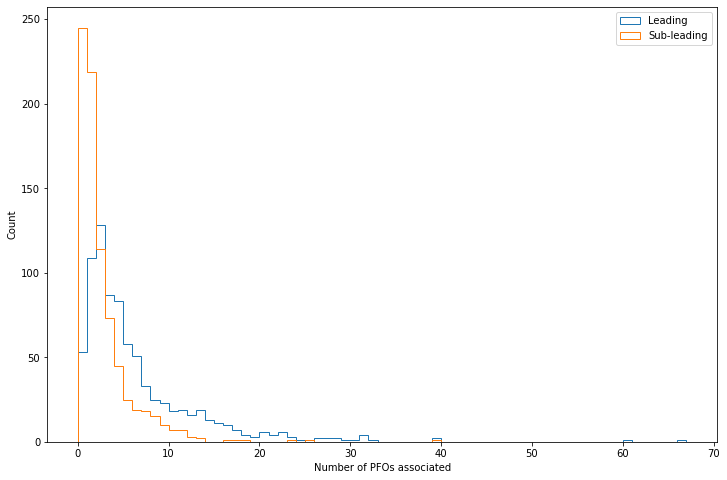

4811 leading PFOs, 1769 sub-leading PFOs.
2626 poorly reconstructed leading PFOs, 1011 poorly reconstructed sub-leading PFOs.


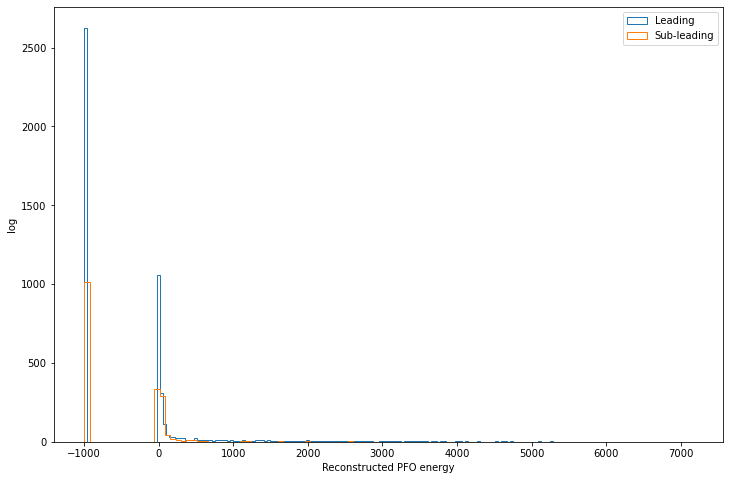

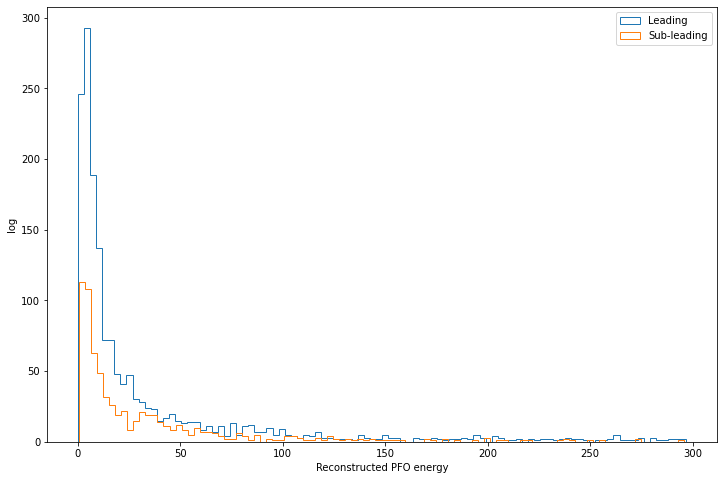

In [28]:
num_events = ak.num(evts.trueParticlesBT.mother, axis=0)

# This is only valid for the 1 pi0 in event, 2 photon decay cut
truth_ids_photon_beam = np.zeros((num_events, 2))

truth_num_pi0s = np.zeros(num_events)
truth_num_photons = np.zeros(num_events)
truth_num_pi0s_beam = np.zeros(num_events)
truth_num_photons_beam = np.zeros(num_events)

reco_bt_num_pi0s = np.zeros(num_events)
reco_bt_num_photons = np.zeros(num_events)
reco_bt_num_pi0s_beam = np.zeros(num_events)
reco_bt_num_photons_beam = np.zeros(num_events)

reco_photon_i = np.zeros(num_events)
reco_photon_ii = np.zeros(num_events)

reco_energies_i = [[]]*num_events
reco_energies_ii = [[]]*num_events

for i in range(num_events):
    truth_mothers = evts.trueParticles.mother[i].to_numpy()
    truth_ids = evts.trueParticles.number[i].to_numpy()
    truth_pdgs = evts.trueParticles.pdg[i].to_numpy()
    truth_energy = evts.trueParticles.energy[i].to_numpy()

    bt_ids = evts.trueParticlesBT.number[i].to_numpy()
    reco_ids = evts.recoParticles.number[i].to_numpy()
    reco_energies = evts.recoParticles.energy[i].to_numpy()

    if not (True in (evts.recoParticles.beam_number[i] == evts.recoParticles.number[i])):
        print(f"Problem with index {i}, beam particle not found in reco data.")
    # beam_index = np.where(evts.recoParticles.beam_number[i] == evts.recoParticles.number[i])[0]
    # print(beam_index)

    beam_mask = get_MC_truth_beam_mask(truth_mothers, truth_ids)
    
    beam_pi_ids = np.unique(truth_ids[np.logical_and(truth_pdgs == 111, beam_mask)])
    beam_pi_photons_ids = truth_ids[np.logical_and(truth_pdgs == 22, beam_mask)]

    # Number of pi0s in an event (strictly an inefficient way, since this looks over all PFOs,
    # which is larger than the number of truth particles, yet the value could be obtained from purely true particles)
    truth_num_pi0s[i] = len(np.unique(truth_ids[truth_pdgs == 111]))
    truth_num_pi0s_beam[i] = len(beam_pi_ids)

    # Number of photons which are daughters of pi0s in an event
    truth_num_photons[i] = len(np.unique(truth_ids[truth_pdgs == 22]))
    truth_num_photons_beam[i] = len(beam_pi_photons_ids)
    sorted_energies = np.flip(np.argsort(truth_energy[np.logical_and(truth_pdgs == 22, beam_mask)]))
    truth_ids_photon_beam[i,:] = beam_pi_photons_ids[sorted_energies]

    # Number of pi0s in an event (strictly an inefficient way, since this looks over all PFOs,
    # which is larger than the number of truth particles, yet the value could be obtained from purely true particles)
    reco_bt_num_pi0s[i] = len(np.unique(reco_ids[ [ e in np.unique(truth_ids[truth_pdgs == 111]) for e in bt_ids ] ]))
    reco_bt_num_pi0s_beam[i] = len(np.unique(reco_ids[ [ e in beam_pi_ids for e in bt_ids ] ]))

    # Number of photons which are daughters of pi0s in an event
    reco_bt_num_photons[i] = len(np.unique(reco_ids[ [ e in np.unique(truth_ids[truth_pdgs == 22]) for e in bt_ids ] ]))
    reco_bt_num_photons_beam[i] = len(np.unique(reco_ids[ [ e in beam_pi_photons_ids for e in bt_ids ] ]))
    reco_photon_i[i] = np.sum(bt_ids == beam_pi_photons_ids[sorted_energies][0])
    reco_photon_ii[i] = np.sum(bt_ids == beam_pi_photons_ids[sorted_energies][-1])
    reco_energies_i[i] = ak.to_list(reco_energies[bt_ids == beam_pi_photons_ids[sorted_energies][0]])
    reco_energies_ii[i] = ak.to_list(reco_energies[bt_ids == beam_pi_photons_ids[sorted_energies][-1]])



    # # This confirms that my method matches Shyam's method
    # if len(reco_ids[ [ e in beam_pi_photons_ids for e in bt_ids ] ]) != np.sum(evts.trueParticlesBT.particleNumber[i] != -1):
    #     print(i)
    #     print(len(reco_ids[ [ e in beam_pi_photons_ids for e in bt_ids ] ]))
    #     print(np.sum(evts.trueParticlesBT.particleNumber[i] != -1))

print("Numbers of truth pi0s per event:")
print(np.unique(truth_num_pi0s, return_counts=True))
print("Of which from the beam:")
print(np.unique(truth_num_pi0s_beam, return_counts=True))

print("\nNumbers of truth photons per event:")
print(np.unique(truth_num_photons, return_counts=True))
print("Of which from the beam:")
print(np.unique(truth_num_photons_beam, return_counts=True))

print("\nNumbers of reco pi0s per event:")
print(np.unique(reco_bt_num_pi0s, return_counts=True))
print("Of which from the beam:")
print(np.unique(reco_bt_num_pi0s_beam, return_counts=True))

print("\nNumbers of reco photons per event:")
print(np.unique(reco_bt_num_photons, return_counts=True))
print("Of which from the beam:")
print(np.unique(reco_bt_num_photons_beam, return_counts=True))

plt.figure(figsize=(12,8))
plt.hist(reco_photon_i, label="Leading", histtype="step", bins=int(np.max(reco_photon_i)))
plt.hist(reco_photon_ii, label="Sub-leading", histtype="step", bins=int(np.max(reco_photon_ii)))
plt.xlabel("Number of PFOs associated")
plt.ylabel("Count")
plt.legend()
plt.show()

reco_energies_i = ak.ravel(ak.Array(reco_energies_i))
reco_energies_ii = ak.ravel(ak.Array(reco_energies_ii))

print(f"{len(reco_energies_i)} leading PFOs, {len(reco_energies_ii)} sub-leading PFOs.")
print(f"{len(reco_energies_i[reco_energies_i == -999.])} poorly reconstructed leading PFOs, {len(reco_energies_ii[reco_energies_ii == -999.])} poorly reconstructed sub-leading PFOs.")

plt.figure(figsize=(12,8))
plt.hist(reco_energies_i, label="Leading", histtype="step", bins=200)
plt.hist(reco_energies_ii, label="Sub-leading", histtype="step", bins=100)
plt.xlabel("Reconstructed PFO energy")
plt.ylabel("Count")
plt.ylabel("log")
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.hist(reco_energies_i[np.logical_and(reco_energies_i>= 0, reco_energies_i <= 300)], label="Leading", histtype="step", bins=100)
plt.hist(reco_energies_ii[np.logical_and(reco_energies_ii>= 0, reco_energies_ii <= 300)], label="Sub-leading", histtype="step", bins=100)
plt.xlabel("Reconstructed PFO energy")
plt.ylabel("Count/3MeV")
plt.ylabel("log")
plt.legend()
plt.show()

In [18]:
# def event_count_plot(all_nums, all_counts, beam_numbers, beam_counts, pdg_code = "111"):
#     plt.figure(figsize=(8,6))
#     plt.hist(all_nums, weights=all_counts, bins=int(np.max(all_nums)+1e-7), label="All", color="C1", histtype="step")
#     plt.hist(beam_numbers, weights=beam_counts, bins=int(np.max(beam_numbers)+1e-7), label="From beam only", color="C0", histtype="step")
#     plt.xlabel(f"Number of truth objects with pdg code {pdg_code}")
#     plt.ylabel("Count")
#     plt.tight_layout()
#     plt.legend()
#     plt.show()

# event_count_plot(*np.unique(truth_num_pi0s, return_counts=True), *np.unique(truth_num_pi0s_beam, return_counts=True), "111")

# event_count_plot(*np.unique(truth_num_photons, return_counts=True), *np.unique(truth_num_photons_beam, return_counts=True), "22")

0 count: 116
1 count: 780


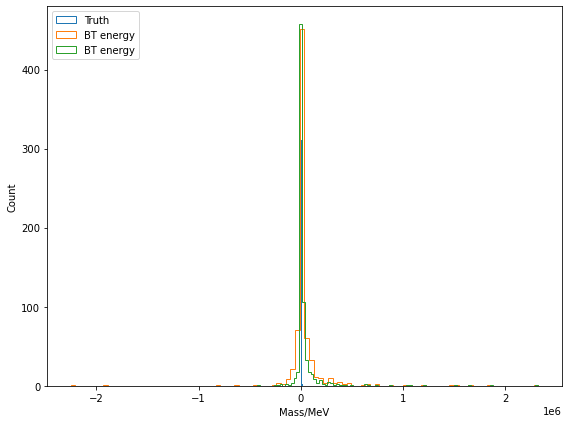

In [19]:
# # Work out a single pair of initial "true" photons foe each event
# true_mass = np.zeros(num_events)
# bt_energy_mass = np.zeros(num_events)
# reco_energy_mass = np.zeros(num_events)
# bt_dir_mass = np.zeros(num_events)
# reco_dir_mass = np.zeros(num_events)

# err_y1_e_energy = np.zeros(num_events)
# err_y2_e_energy = np.zeros(num_events)
# err_y1_e_direction = np.zeros(num_events)
# err_y2_e_direction = np.zeros(num_events)
# err_y1_e_momentum = np.zeros(num_events)
# err_y2_e_momentum = np.zeros(num_events)

# err_y1_d_energy = np.zeros(num_events)
# err_y2_d_energy = np.zeros(num_events)
# err_y1_d_direction = np.zeros(num_events)
# err_y2_d_direction = np.zeros(num_events)
# err_y1_d_momentum = np.zeros(num_events)
# err_y2_d_momentum = np.zeros(num_events)

# valid_event_mask = np.full(num_events, True, dtype=bool)

# pi0_mass = 139.6

# zero_count = 0
# one_count = 0

# verbose=False

# for i in range(num_events):
#     reco_momenta = evts.recoParticles.momentum[i]
#     # Use the reco results for invalid cases
#     reco_energies = evts.recoParticles.energy[i]
#     reco_dirs = evts.recoParticles.direction[i]

#     good_data = np.logical_and(reco_energies != -999., reco_dirs.x != -999.)

#     bt_ids = evts.trueParticlesBT.number[i].to_numpy()
#     reco_ids = evts.recoParticles.number[i].to_numpy()
#     indicies = np.arange(len(reco_momenta))

#     true_ids = evts.trueParticles.number[i].to_numpy()
#     true_momenta = evts.trueParticles.momentum[i]

#     photon_i, photon_ii = truth_ids_photon_beam[i]
#     photon_i_exists = photon_i in bt_ids[good_data]
#     photon_ii_exists = photon_ii in bt_ids[good_data]
#     if (not photon_i_exists) or (not photon_ii_exists):
#         if not (photon_i_exists or photon_ii_exists):
#             zero_count += 1
#         else:
#             one_count += 1
#         valid_event_mask[i] = False
#         continue

#     true_photon_i = true_ids == photon_i
#     true_photon_ii = true_ids == photon_ii

#     true_mom_i = true_momenta[true_photon_i]
#     true_mom_ii = true_momenta[true_photon_ii]

#     if verbose:
#         print("True particles")
#         print(true_mom_i)
#         print(true_mom_ii)
#         print(vector.magnitude(true_mom_i) * 1000)
#         print(vector.magnitude(true_mom_ii) * 1000)

#     true_dir_i = vector.normalize(true_mom_i)
#     true_dir_ii = vector.normalize(true_mom_ii)

#     true_mass[i] = (vector.dot(true_mom_i, true_mom_ii))[0]


#     photon_i_mask = [ bt_ids[good_data] == photon_i ][0]   # Don't actually know why the [0] is needed...
#     photon_ii_mask = [ bt_ids[good_data] == photon_ii ][0]

#     # set highest energy as truth
#     photon_i_energies = np.argsort(reco_energies[good_data][photon_i_mask])
#     photon_ii_energies = np.argsort(reco_energies[good_data][photon_ii_mask])

#     energy_i_index = indicies[good_data][photon_i_mask][photon_i_energies[-1]]
#     energy_ii_index = indicies[good_data][photon_ii_mask][photon_ii_energies[-1]]
    

#     # Set closest in direction as truth
#     photon_i_dirs = reco_dirs[indicies[good_data][photon_i_mask]]
#     photon_ii_dirs = reco_dirs[indicies[good_data][photon_ii_mask]]

#     dir_diff_i = np.argsort([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
#     dir_diff_ii = np.argsort([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])

#     dir_i_index = indicies[good_data][photon_i_mask][dir_diff_i[-1]]
#     dir_ii_index = indicies[good_data][photon_ii_mask][dir_diff_ii[-1]]


#     # Set largest projetion of momentum along true momentum as truth
#     mom_proj_i = np.argsort([ vector.dot(d, true_mom_i)[0] for d in reco_momenta[indicies[good_data][photon_i_mask]] ])
#     mom_proj_ii = np.argsort([ vector.dot(d, true_mom_ii)[0] for d in reco_momenta[indicies[good_data][photon_ii_mask]] ])

#     mom_i_index = indicies[good_data][photon_i_mask][mom_proj_i[-1]]
#     mom_ii_index = indicies[good_data][photon_ii_mask][mom_proj_ii[-1]]

#     if verbose:
#         print("Reco stuff:")
#         print("Energies")
#         print(reco_energies[indicies[good_data][photon_i_mask]])
#         print(reco_energies[indicies[good_data][photon_ii_mask]])
#         print("Directions")
#         print(*reco_dirs[indicies[good_data][photon_i_mask]])
#         print(*reco_dirs[indicies[good_data][photon_ii_mask]])
#         print("Directions dot product")
#         print([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
#         print([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])
#     # if np.max([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ]) < -0.9:
#     #     print(f"Strange directions in index {i} for photon 1:")
#     #     print([ vector.dot(d, true_dir_i)[0] for d in photon_i_dirs ])
#     # if np.max([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ]) < 0 and len(photon_ii_dirs) > 1:
#     #     print(f"Strange directions in index {i} for photon 2:")
#     #     print([ vector.dot(d, true_dir_ii)[0] for d in photon_ii_dirs ])


#     # if dir_i_index != energy_i_index:
#     #     print(f"Direction and energies {dir_i_index}, {energy_i_index} for photon 1 do not match at index {i}")
#     # if dir_ii_index != energy_ii_index:
#     #     print(f"Direction and energies {dir_ii_index}, {energy_ii_index} for photon 2 do not match at index {i}")

#     # print(reco_energies[photon_i_mask])
#     # print(reco_energies[energy_i_index])
#     # print(reco_dirs[energy_i_index])
#     # print(vector.prod(reco_energies[energy_i_index], reco_dirs[energy_i_index]))
#     # print(vector.dot(vector.prod(reco_energies[energy_i_index], reco_dirs[energy_i_index]), vector.prod(reco_energies[energy_ii_index], reco_dirs[energy_ii_index])))
#     # print(vector.dot(reco_dirs[energy_i_index], reco_dirs[energy_ii_index]) * reco_energies[energy_i_index] * reco_energies[energy_ii_index])
#     # print(vector.dot(vector.prod(reco_energies[dir_i_index], reco_dirs[dir_i_index]), vector.prod(reco_energies[dir_ii_index], reco_dirs[dir_ii_index])))
#     # print(vector.dot(reco_dirs[dir_i_index], reco_dirs[dir_ii_index]) * reco_energies[dir_i_index] * reco_energies[dir_ii_index])

#     reco_energy_mass[i] = vector.dot(reco_momenta[energy_i_index], reco_momenta[energy_ii_index])

#     reco_dir_mass[i] = vector.dot(reco_momenta[dir_i_index], reco_momenta[dir_ii_index])
    
#     err_y1_e_energy[i] = (reco_energies[energy_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
#     err_y2_e_energy[i] = (reco_energies[energy_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
#     err_y1_e_direction[i] = (reco_energies[dir_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
#     err_y2_e_direction[i] = (reco_energies[dir_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1
#     err_y1_e_momentum[i] = (reco_energies[mom_i_index] / 1000*vector.magnitude(true_mom_i)[0]) -1
#     err_y2_e_momentum[i] = (reco_energies[mom_ii_index] / 1000*vector.magnitude(true_mom_ii)[0]) -1

#     err_y1_d_energy[i] = vector.dot(reco_dirs[energy_i_index], true_dir_i[0])
#     err_y2_d_energy[i] = vector.dot(reco_dirs[energy_ii_index], true_dir_ii[0])
#     err_y1_d_direction[i] = vector.dot(reco_dirs[dir_i_index], true_dir_i[0])
#     err_y2_d_direction[i] = vector.dot(reco_dirs[dir_ii_index], true_dir_ii[0])
#     err_y1_d_momentum[i] = vector.dot(reco_dirs[mom_i_index], true_dir_i[0])
#     err_y2_d_momentum[i] = vector.dot(reco_dirs[mom_ii_index], true_dir_ii[0])

#     if verbose:
#         print("Reco data:")
#         print(*reco_momenta[good_data])
#         print(*reco_energies[good_data])
#         print("Energy data:")
#         print(reco_momenta[energy_i_index])
#         print(reco_momenta[energy_ii_index])
#         print("Direction data:")
#         print(reco_momenta[dir_i_index])
#         print(reco_momenta[dir_ii_index])
#         print("Masses:")
#         print(reco_energy_mass[i])
#         print(reco_dir_mass[i])
#         print()

# print(f"0 count: {zero_count}")
# print(f"1 count: {one_count}")

# plt.figure(figsize=(8,6))
# plt.hist(true_mass[valid_event_mask]*1e3, label="Truth", histtype="step", bins=100)
# plt.hist(reco_energy_mass[valid_event_mask], label="BT energy", histtype="step", bins=100)
# plt.hist(reco_dir_mass[valid_event_mask], label="BT energy", histtype="step", bins=100)
# plt.xlabel("Mass/MeV")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.legend()
# plt.show()


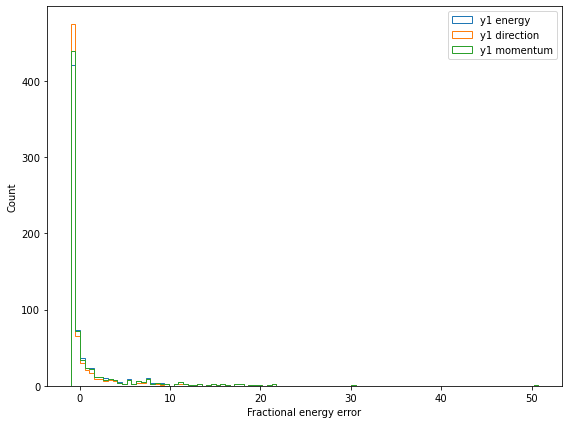

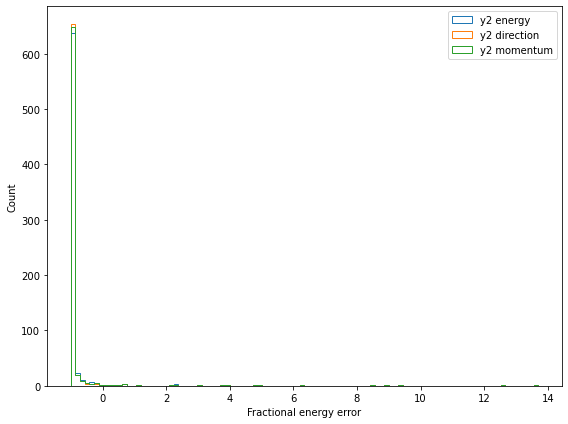

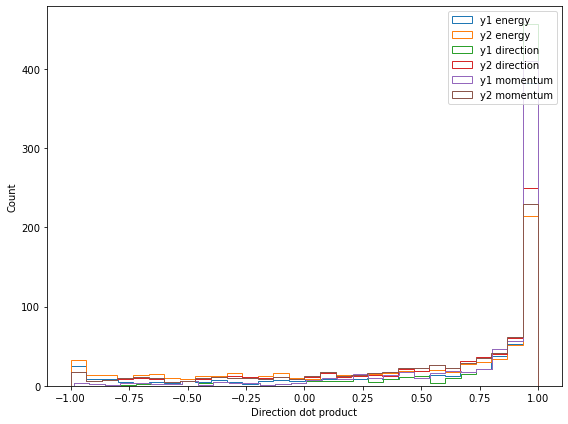

In [20]:
# # plt.figure(figsize=(8,6))
# # plt.hist(reco_energy_mass, label="BT energy", histtype="step", bins=100)
# # plt.hist(reco_energy_mass[np.logical_and(reco_energy_mass >= 0, reco_energy_mass < 10)], label="BT energy", histtype="step", bins=100)
# # plt.hist(reco_dir_mass, label="BT energy", histtype="step", bins=100)
# # plt.hist(reco_dir_mass[np.logical_and(reco_dir_mass >= 0, reco_dir_mass < 1e6)], label="BT energy", histtype="step", bins=100)
# # plt.hist(reco_dir_mass[np.logical_and(reco_dir_mass >= 0, reco_dir_mass < 10)], label="BT energy", histtype="step", bins=100)

# plt.figure(figsize=(8,6))
# plt.hist(err_y1_e_energy[valid_event_mask], label="y1 energy", histtype="step", bins=100)
# # plt.hist(err_y2_e_energy[valid_event_mask], label="y2 energy", histtype="step", bins=100)
# plt.hist(err_y1_e_direction[valid_event_mask], label="y1 direction", histtype="step", bins=100)
# # plt.hist(err_y2_e_direction[valid_event_mask], label="y2 direction", histtype="step", bins=100)
# plt.hist(err_y1_e_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=100)
# # plt.hist(err_y2_e_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=100)
# plt.xlabel("Fractional energy error")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# # plt.hist(err_y1_e_energy[valid_event_mask], label="y1 energy", histtype="step", bins=100)
# plt.hist(err_y2_e_energy[valid_event_mask], label="y2 energy", histtype="step", bins=100)
# # plt.hist(err_y1_e_direction[valid_event_mask], label="y1 direction", histtype="step", bins=100)
# plt.hist(err_y2_e_direction[valid_event_mask], label="y2 direction", histtype="step", bins=100)
# # plt.hist(err_y1_e_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=100)
# plt.hist(err_y2_e_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=100)
# plt.xlabel("Fractional energy error")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.hist(err_y1_d_energy[valid_event_mask], label="y1 energy", histtype="step", bins=30)
# plt.hist(err_y2_d_energy[valid_event_mask], label="y2 energy", histtype="step", bins=30)
# plt.hist(err_y1_d_direction[valid_event_mask], label="y1 direction", histtype="step", bins=30)
# plt.hist(err_y2_d_direction[valid_event_mask], label="y2 direction", histtype="step", bins=30)
# plt.hist(err_y1_d_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=30)
# plt.hist(err_y2_d_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=30)
# plt.xlabel("Direction dot product")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.legend()
# plt.show()


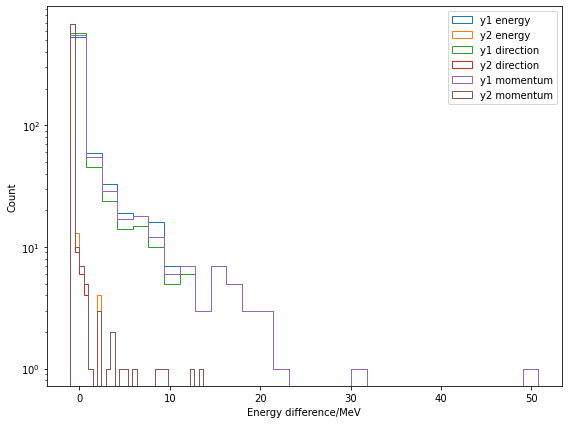

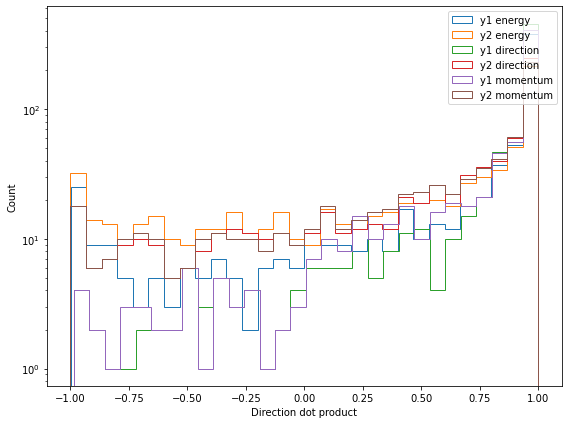

In [21]:
# plt.figure(figsize=(8,6))
# plt.hist(err_y1_e_energy[valid_event_mask], label="y1 energy", histtype="step", bins=30)
# plt.hist(err_y2_e_energy[valid_event_mask], label="y2 energy", histtype="step", bins=30)
# plt.hist(err_y1_e_direction[valid_event_mask], label="y1 direction", histtype="step", bins=30)
# plt.hist(err_y2_e_direction[valid_event_mask], label="y2 direction", histtype="step", bins=30)
# plt.hist(err_y1_e_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=30)
# plt.hist(err_y2_e_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=30)
# plt.xlabel("Energy difference/MeV")
# plt.ylabel("Count")
# plt.yscale('log')
# plt.tight_layout()
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# plt.hist(err_y1_d_energy[valid_event_mask], label="y1 energy", histtype="step", bins=30)
# plt.hist(err_y2_d_energy[valid_event_mask], label="y2 energy", histtype="step", bins=30)
# plt.hist(err_y1_d_direction[valid_event_mask], label="y1 direction", histtype="step", bins=30)
# plt.hist(err_y2_d_direction[valid_event_mask], label="y2 direction", histtype="step", bins=30)
# plt.hist(err_y1_d_momentum[valid_event_mask], label="y1 momentum", histtype="step", bins=30)
# plt.hist(err_y2_d_momentum[valid_event_mask], label="y2 momentum", histtype="step", bins=30)
# plt.xlabel("Direction dot product")
# plt.ylabel("Count")
# plt.yscale('log')
# plt.tight_layout()
# plt.legend()
# plt.show()

In [18]:
truth_pair_indicies, valid_events = get_best_pair_indicies(evts)

Events with 0 reconstructed PFOs: 66
Events with 1 reconstructed PFOs: 372


In [18]:
# simple_sig_bkg_hist(
#     "nHits", "Count", evts.recoParticles.nHits, np.logical_and(evts.trueParticlesBT.pdg == 22, mother_pdgs == 111),
#     range=[None, 100], bins = [200, 100], histtype='step', density=True
# )
# del_prop(evts.recoParticles, "nHits")

NameError: name 'mother_pdgs' is not defined

In [19]:
sig_count = sig_counts(truth_pair_indicies[valid_events], pair_coords[valid_events])
del truth_pair_indicies

evts.Filter([valid_events], [valid_events])
pair_coords = pair_coords[valid_events]
del valid_events

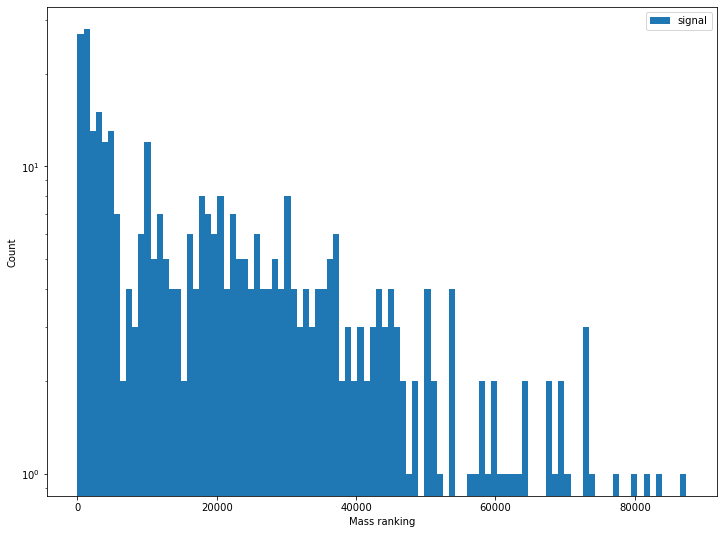

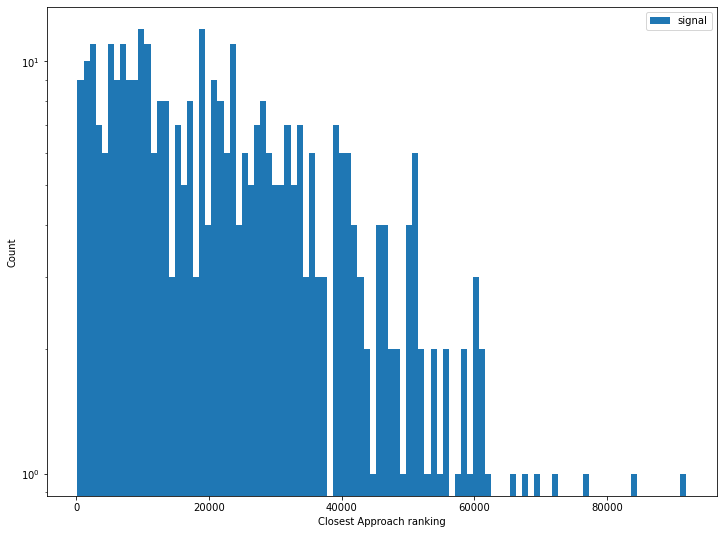

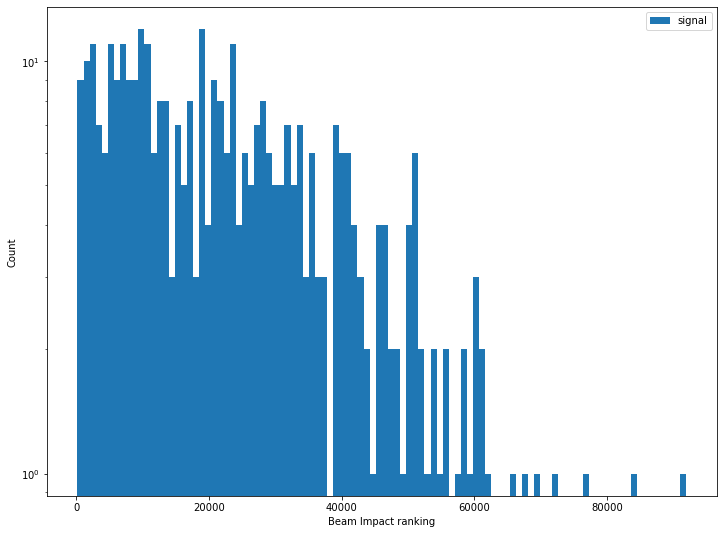

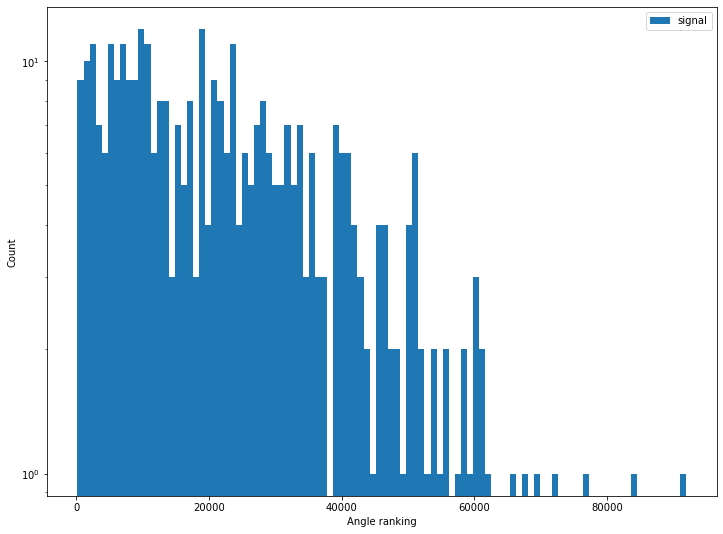

In [36]:
# This cell looks at prdering of PFOs in an event.
# We get the position of the "Truth" PFO in the event
truth_mask = sig_count == 2

mass_pos = ak.argsort(paired_mass(evts, pair_coords), ascending=True)[truth_mask]
closest_approach_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]
beam_impact_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]
angle_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]

plot_rank_hist("Mass", mass_pos, bins=100)
plot_rank_hist("Closest approach", closest_approach_pos, bins=100)
plot_rank_hist("Beam impact", beam_impact_pos, bins=100)
plot_rank_hist("Angle", angle_pos, bins=100)


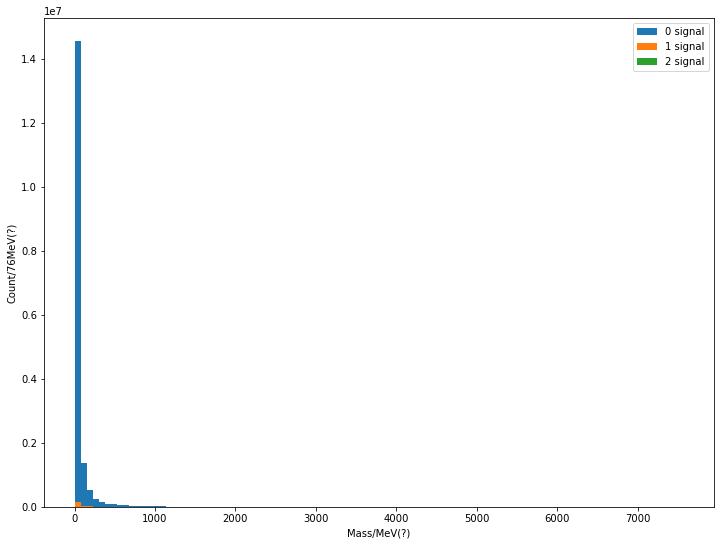

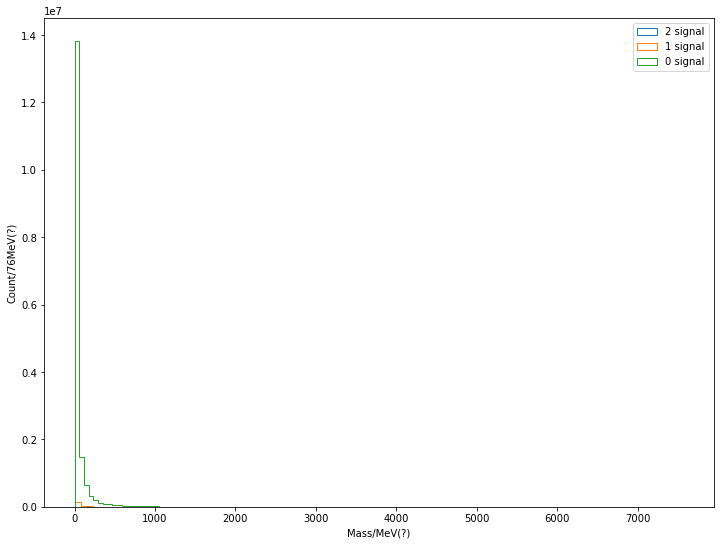

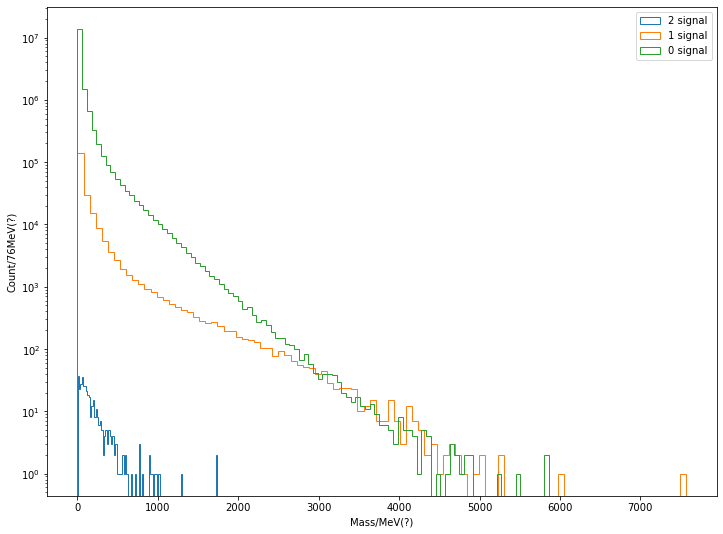

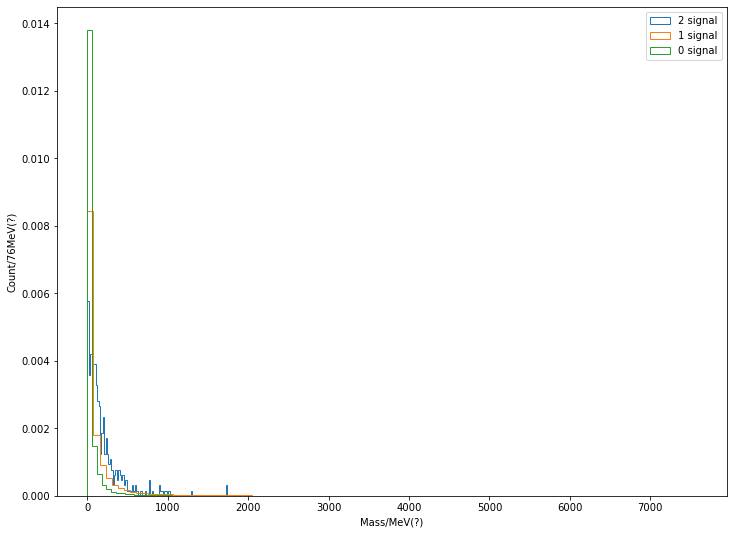

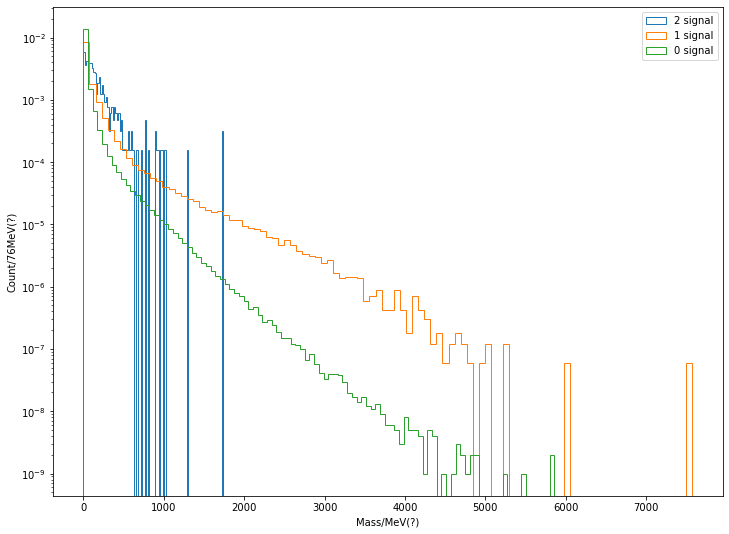

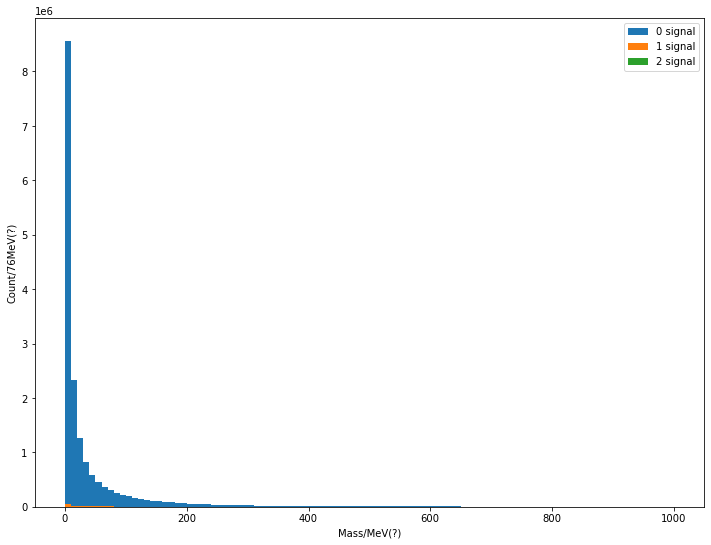

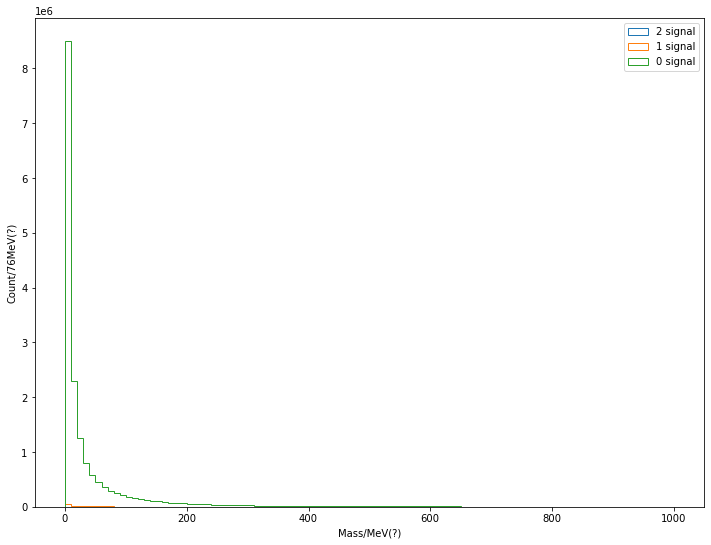

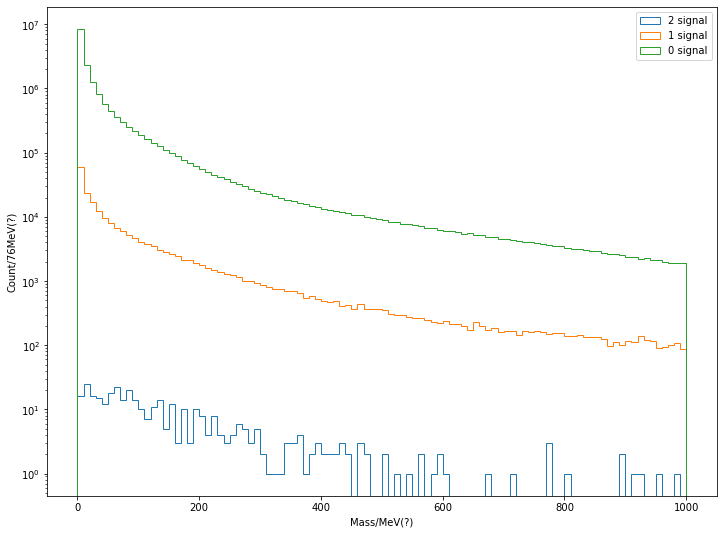

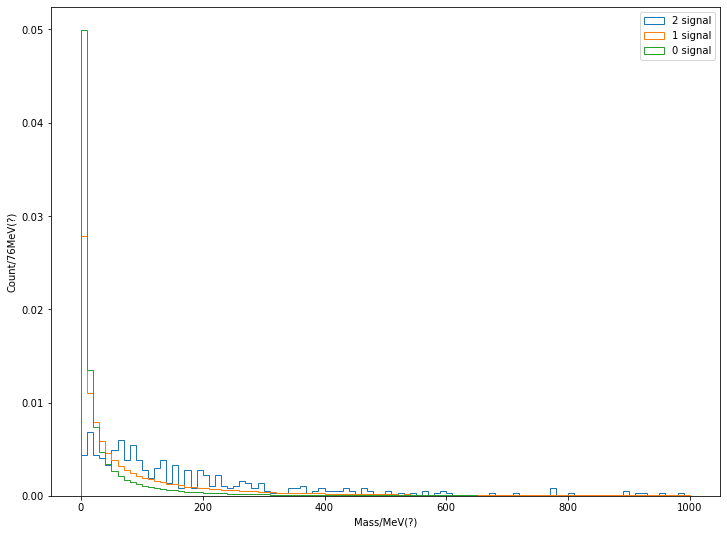

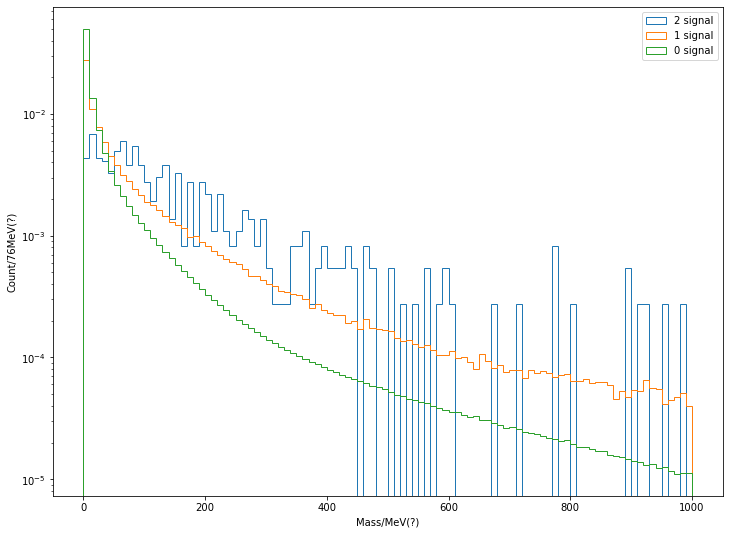

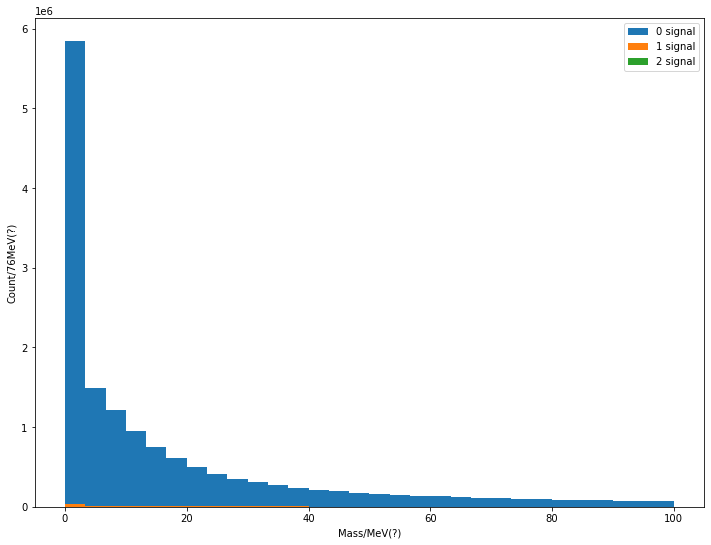

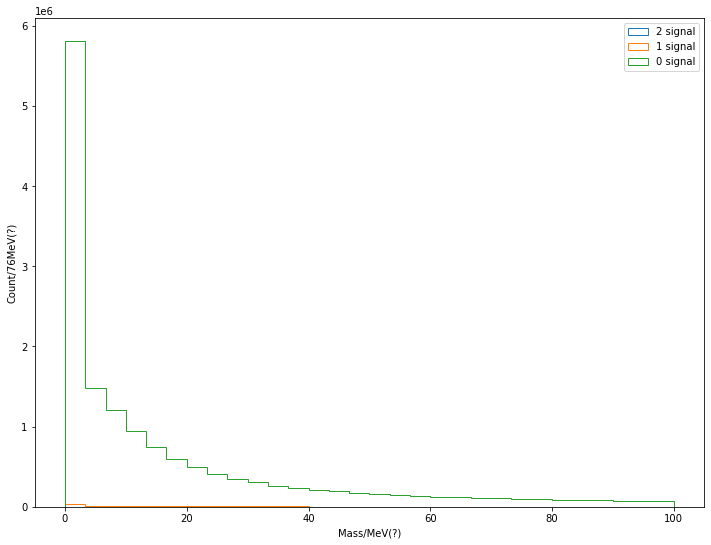

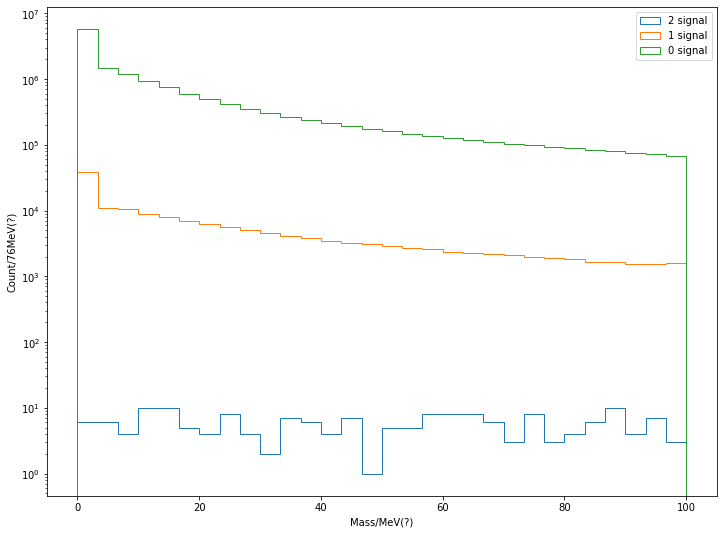

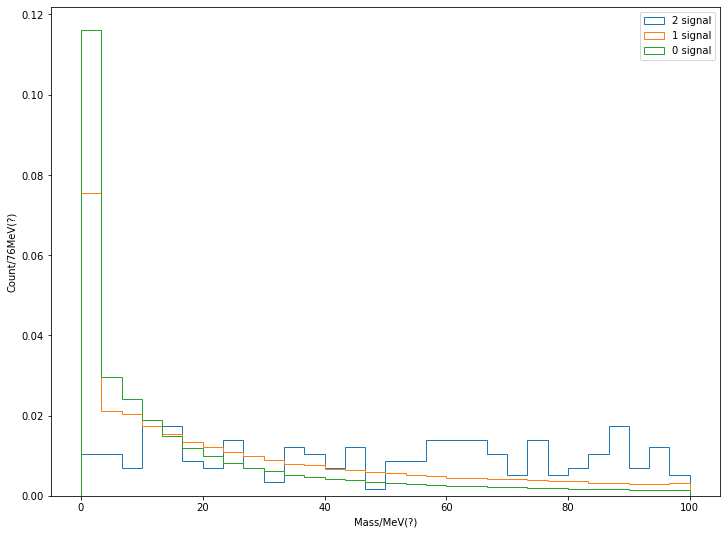

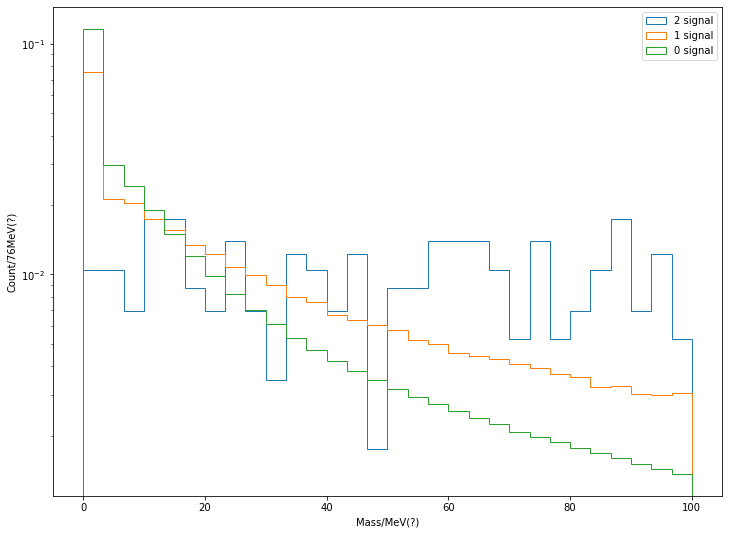

In [17]:
# masses = paired_mass(evts, pair_coords)
plot_pair_hists("mass", "MeV(?)", paired_mass(evts, pair_coords), sig_count, range=[None, 1000, 100], bins=[100, 100, 30])

In [20]:
# plt.hist(ak.ravel(paired_mass_old(ak.combinations(evts.recoParticles.momentum, 2))), bins=1000)
# plt.xlim(0,1000)
# plt.show()

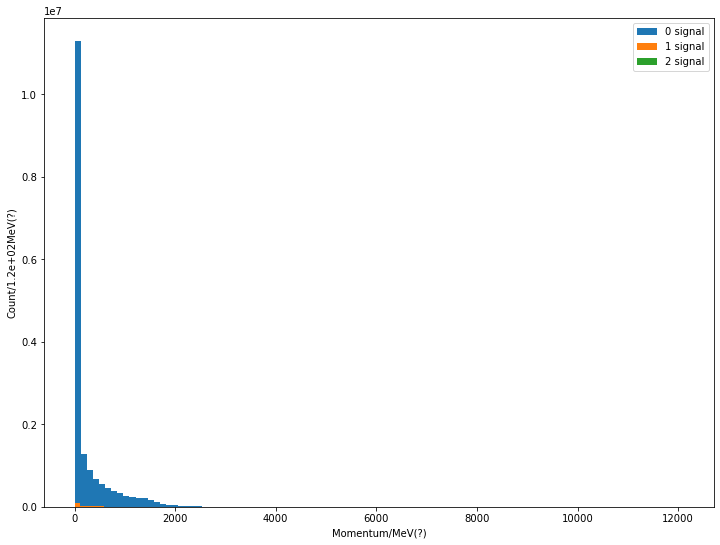

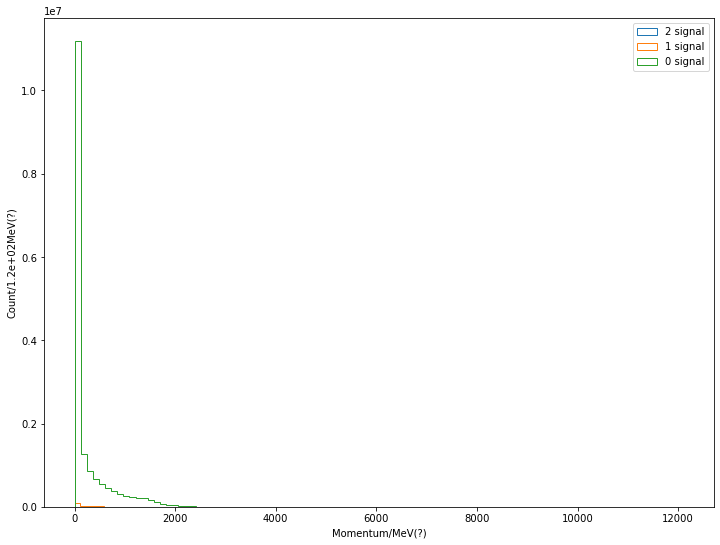

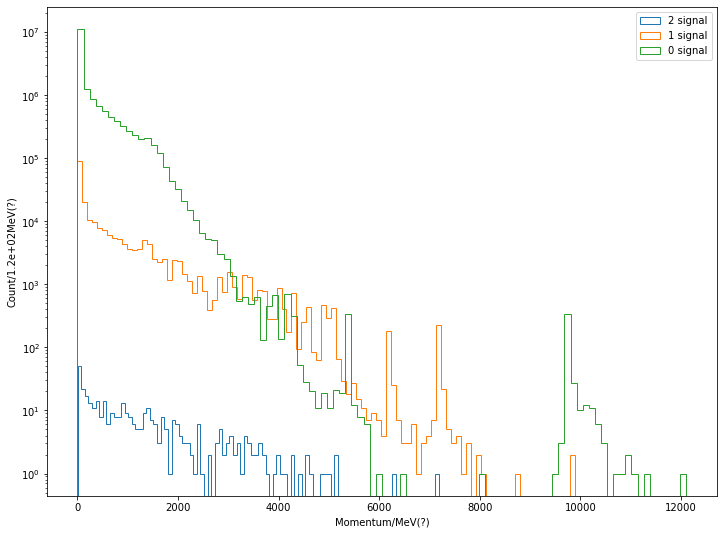

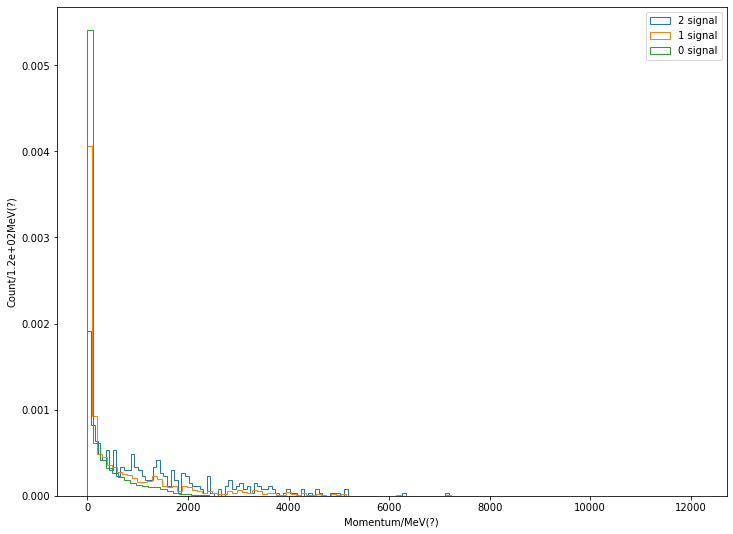

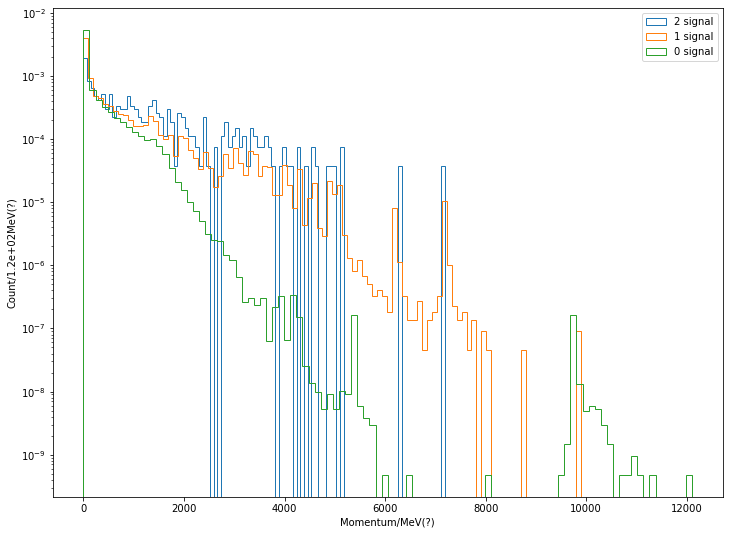

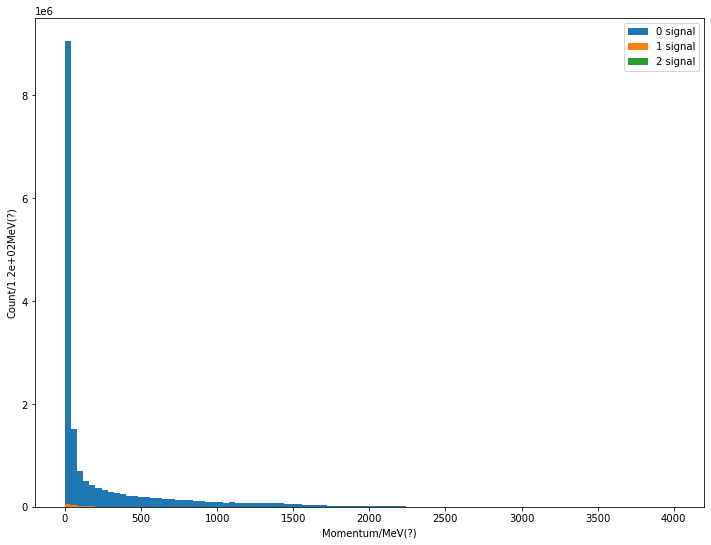

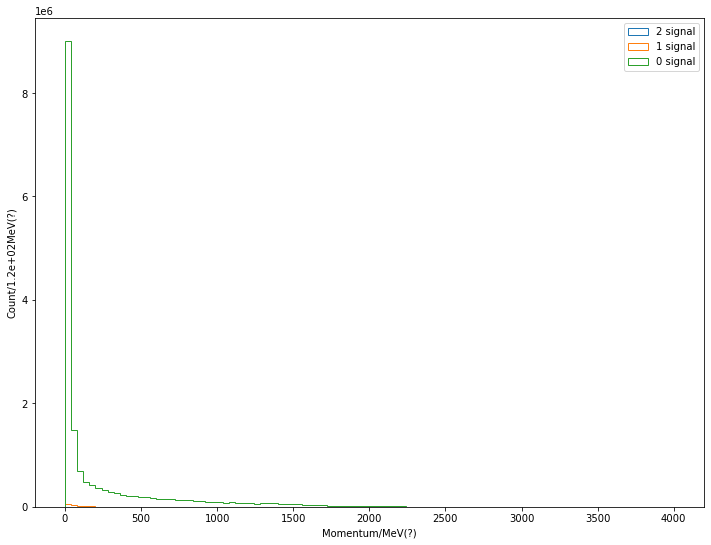

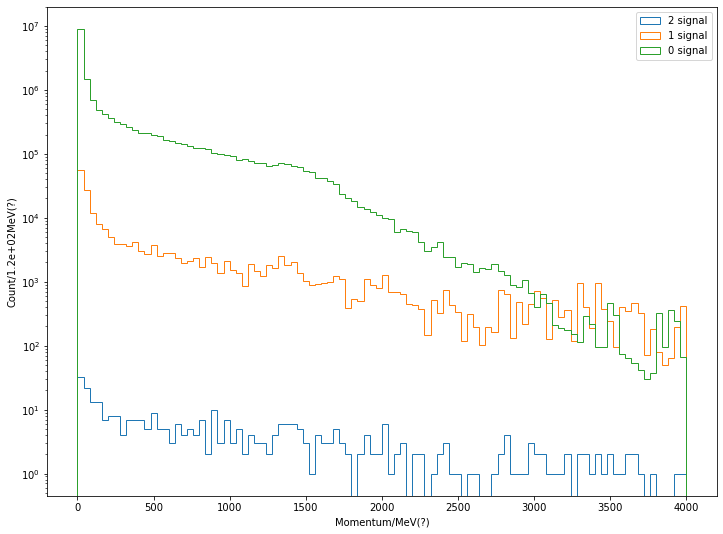

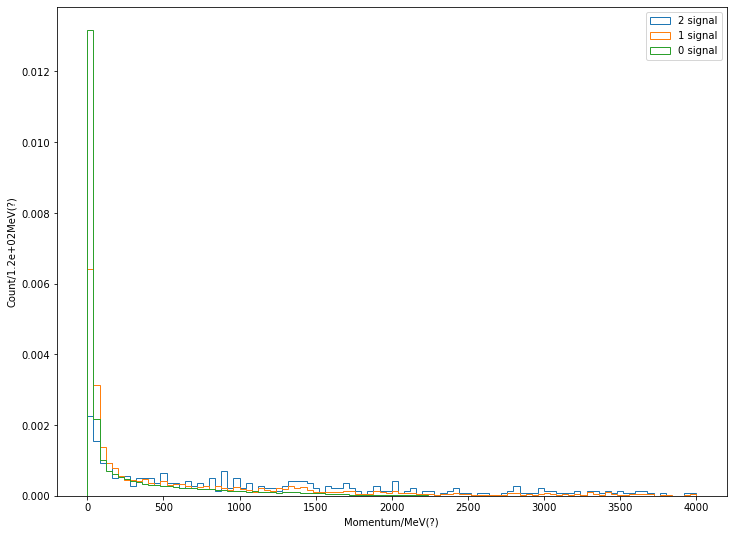

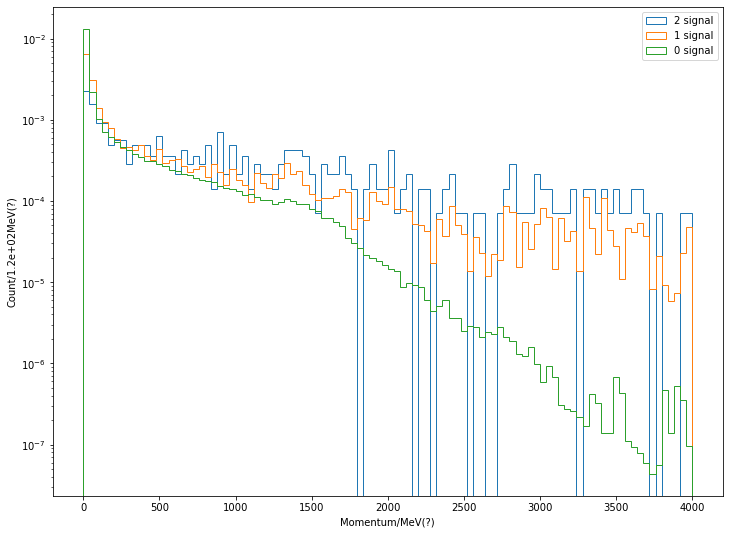

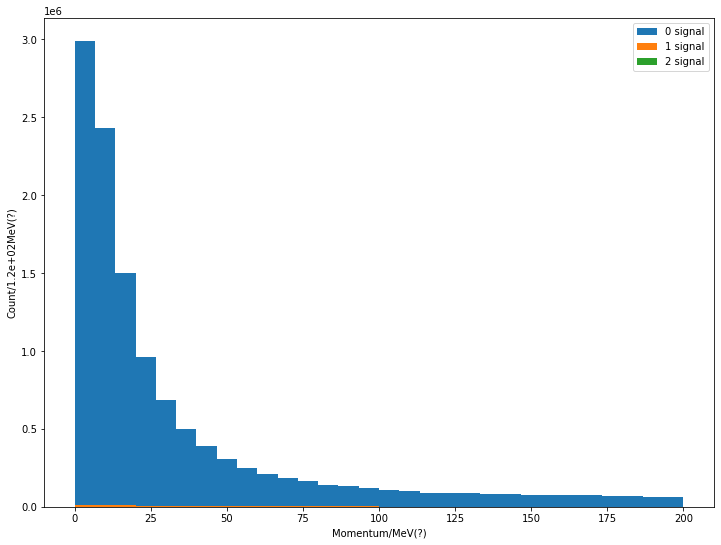

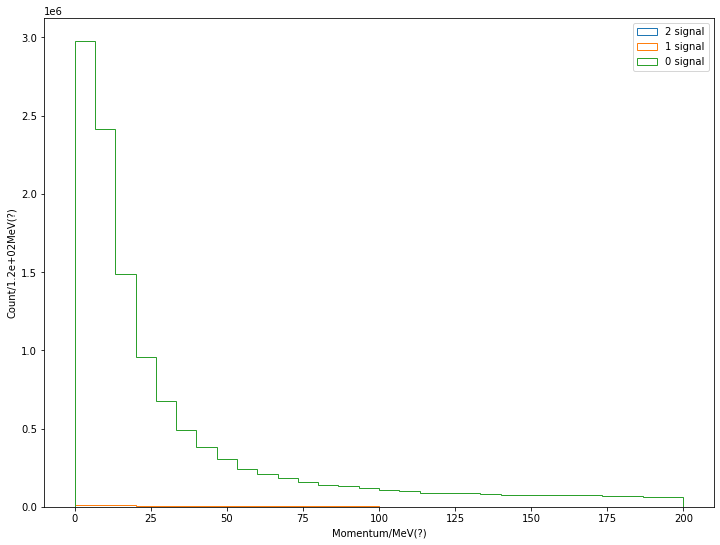

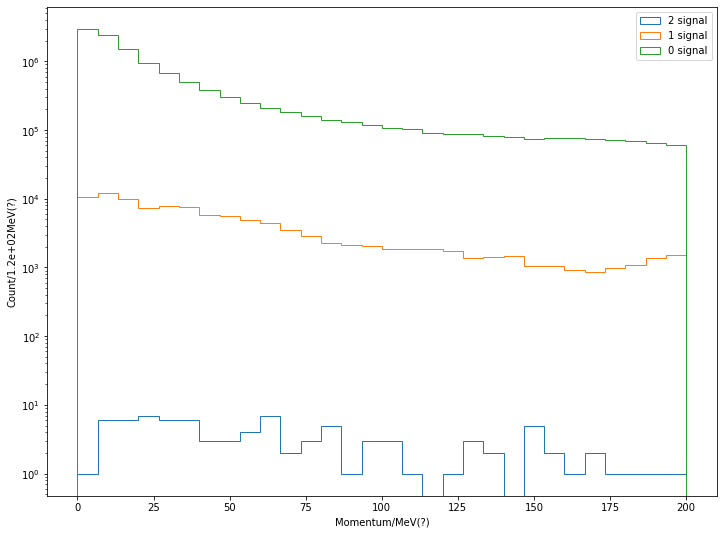

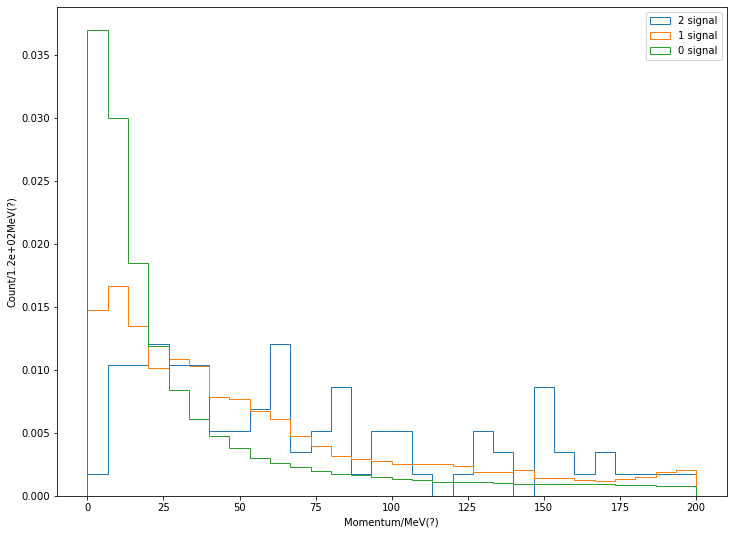

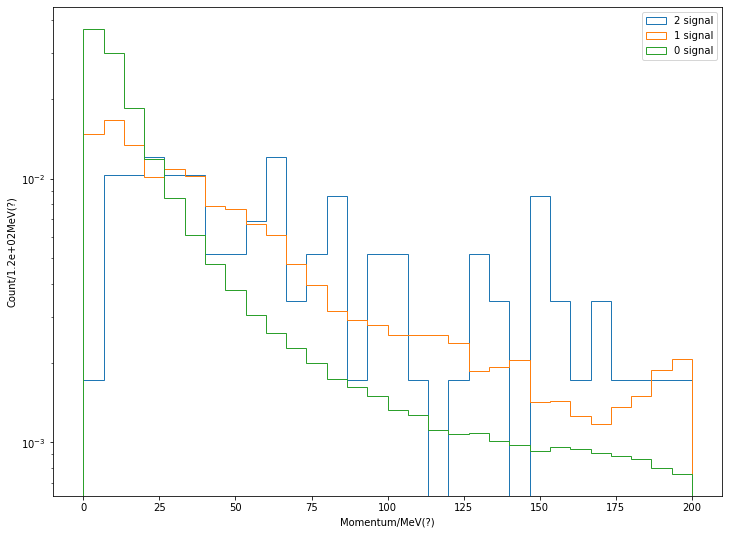

In [21]:
# momentum = paired_momentum(evts, pair_coords)
# mom_mag = vector.magnitude(momentum)
plot_pair_hists("momentum", "MeV(?)", vector.magnitude(paired_momentum(evts, pair_coords)), sig_count, range=[None, 4000, 200], bins=[100,100,30])

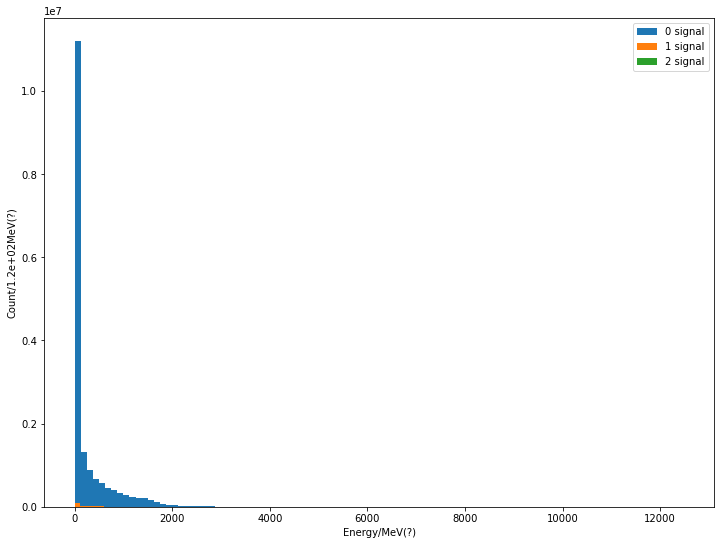

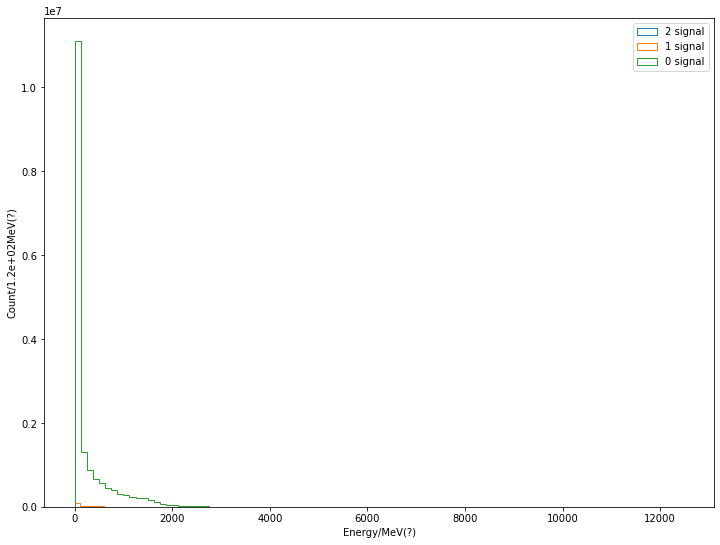

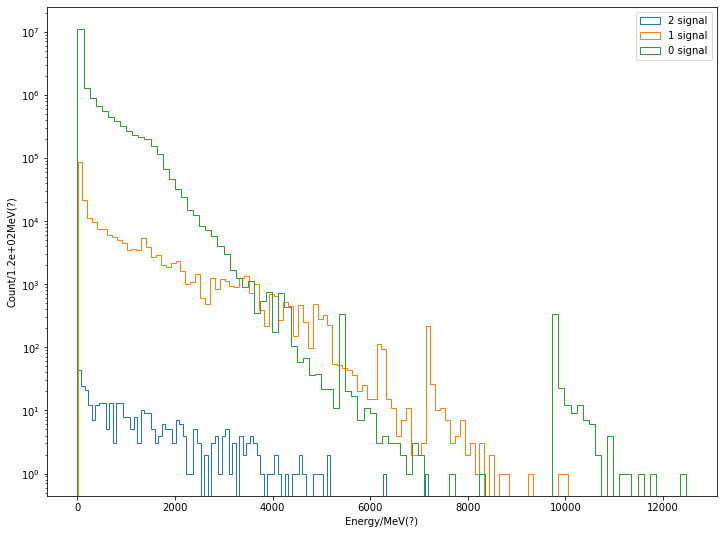

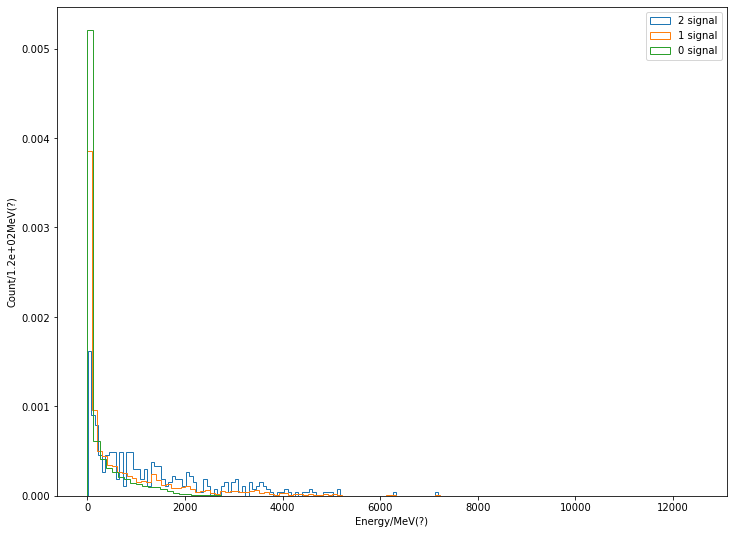

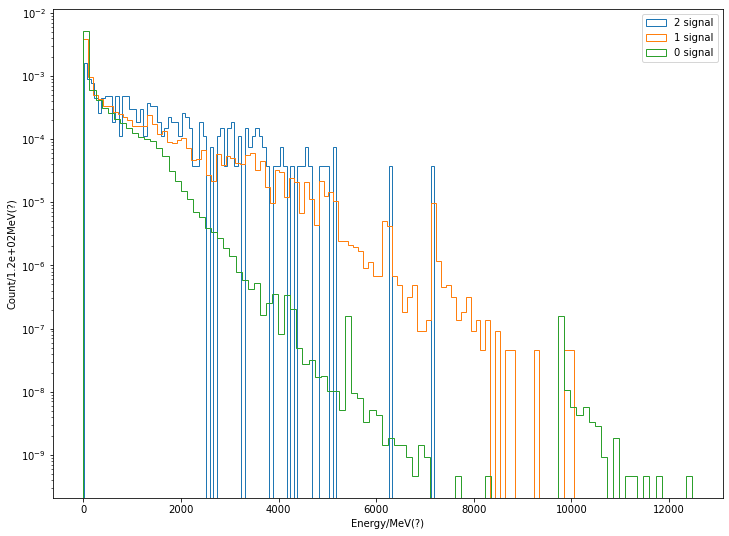

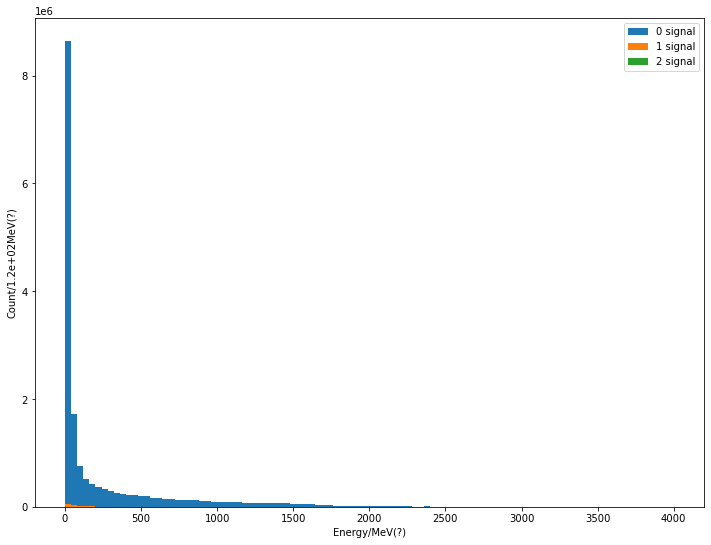

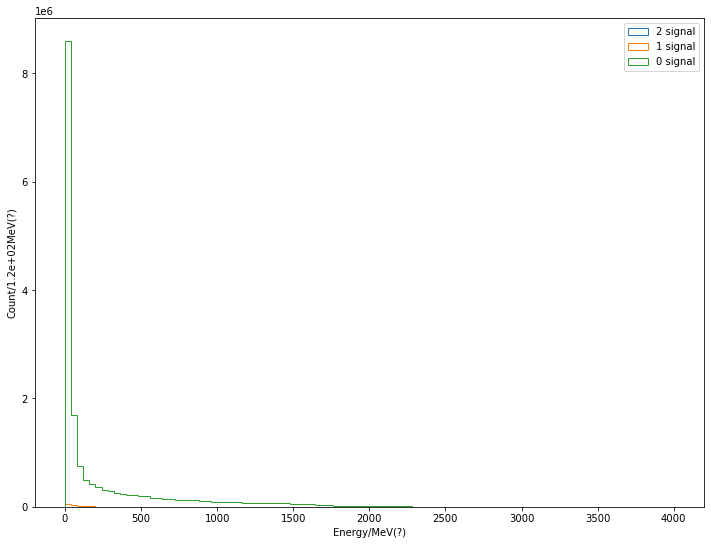

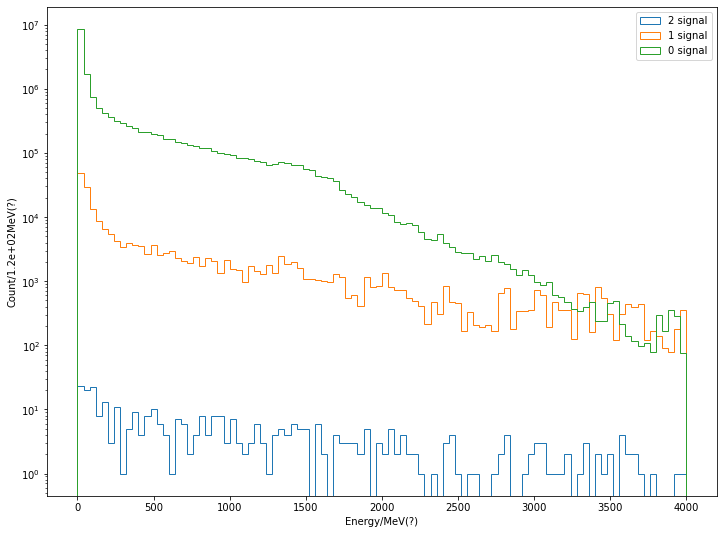

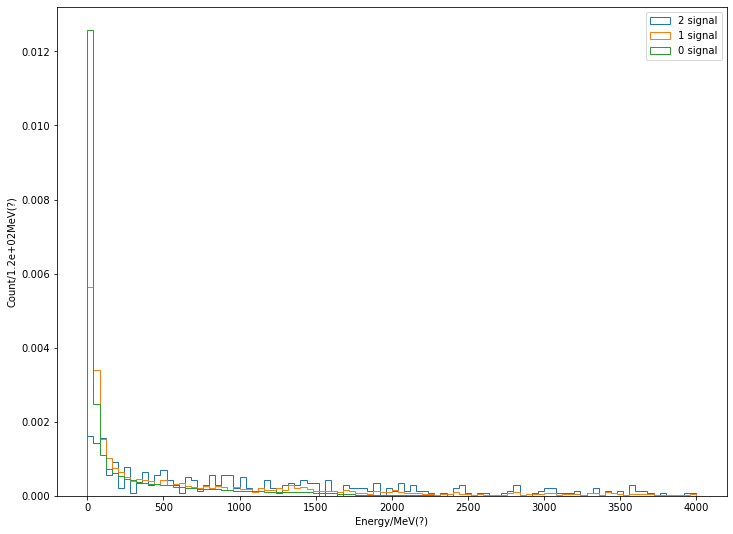

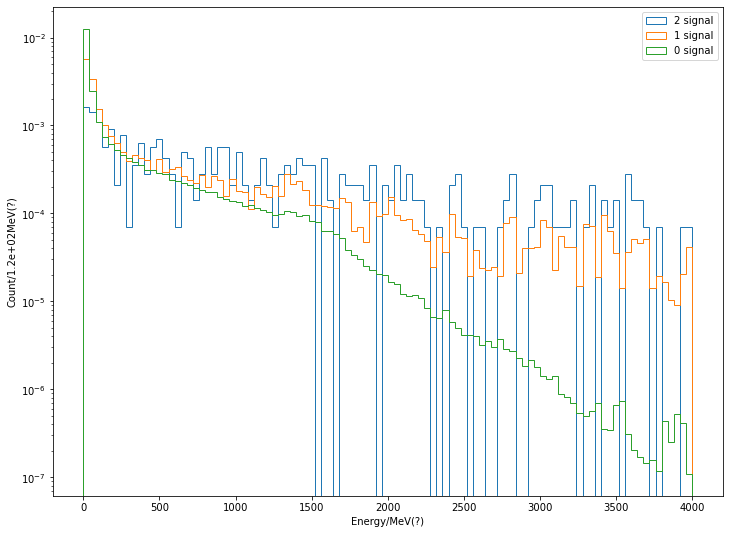

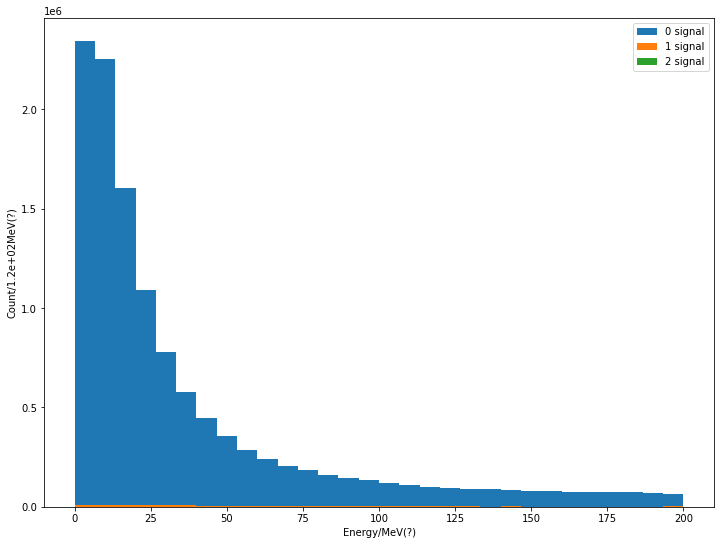

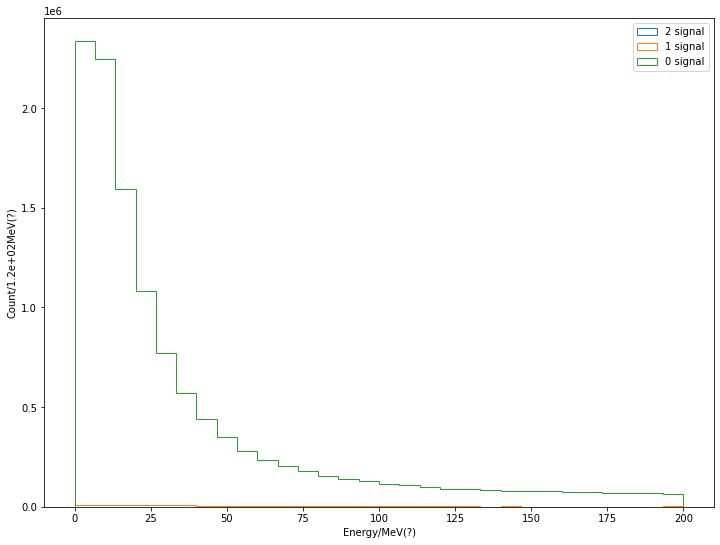

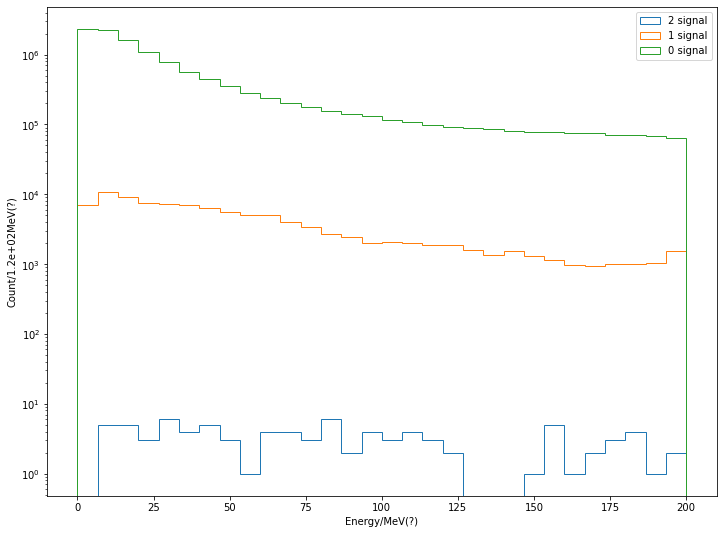

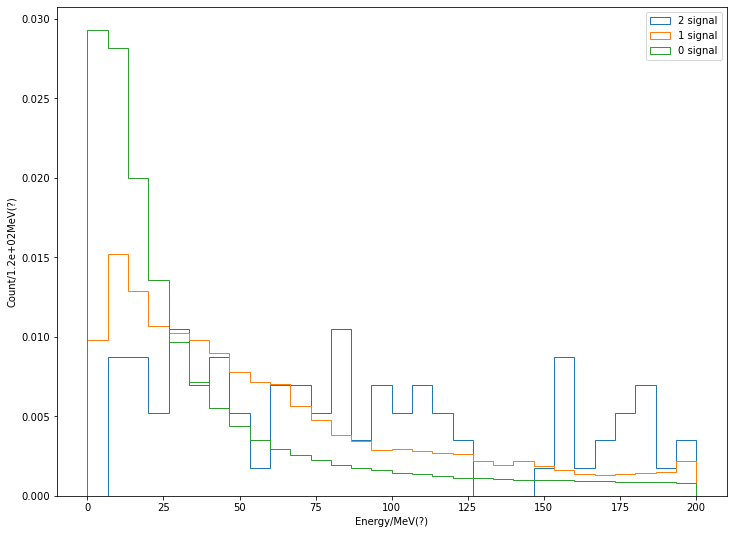

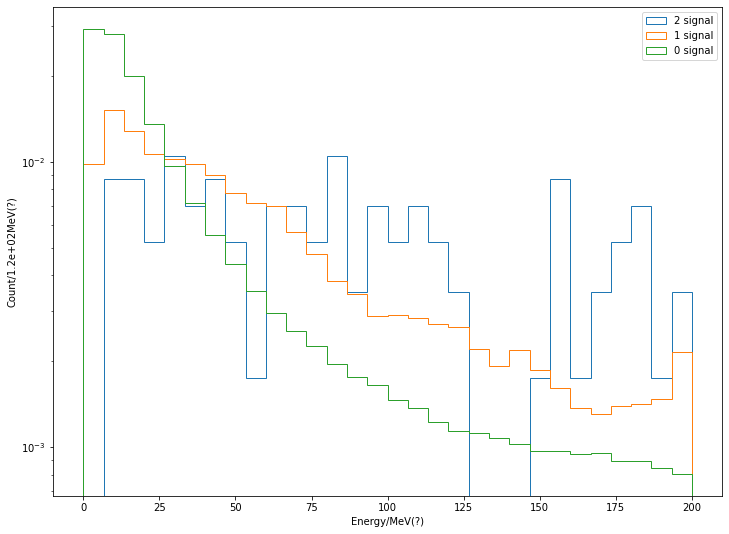

In [18]:
# energies = paired_energy(evts, pair_coords)
plot_pair_hists("energy", "MeV(?)", paired_energy(evts, pair_coords), sig_count, range=[None, 4000, 200], bins=[100,100,30])

/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


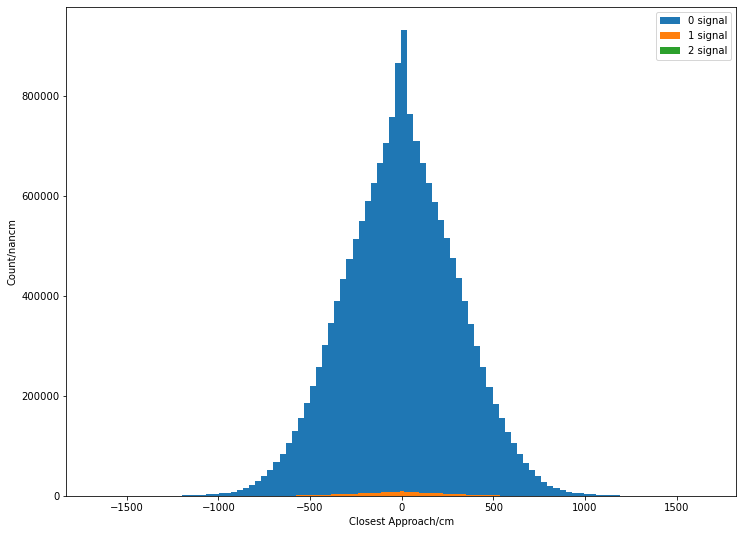

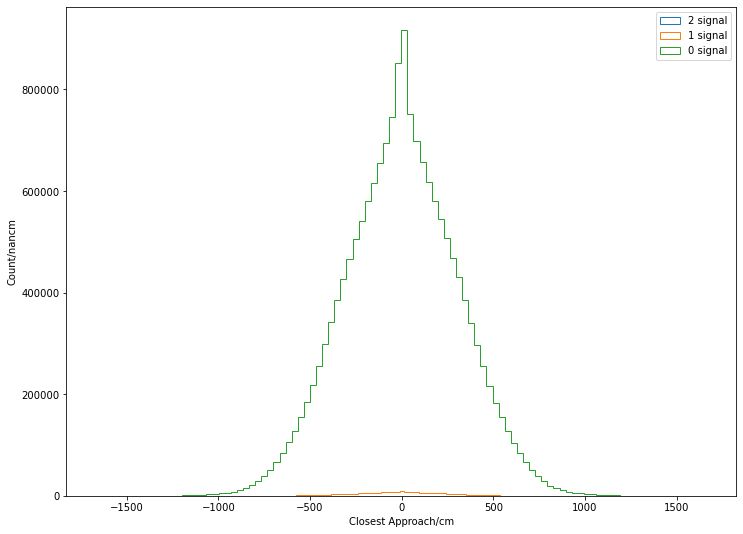

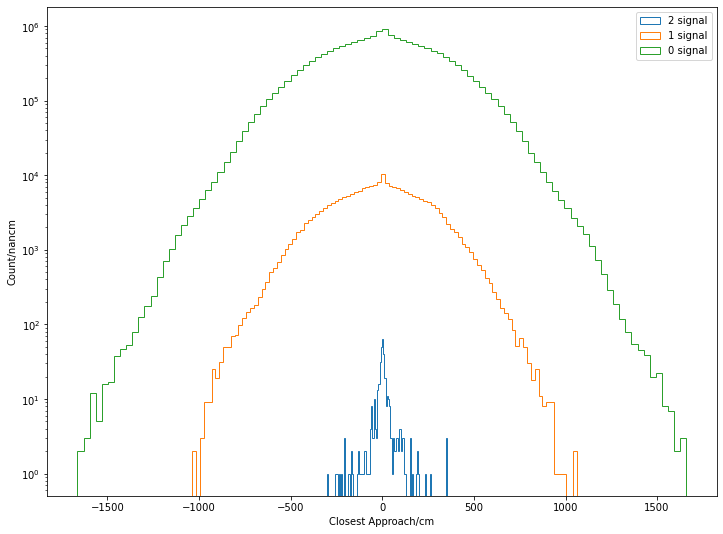

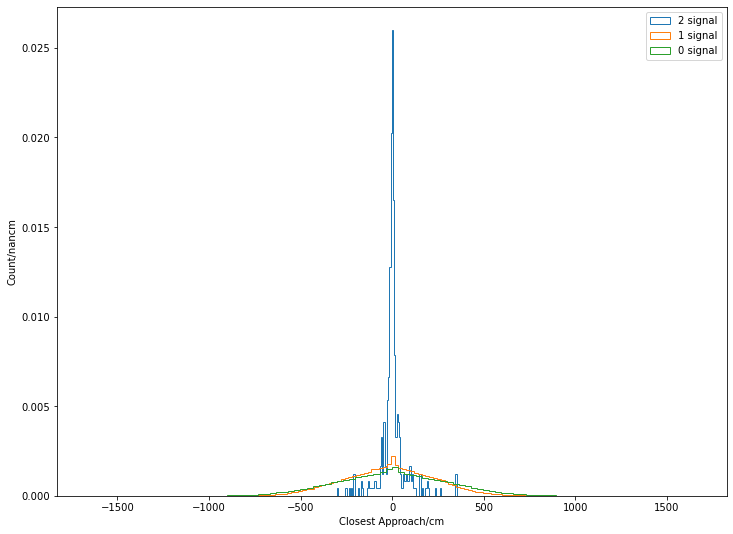

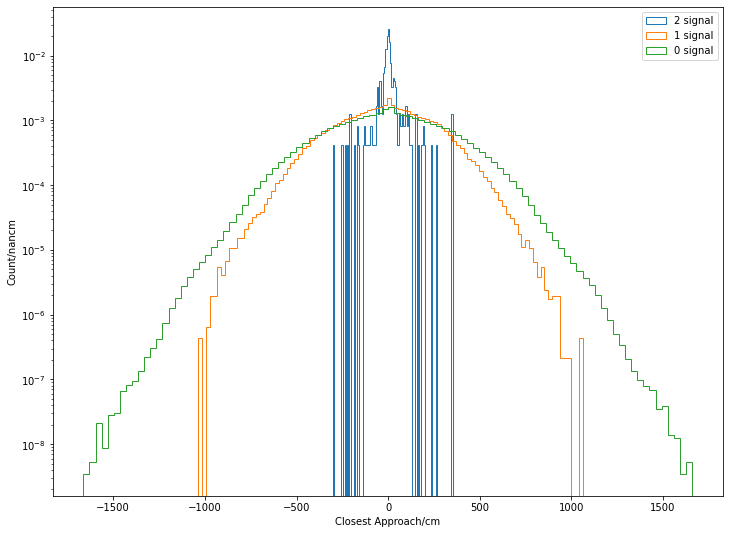

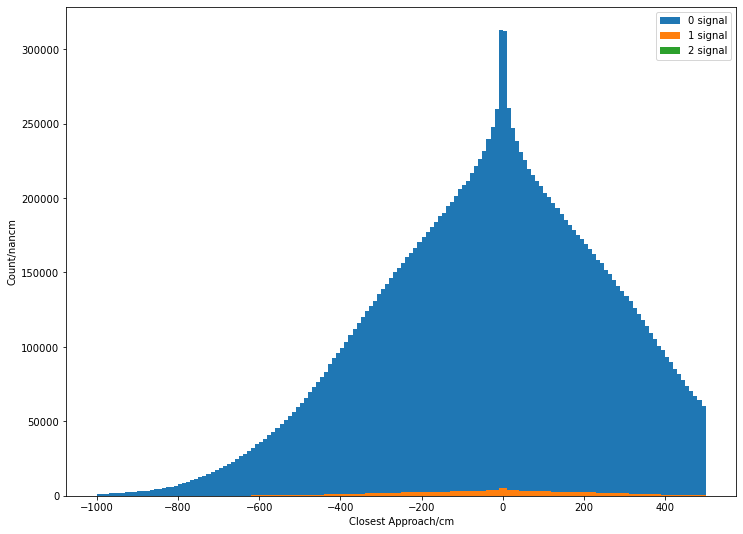

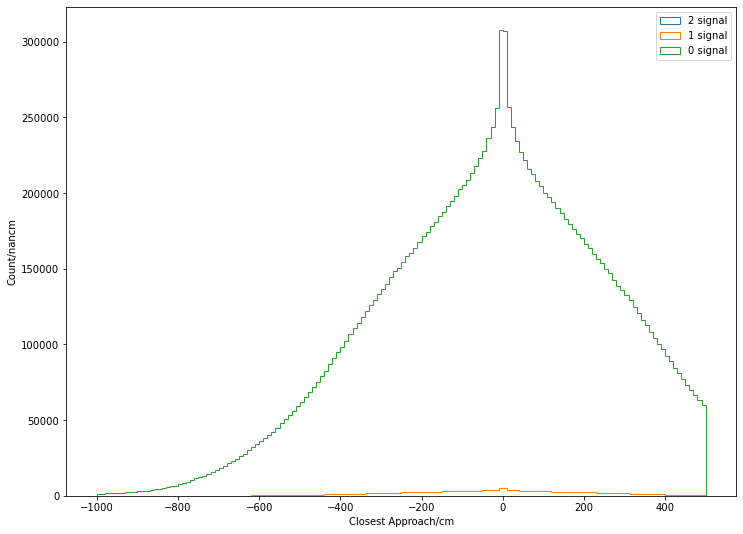

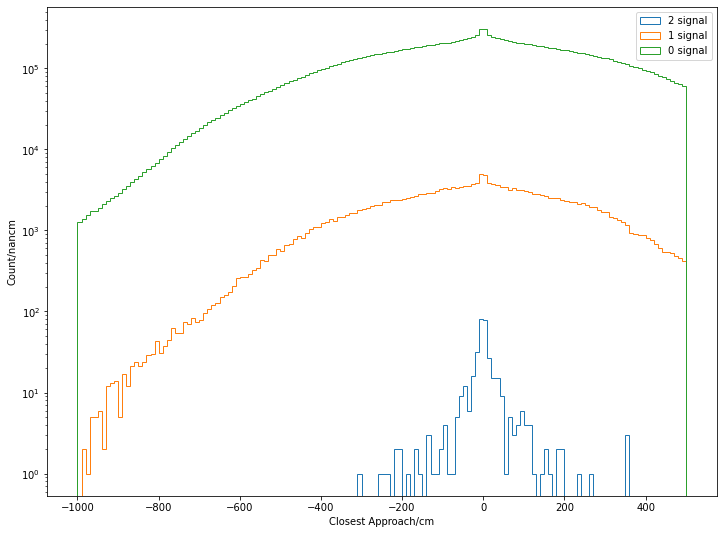

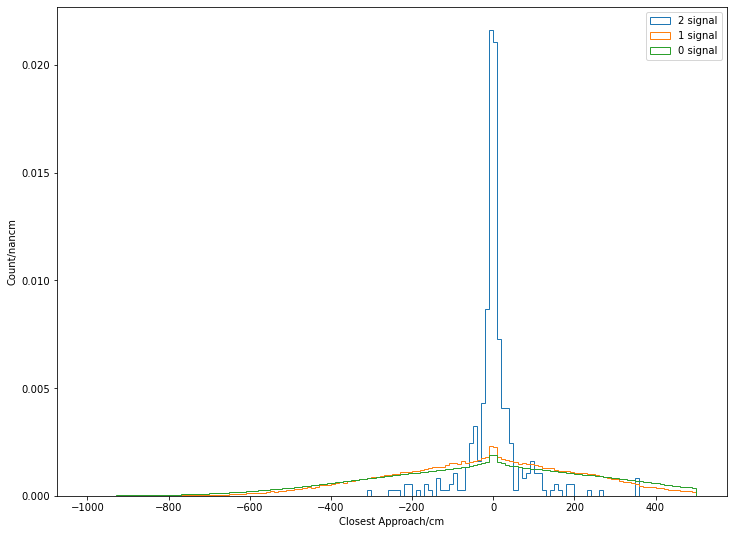

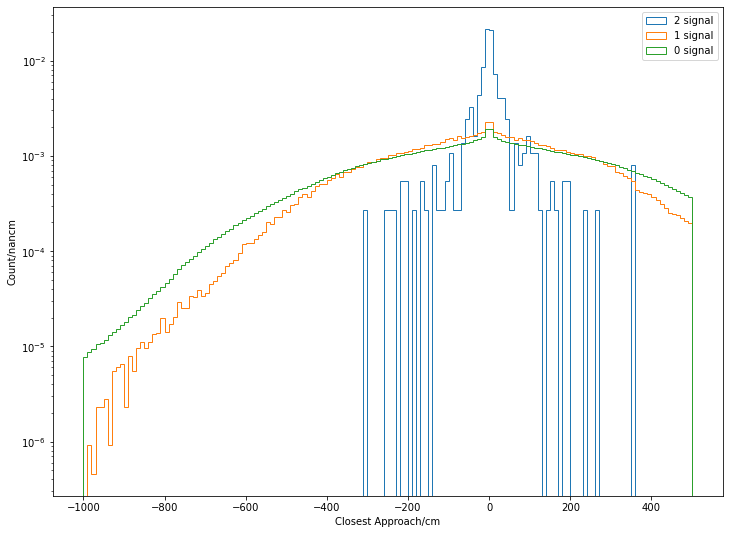

In [19]:
# approaches = paired_closest_approach(evts, pair_coords)
plot_pair_hists("closest approach", "cm", paired_closest_approach(evts, pair_coords), sig_count, range=[None, (-1000, 500)], bins=[100,150])

/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


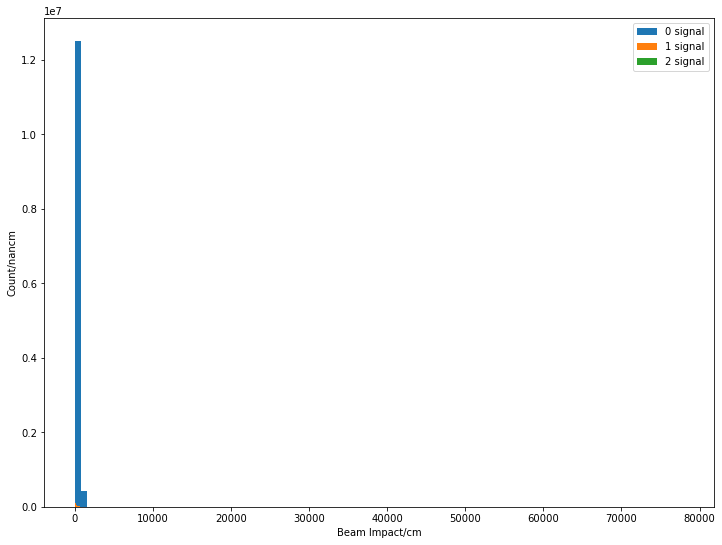

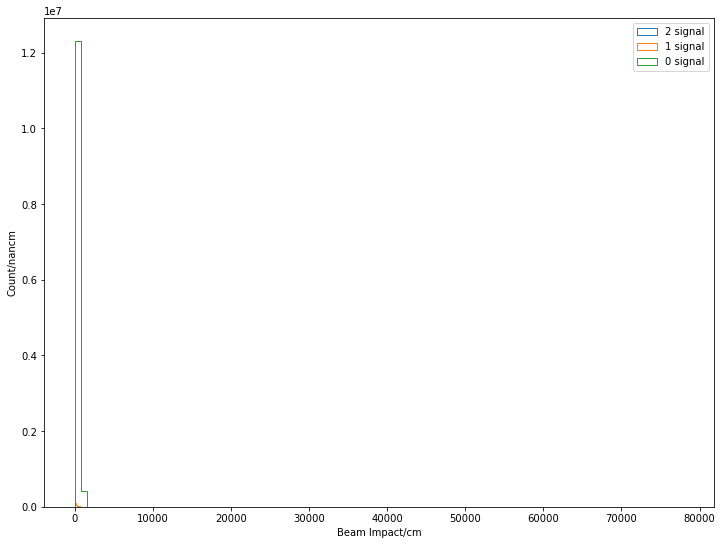

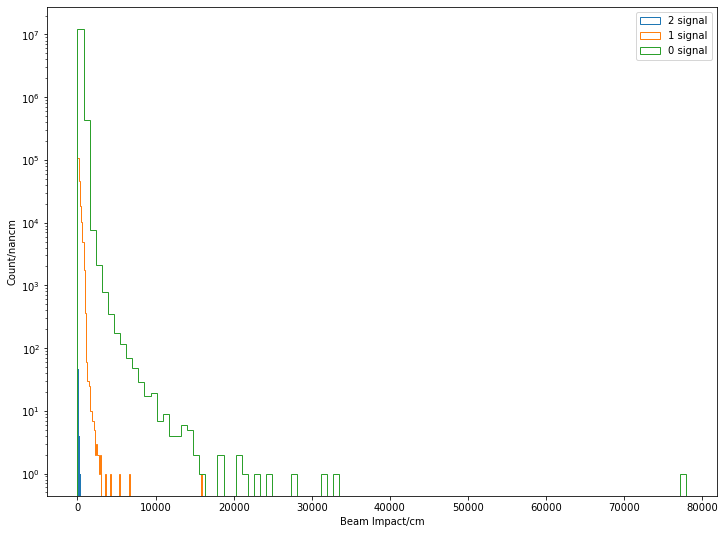

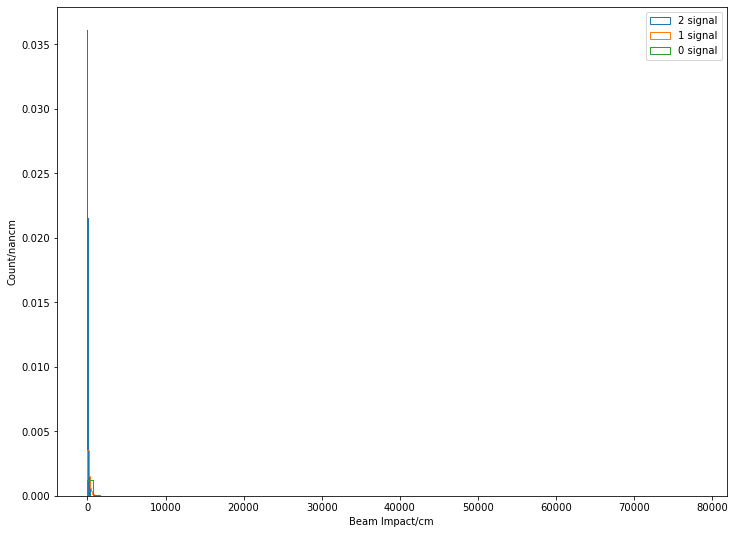

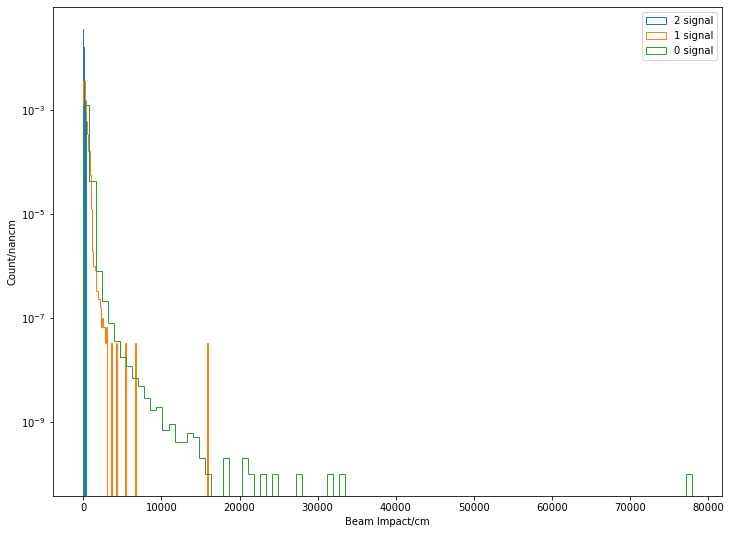

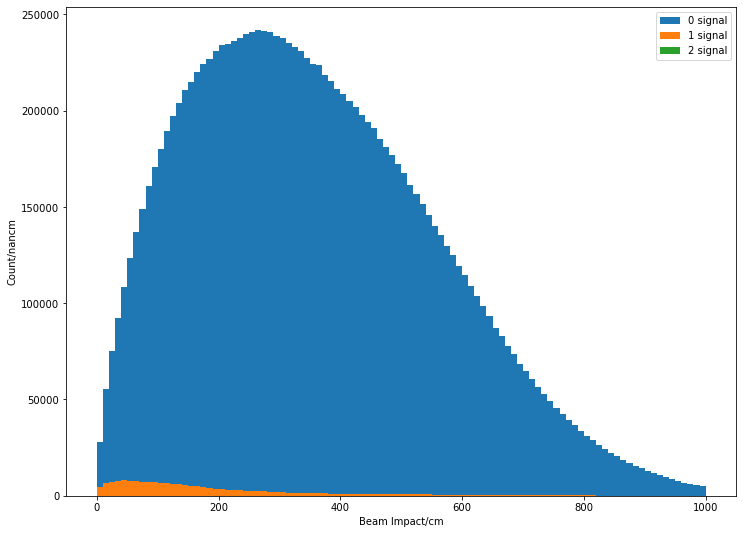

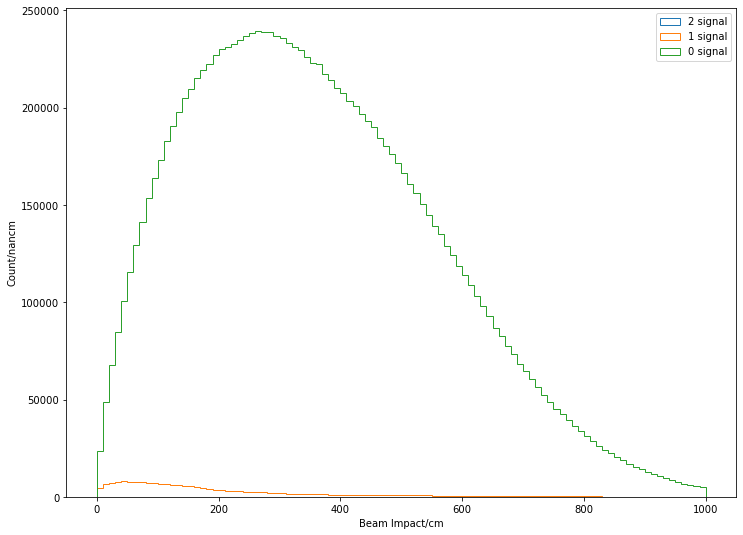

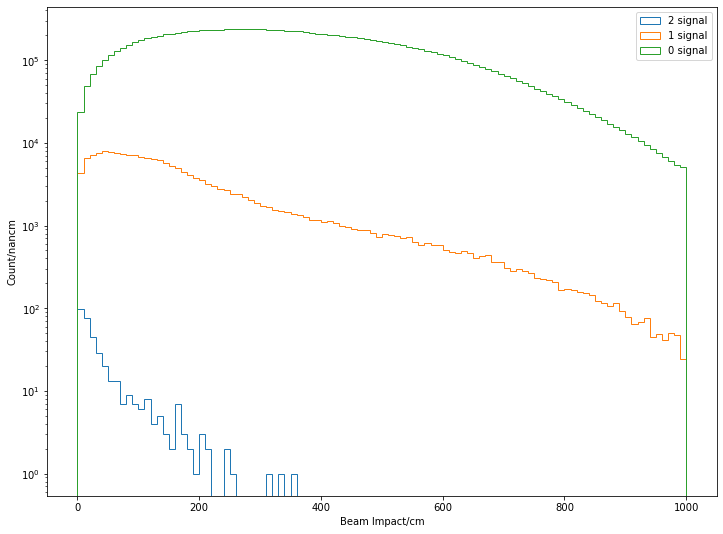

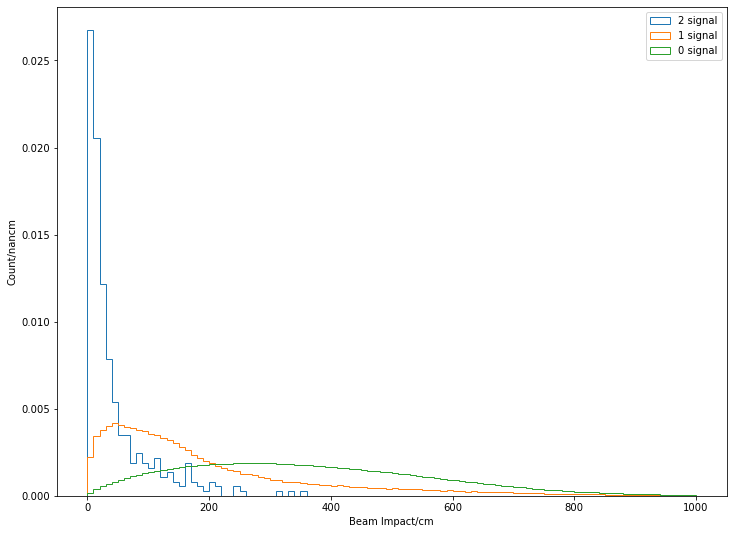

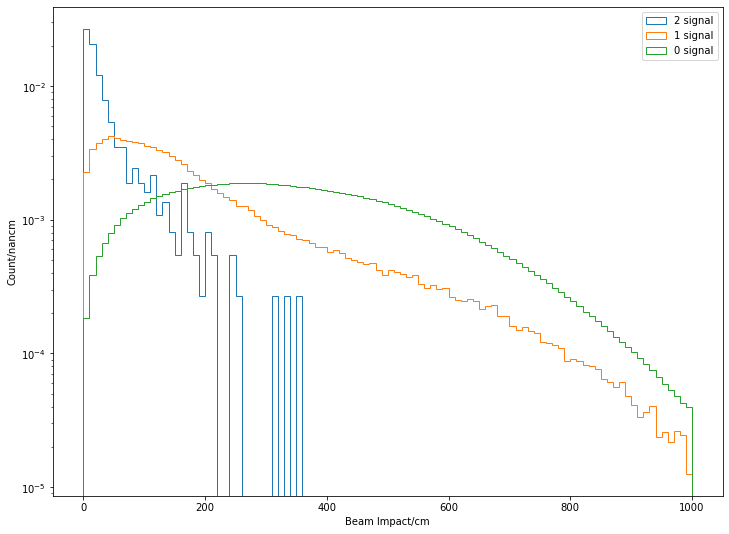

In [23]:
plot_pair_hists("beam impact", "cm", paired_beam_impact(evts, pair_coords), sig_count, range=[None, 1000], bins=100)

/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(


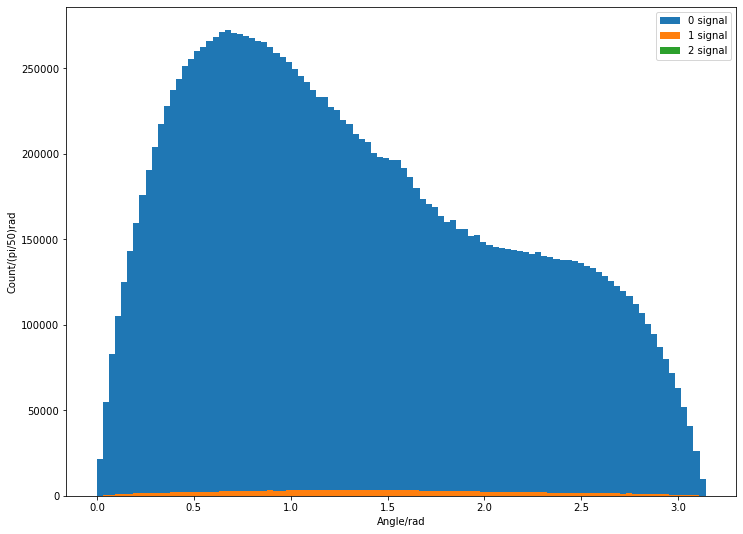

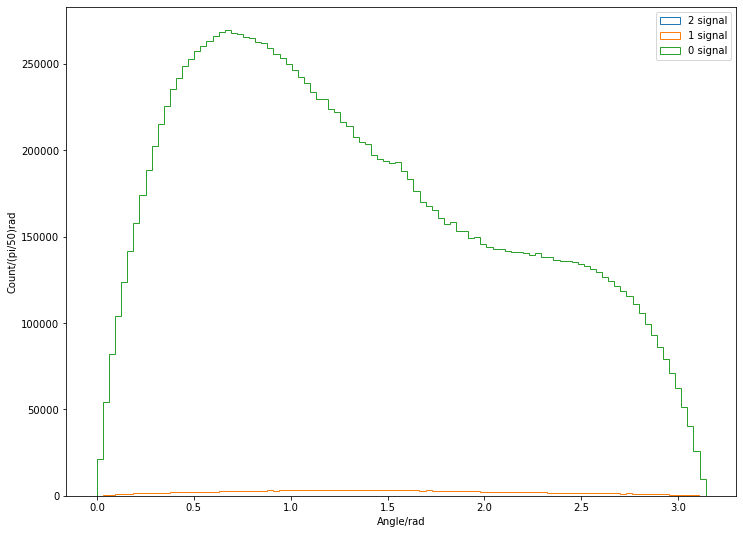

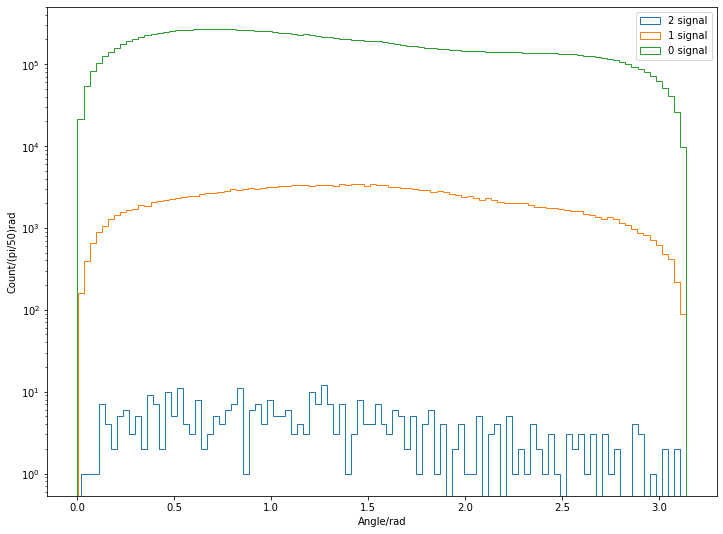

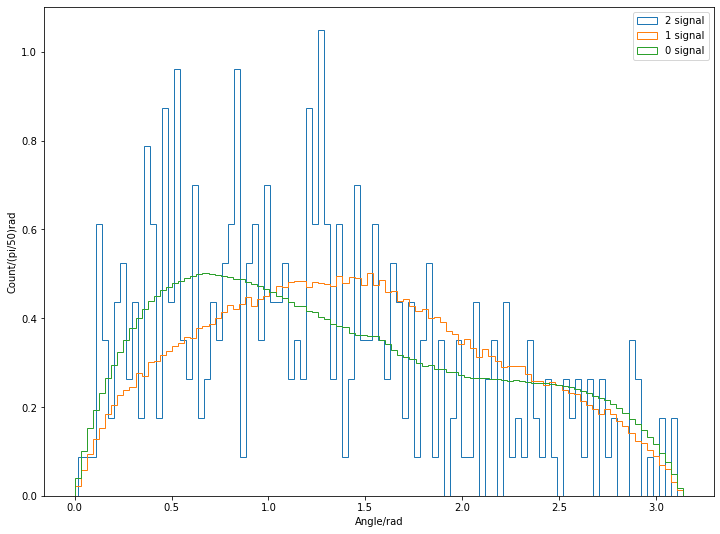

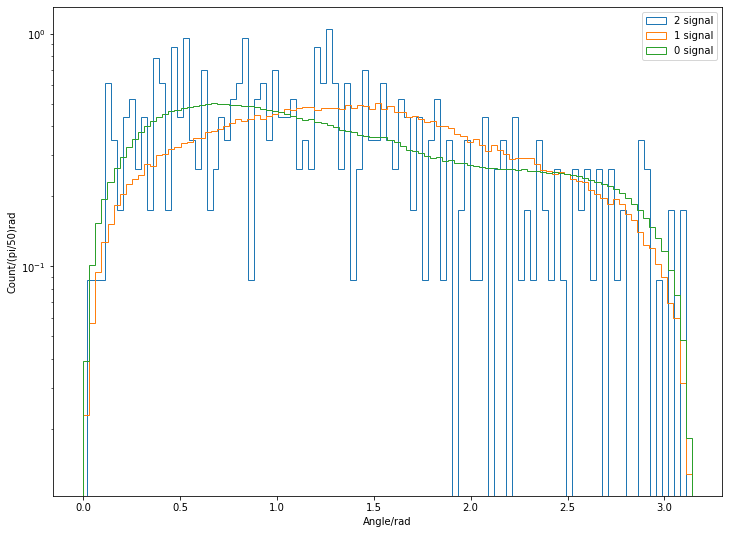

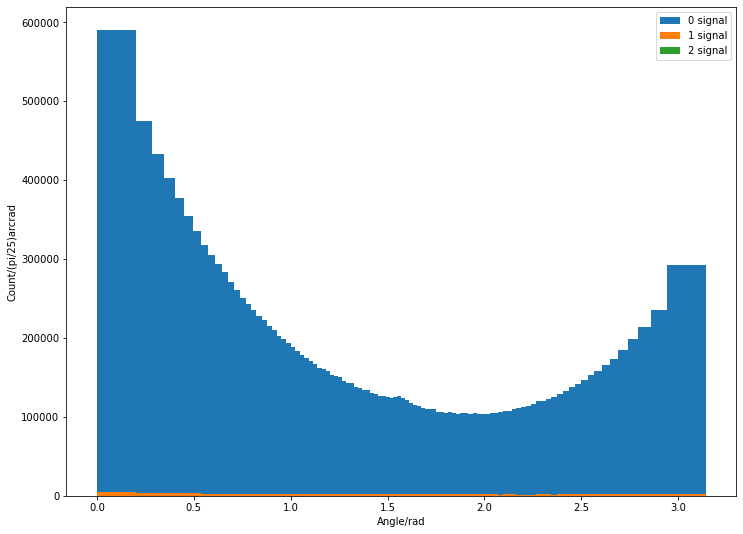

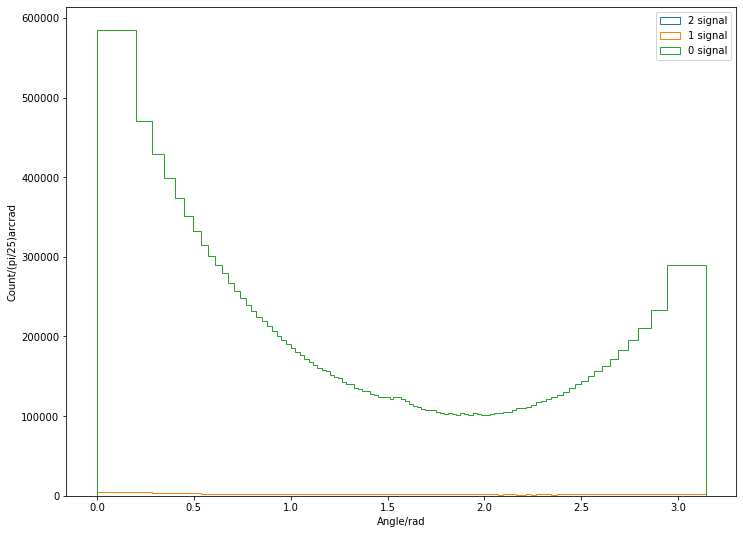

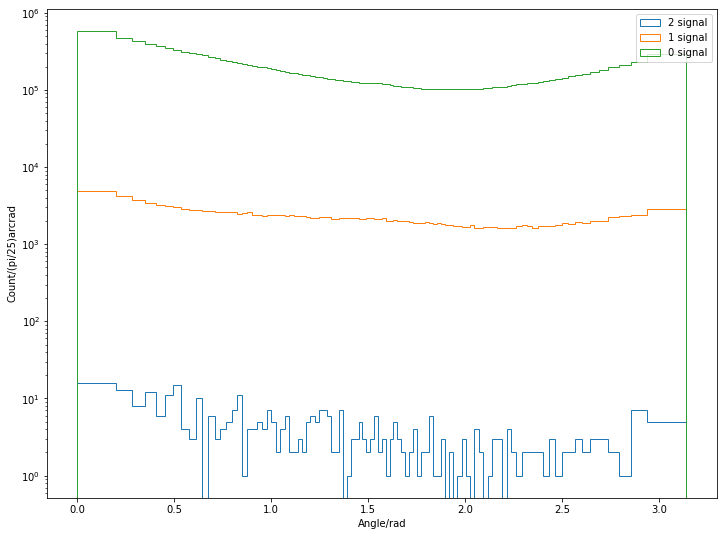

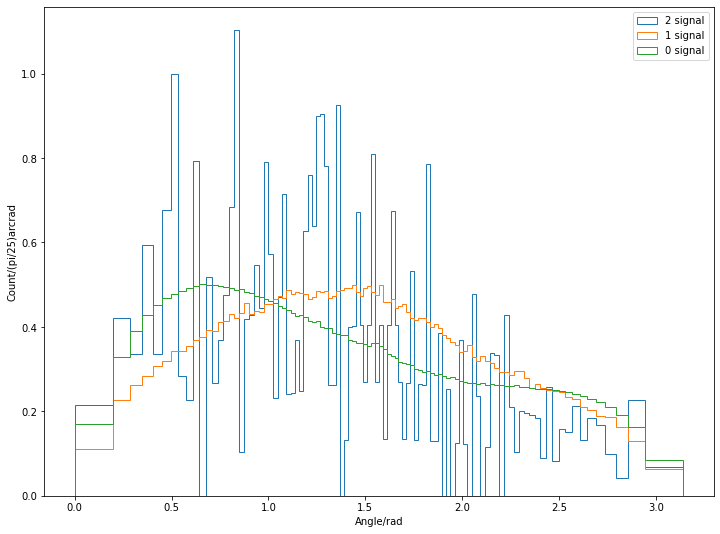

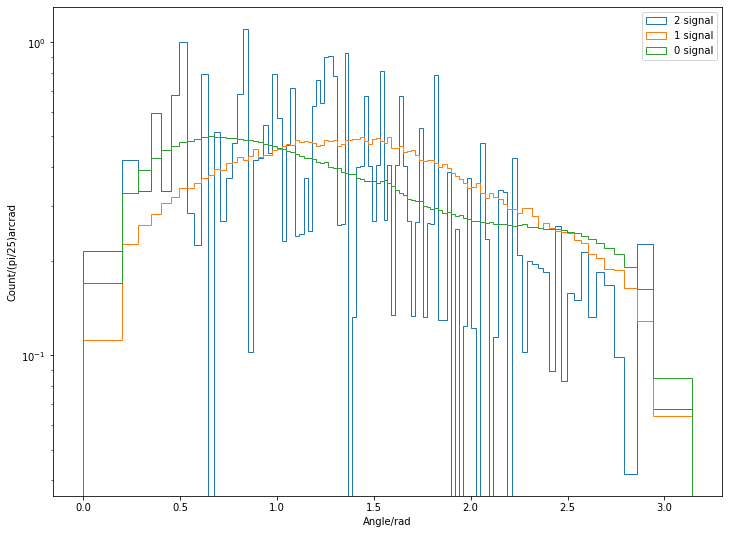

In [24]:
angles = paired_opening_angle(evts, pair_coords)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=100, bin_size="(pi/50)rad")

# Weight the bin widths to keep then with equal area on a sphere
# Area cover over angle dTheta is r sin(Theta) dTheta (with r=1)
# So we need constant sin(Theta) dTheta
# In the range Theta = [0, pi), we have
# \int^\pi_0 sin(\theta) d\theta = 2
# So for 100 bins, we need: sin(Theta) dTheta = 2/100 = 0.02
# \int^{\theta_new}_{\theta_old} sin(\theta) d\theta = 2/100
# So 0.2 = cons(theta_old) - cos(theta_new)
n_bins = 100
bins = np.zeros(n_bins+1)
for i in range(n_bins):
    bins[i+1] = np.arccos(np.max([np.cos(bins[i]) - 2/n_bins, -1]))


# TODO Need to fix the normailisation, currently it's not working!
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere", inc_norm=False)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere_norm", inc_norm=False, weights=ak.full_like(angles, 1/(0.04*np.pi)))

del angles

In [111]:
# new_pair_mask = np.logical_and(np.abs(paired_closest_approach(evts, pair_coords)) < 80, np.abs(paired_mass(evts, pair_coords)) < 1000)
new_pair_mask = np.logical_and(
    np.logical_and(np.logical_and(paired_beam_impact(evts, pair_coords) <= 45, paired_beam_impact(evts, pair_coords) > 1),
        np.logical_and(np.abs(paired_closest_approach(evts, pair_coords)) < 60, paired_separation(evts, pair_coords) < 200)),
    np.logical_and(paired_mass(evts, pair_coords) < 1000,
        np.logical_and(paired_energy(evts, pair_coords) > 5, paired_energy(evts, pair_coords) < 5000))
)

pair_coords = pair_coords[new_pair_mask]
sig_count = sig_count[new_pair_mask]

del new_pair_mask


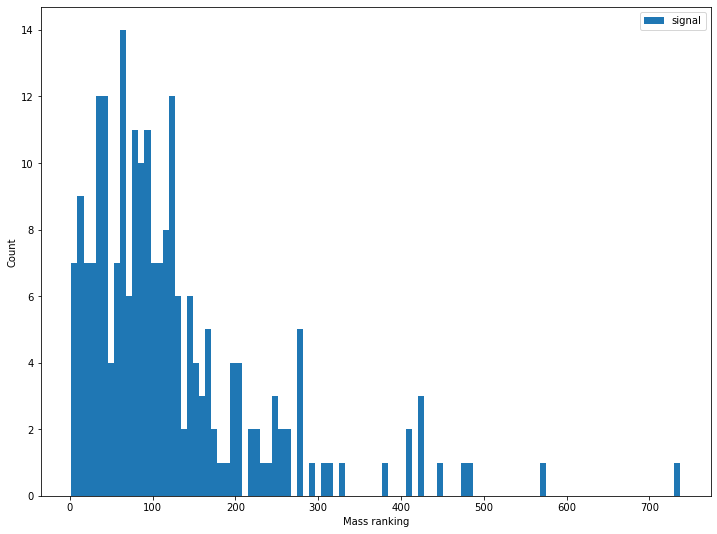

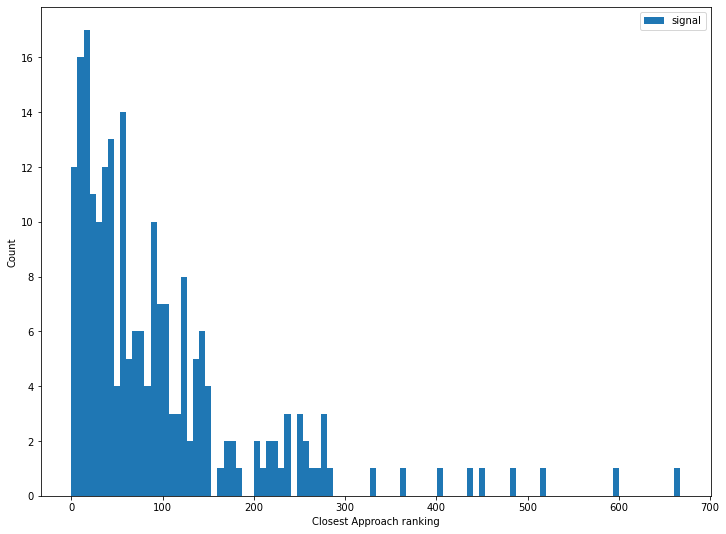

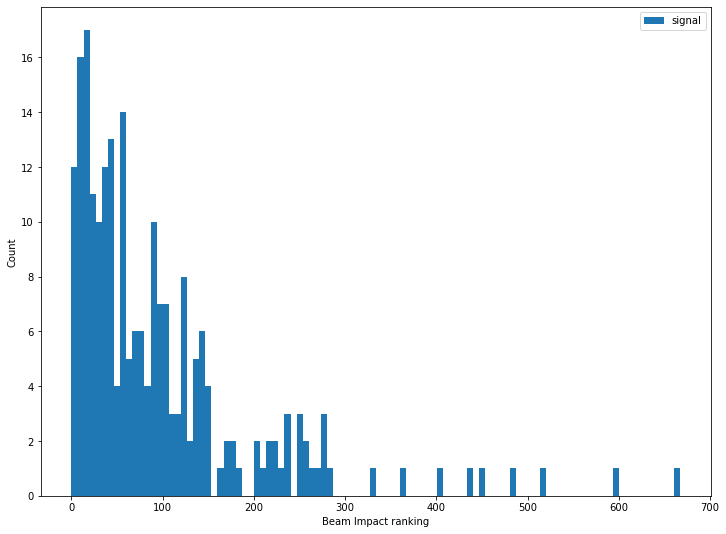

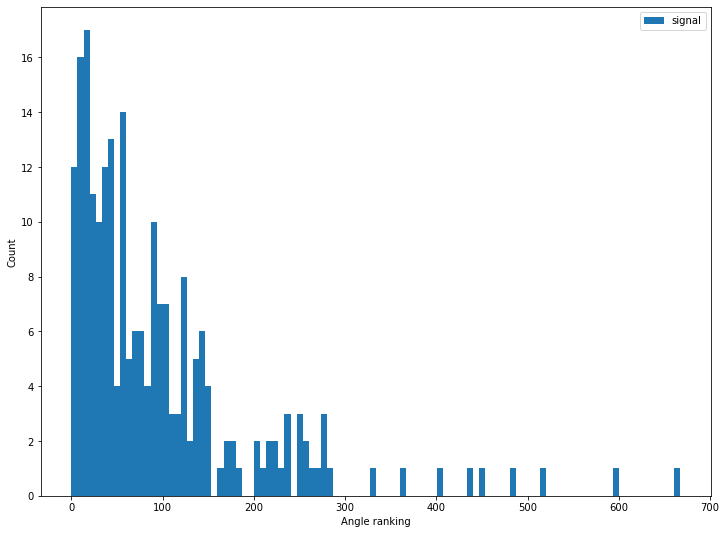

In [112]:
# This cell looks at prdering of PFOs in an event.
# We get the position of the "Truth" PFO in the event
truth_mask = sig_count == 2

mass_pos = ak.argsort(paired_mass(evts, pair_coords), ascending=True)[truth_mask]
closest_approach_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]
beam_impact_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]
angle_pos = ak.argsort(paired_closest_approach(evts, pair_coords), ascending=True)[truth_mask]

plot_rank_hist("Mass", ak.ravel(mass_pos), bins=100, y_scaling='linear')
plot_rank_hist("Closest approach", ak.ravel(closest_approach_pos), bins=100, y_scaling='linear')
plot_rank_hist("Beam impact", ak.ravel(beam_impact_pos), bins=100, y_scaling='linear')
plot_rank_hist("Angle", ak.ravel(angle_pos), bins=100, y_scaling='linear')

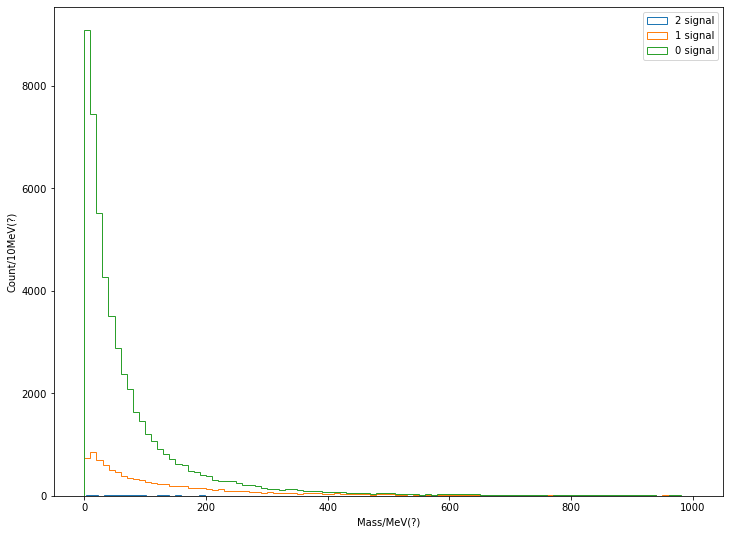

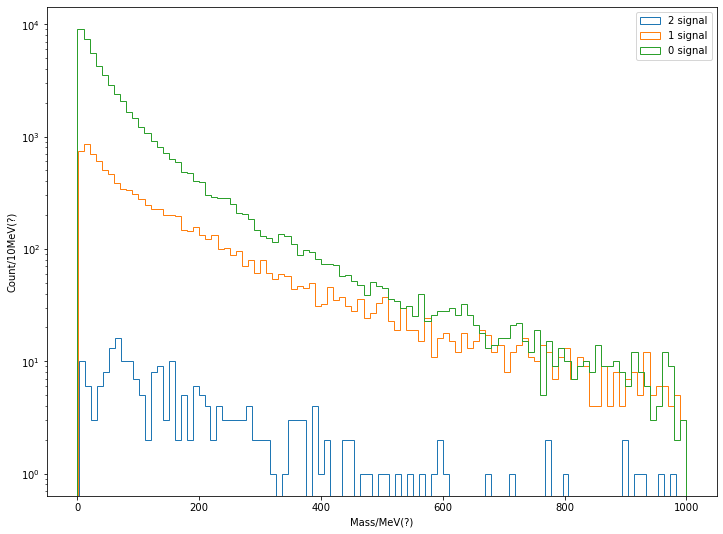

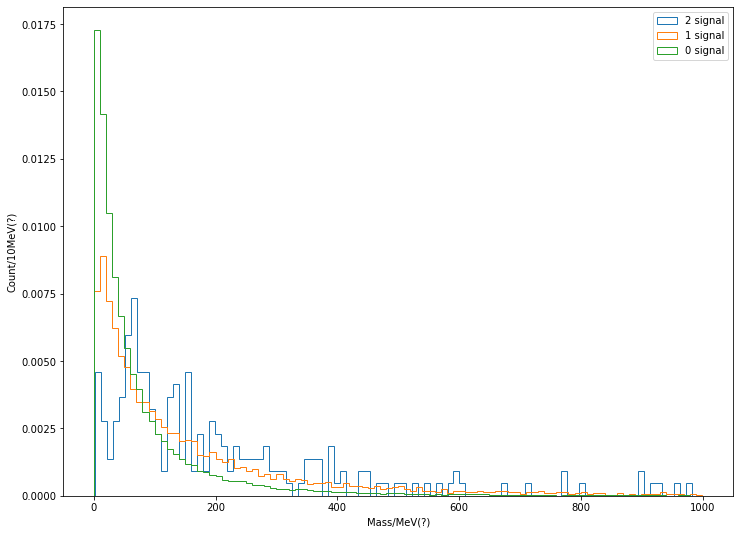

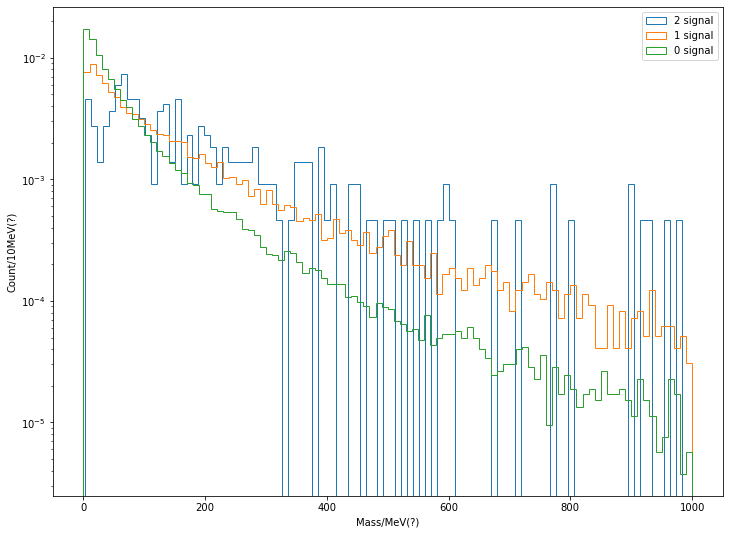

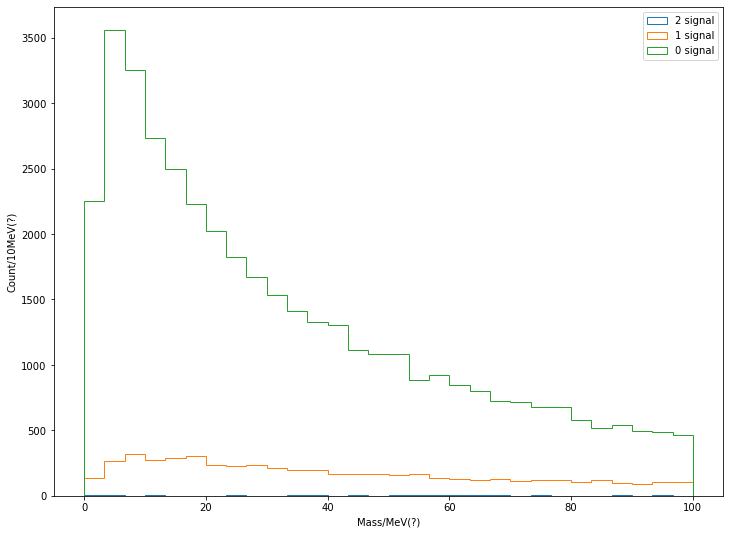

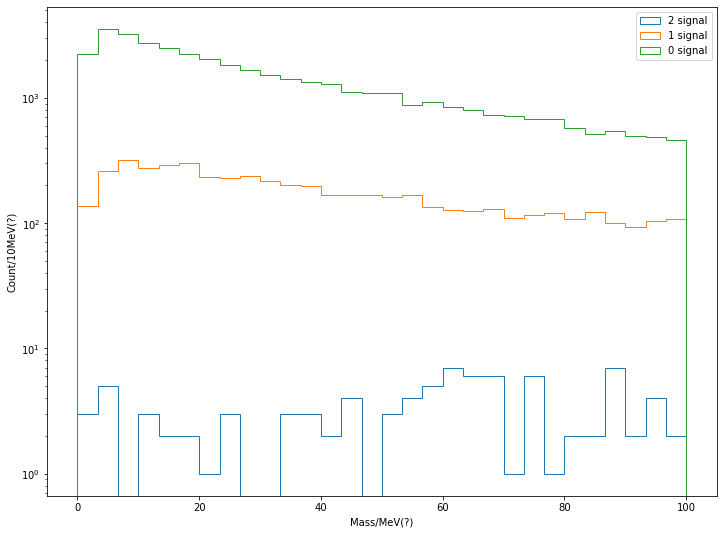

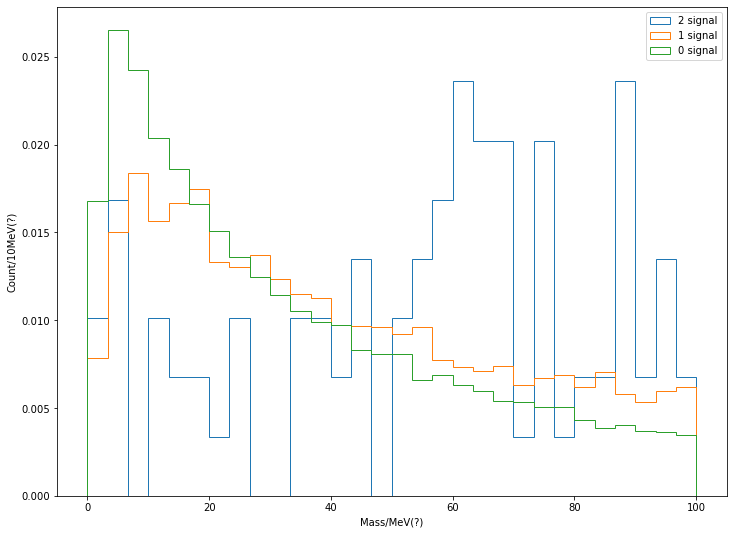

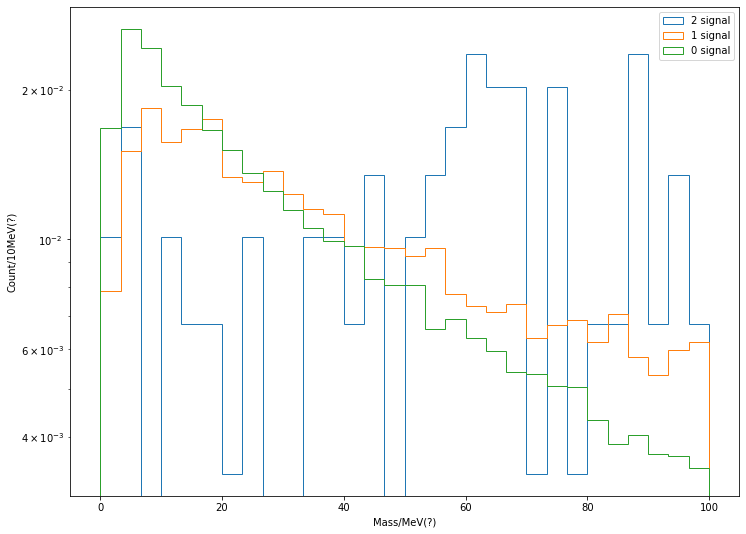

In [113]:
plot_pair_hists("mass", "MeV(?)", paired_mass(evts, pair_coords), sig_count, range=[None, 100], bins=[100, 30], inc_stacked=False)

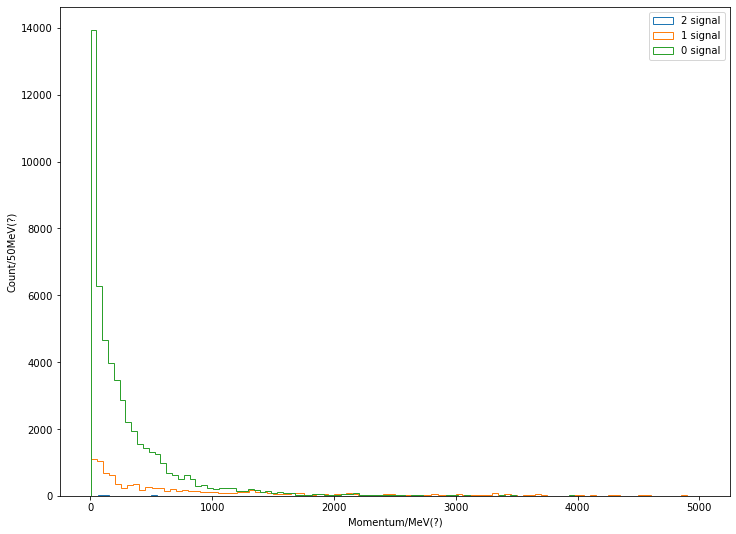

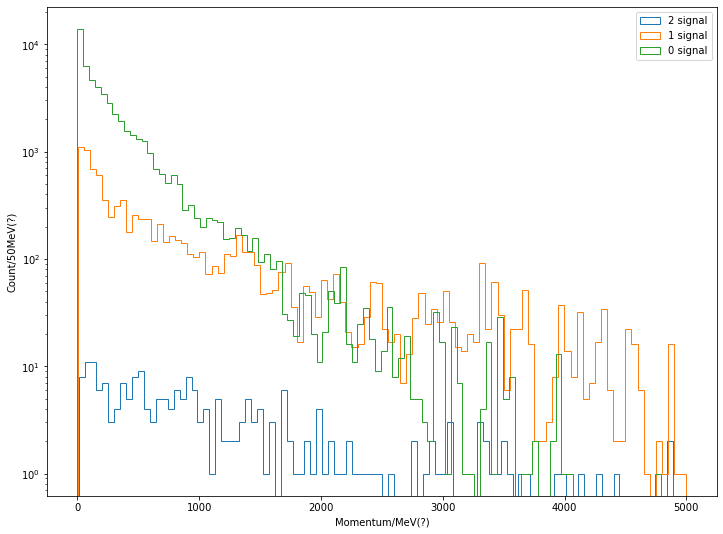

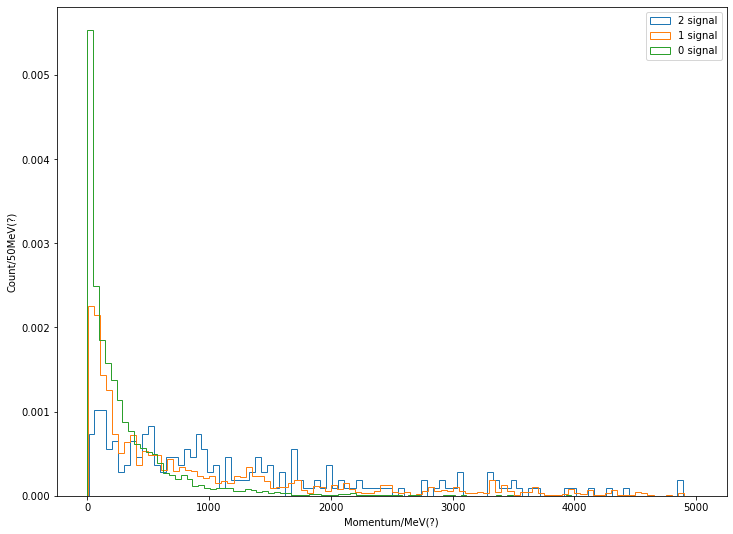

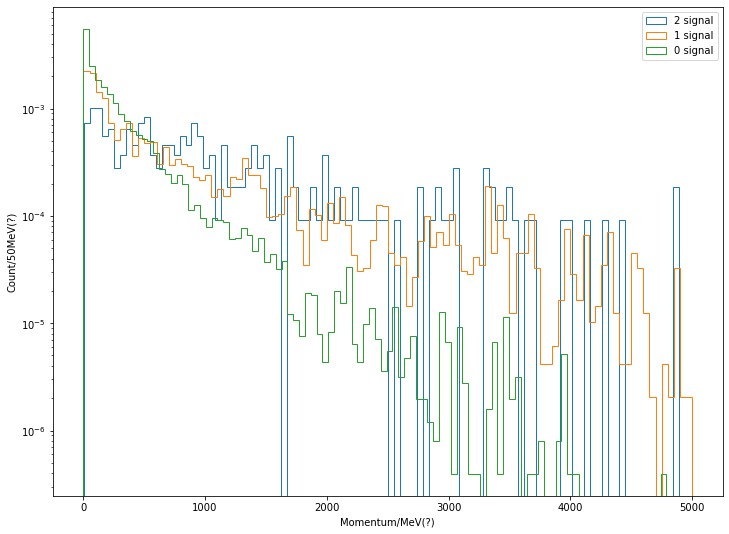

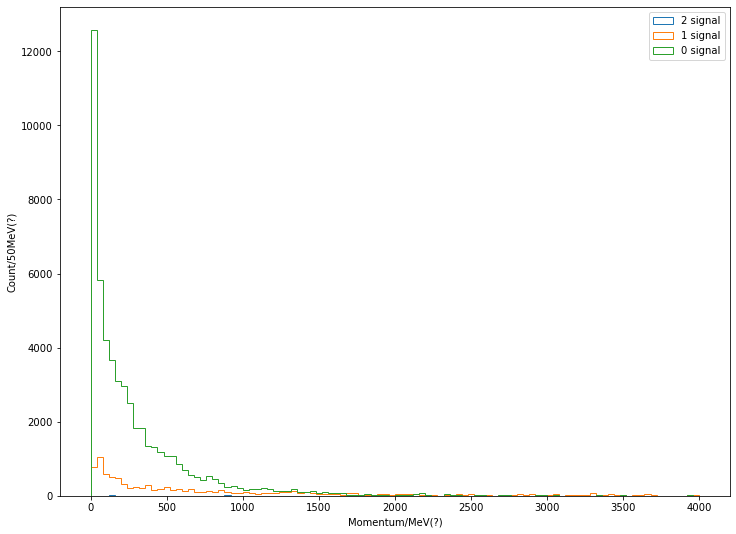

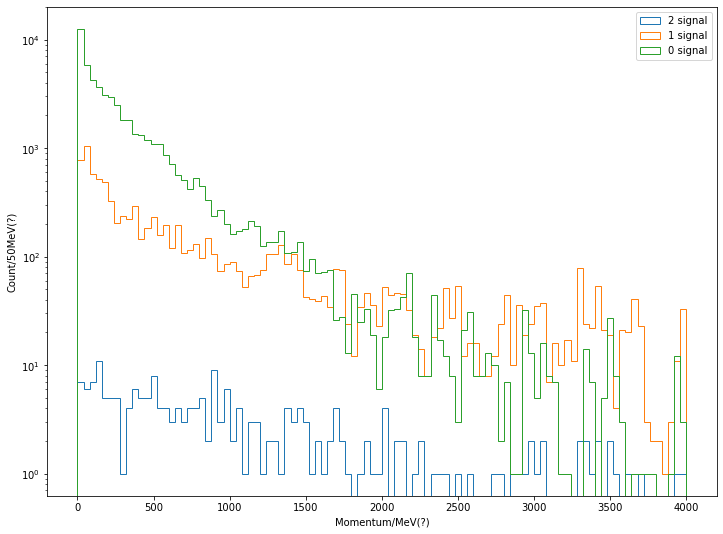

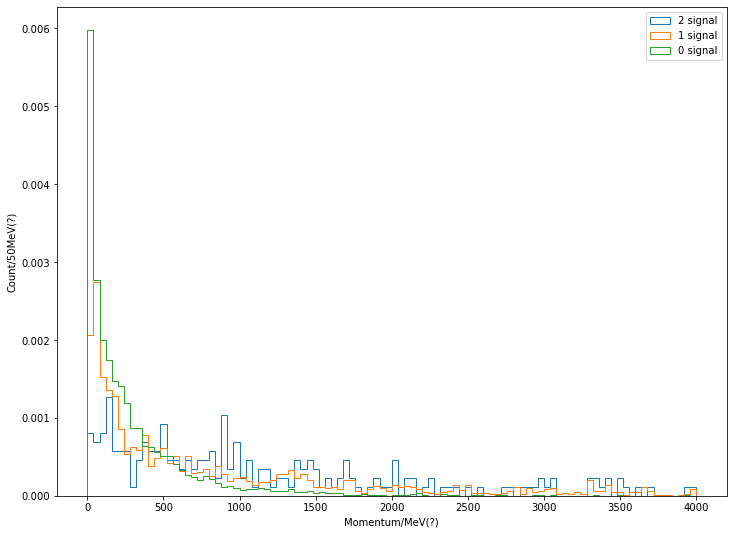

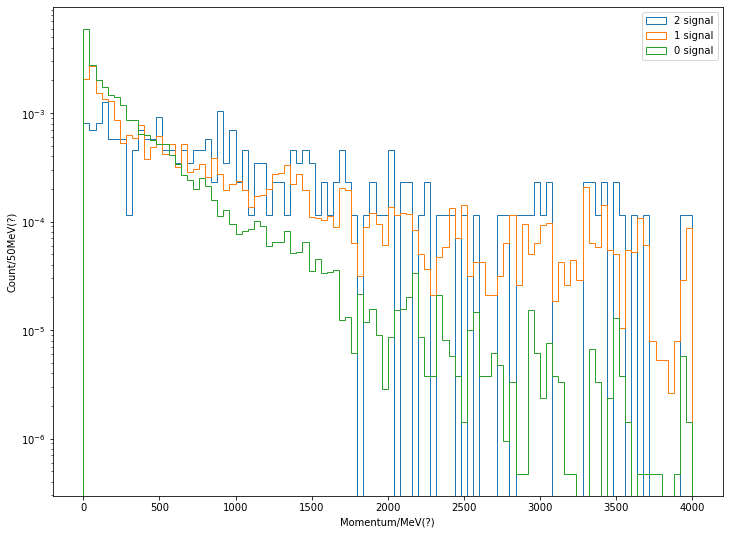

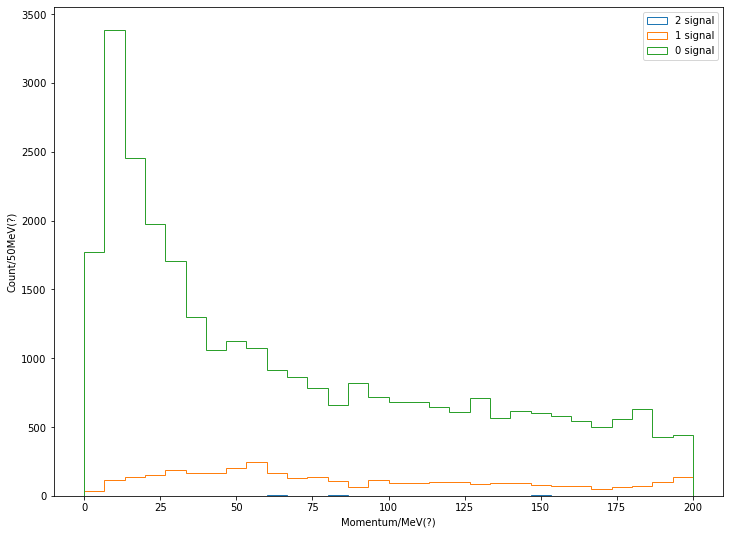

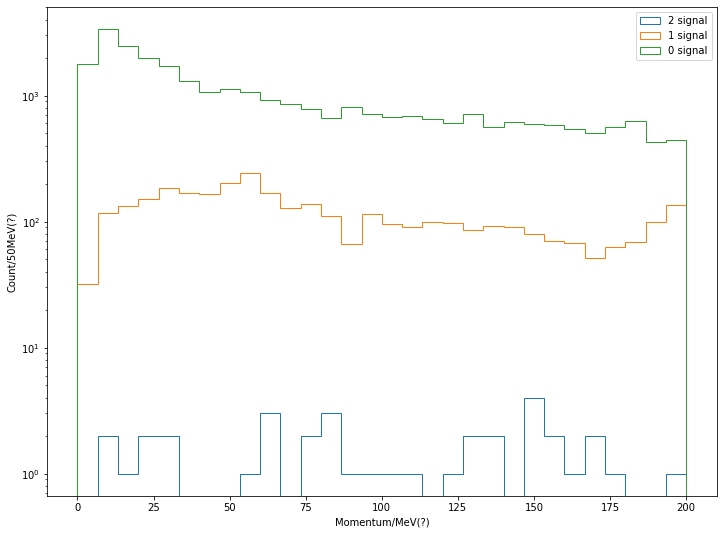

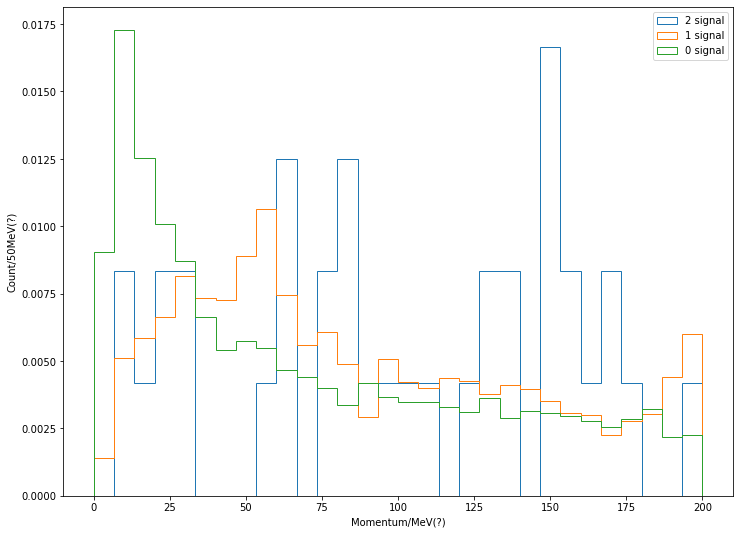

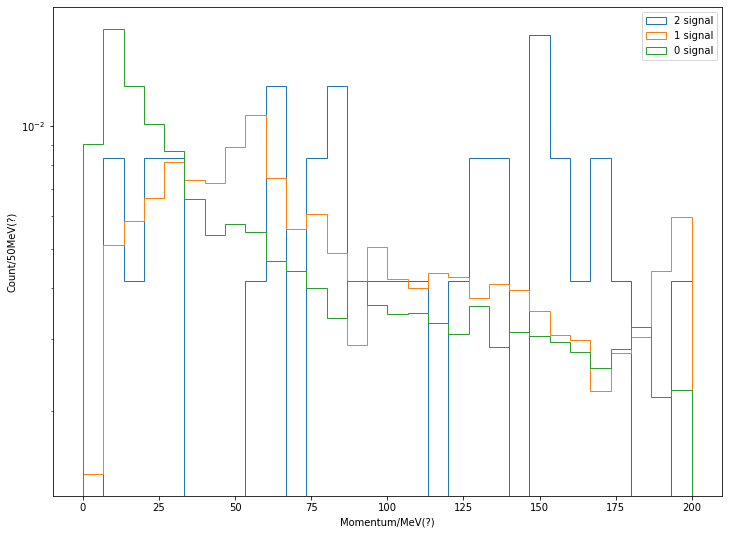

In [114]:
plot_pair_hists("momentum", "MeV(?)", vector.magnitude(paired_momentum(evts, pair_coords)), sig_count, range=[None, 4000, 200], bins=[100,100,30], inc_stacked=False)

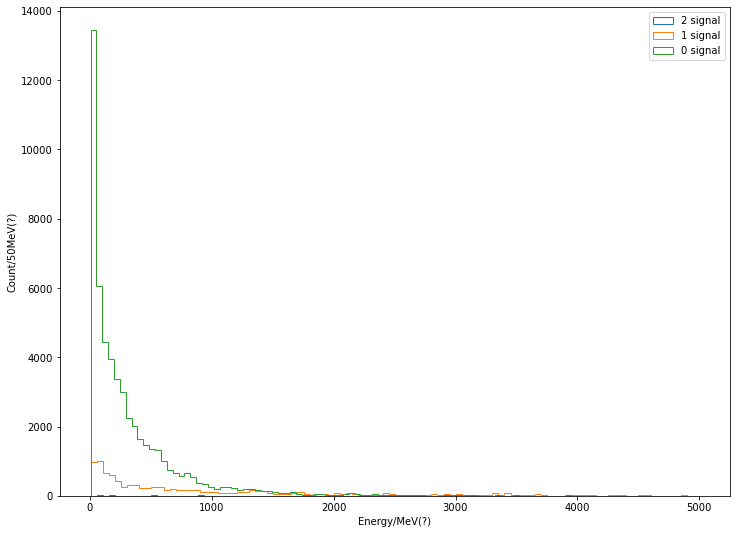

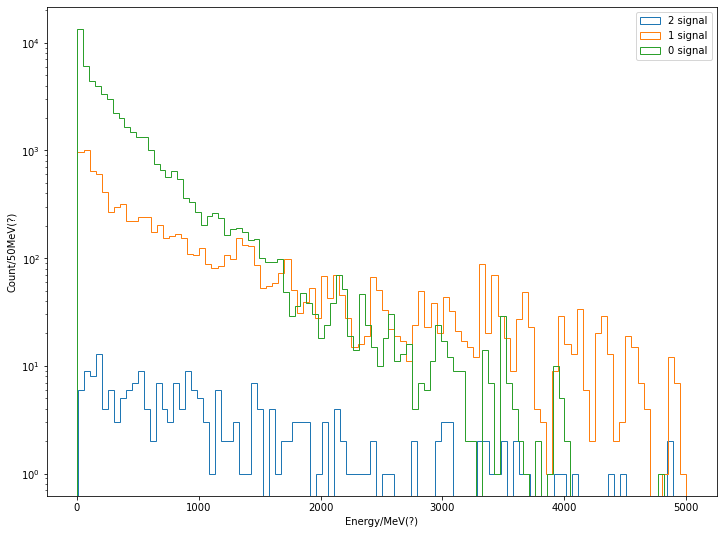

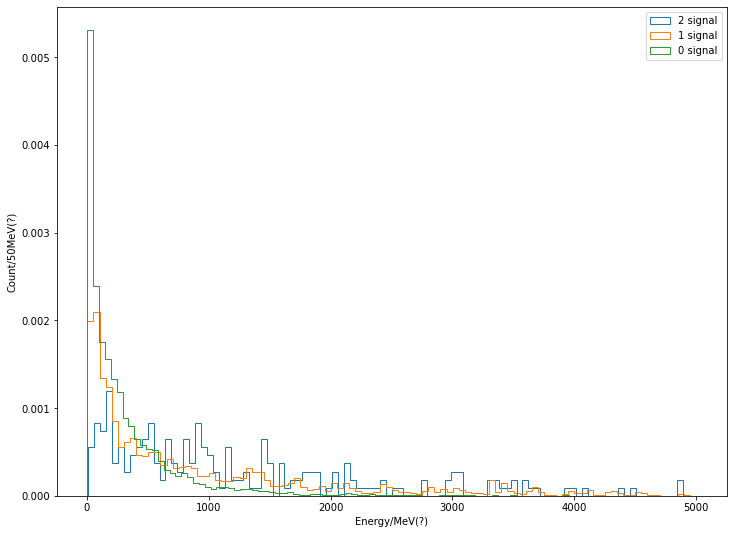

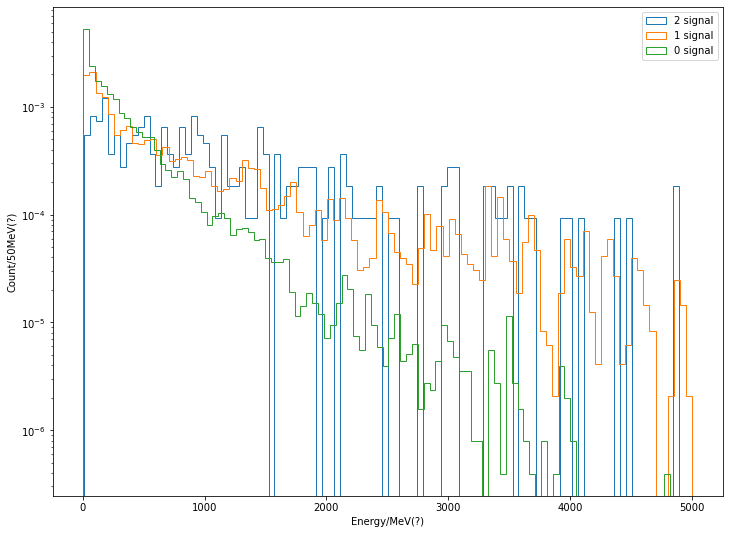

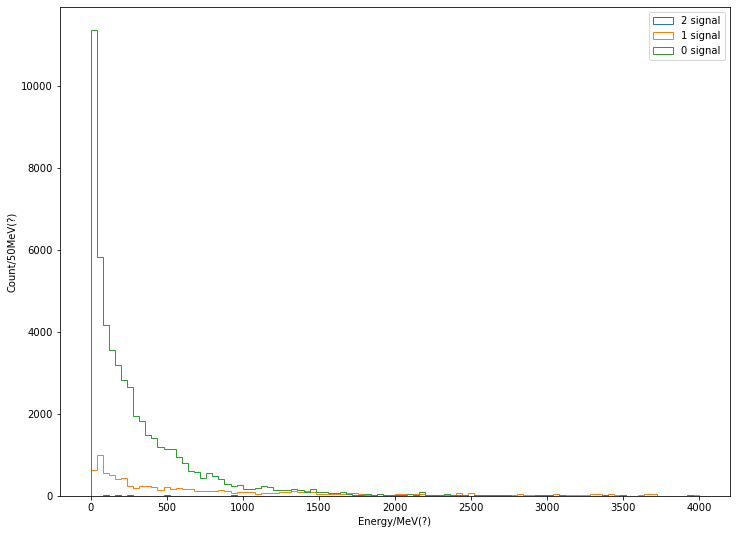

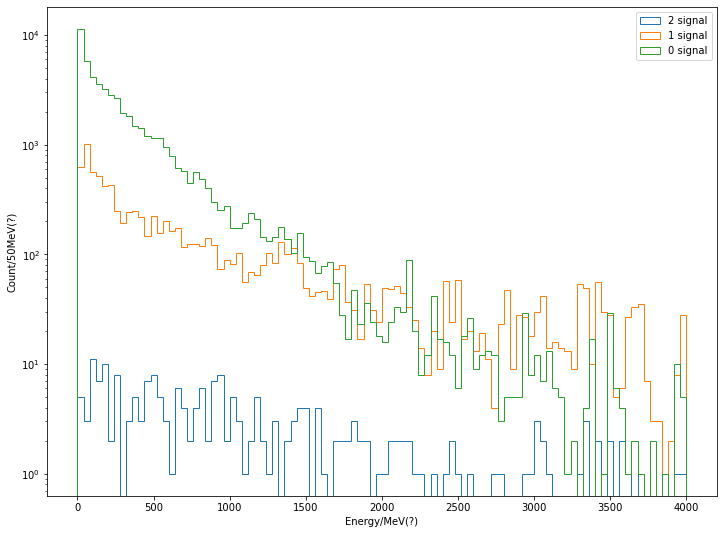

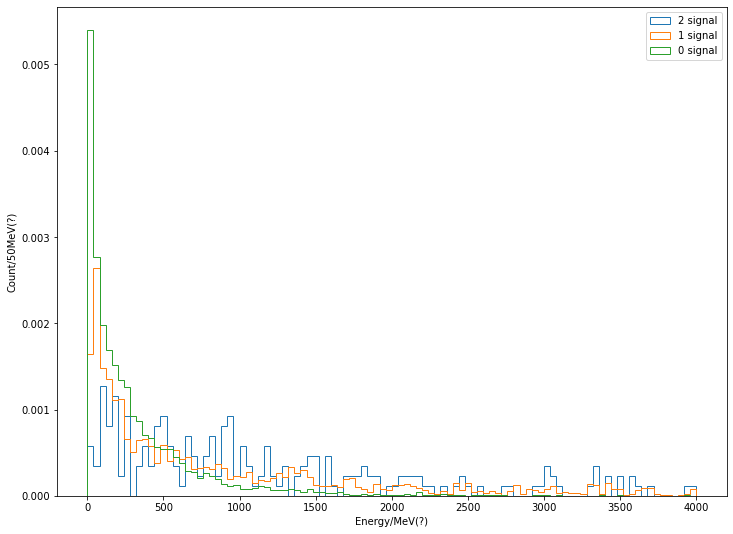

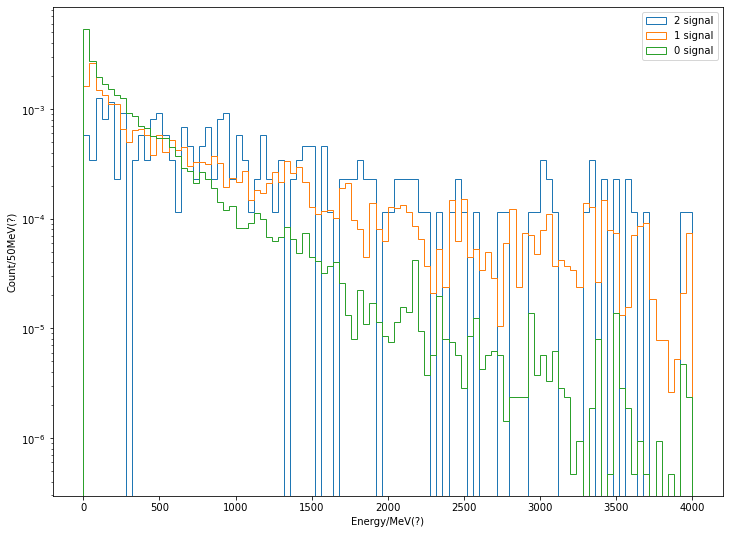

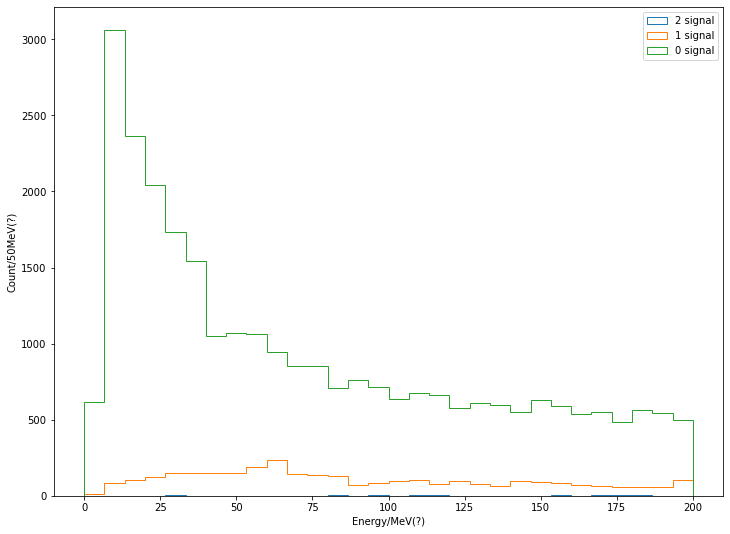

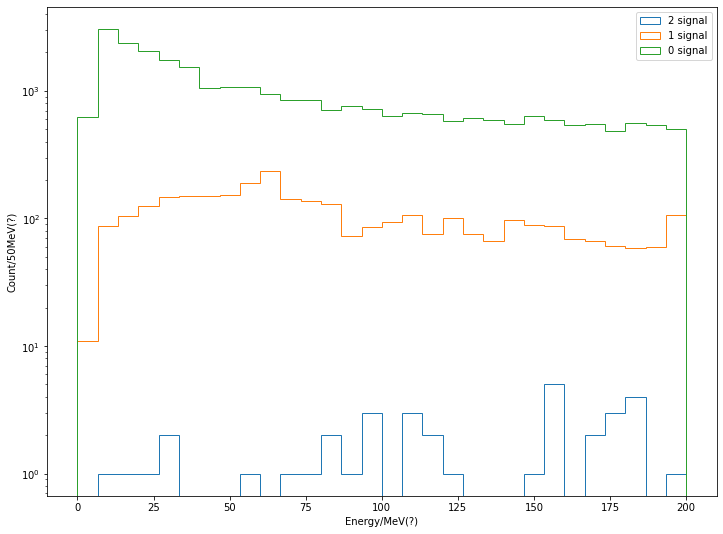

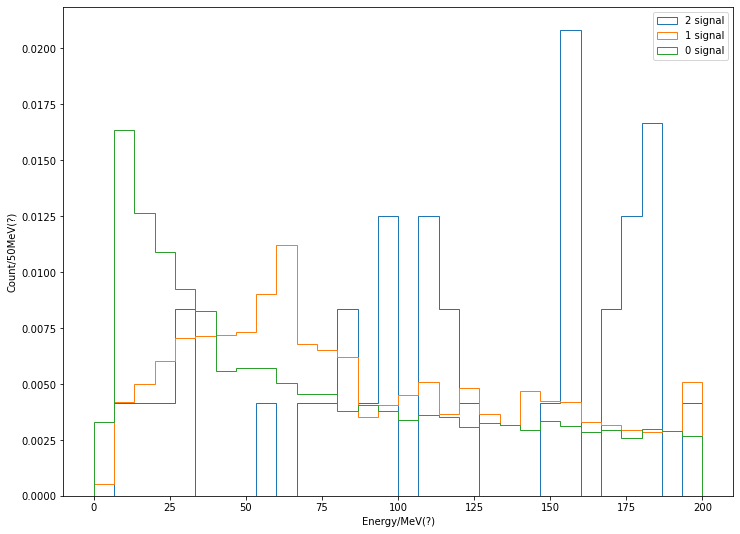

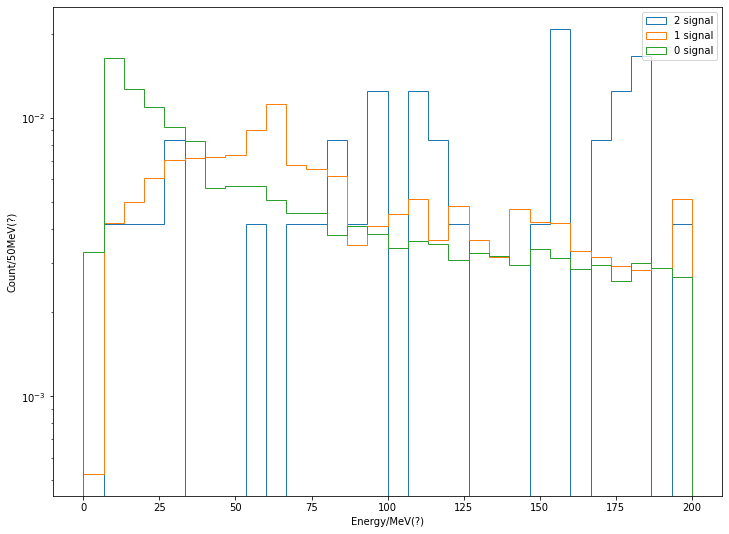

In [115]:
plot_pair_hists("energy", "MeV(?)", paired_energy(evts, pair_coords), sig_count, range=[None, 4000, 200], bins=[100,100,30], inc_stacked=False)

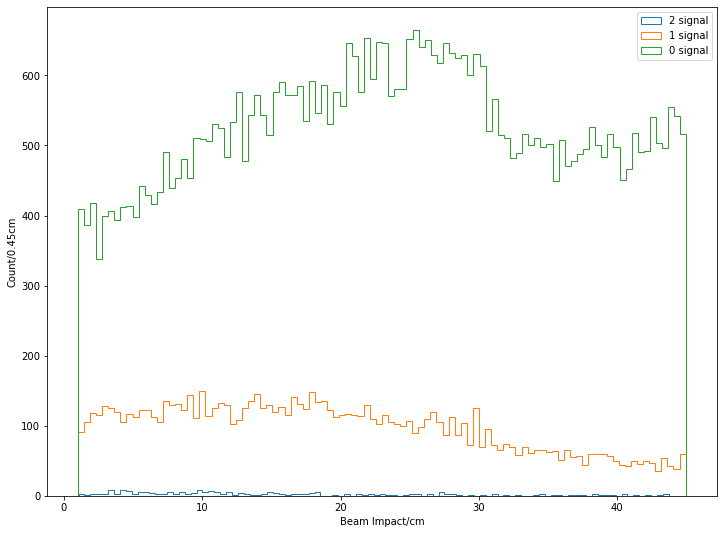

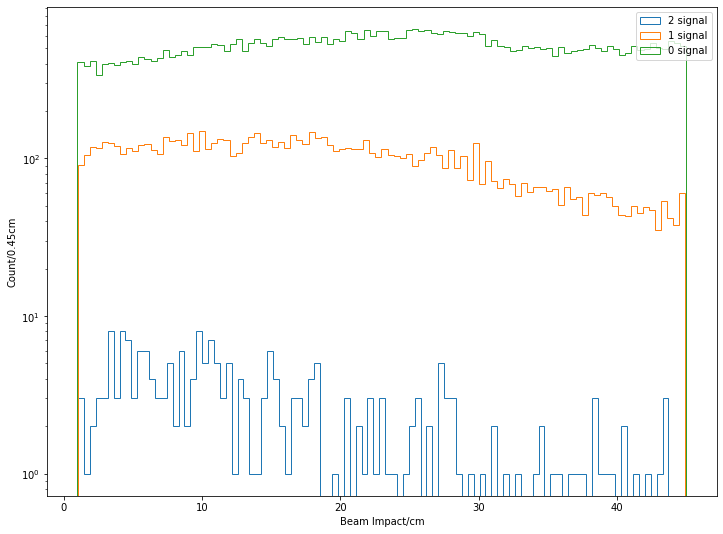

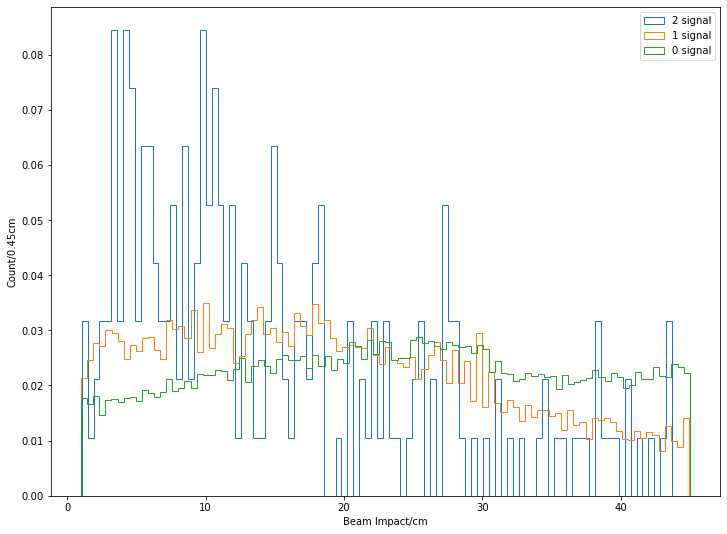

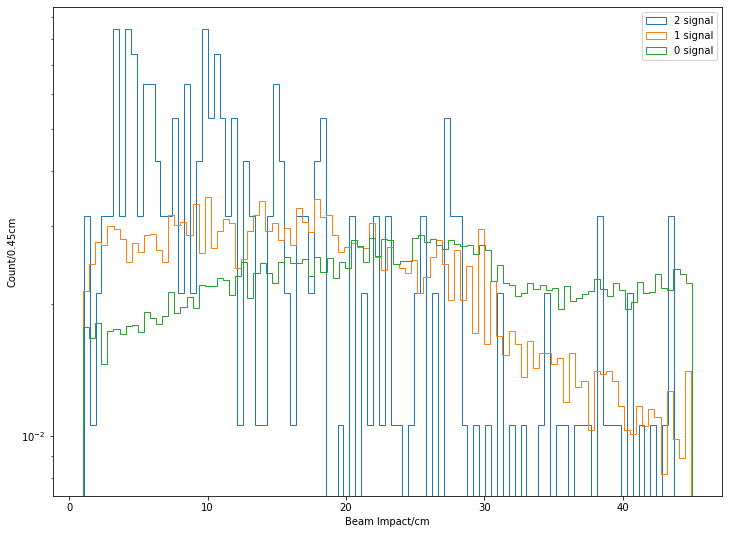

In [116]:
plot_pair_hists("beam impact", "cm", paired_beam_impact(evts, pair_coords), sig_count, bins=100, inc_stacked=False)

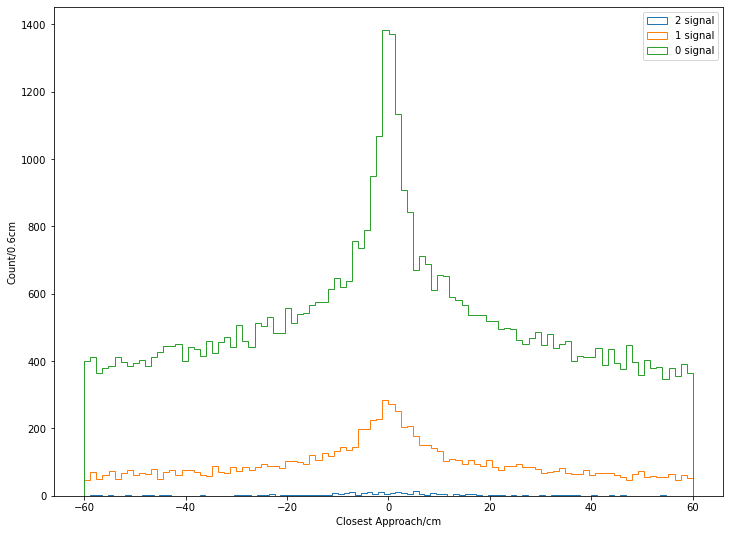

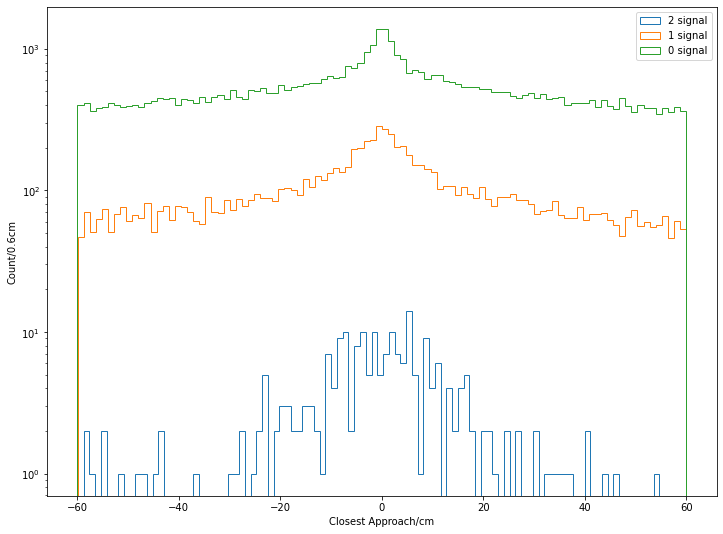

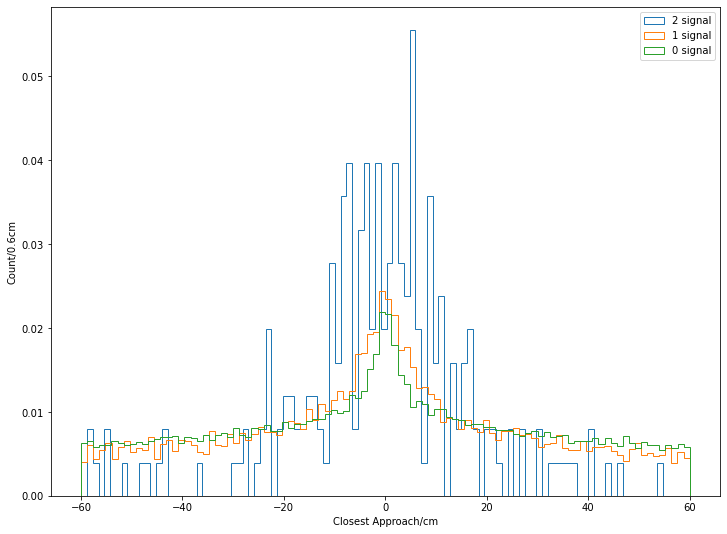

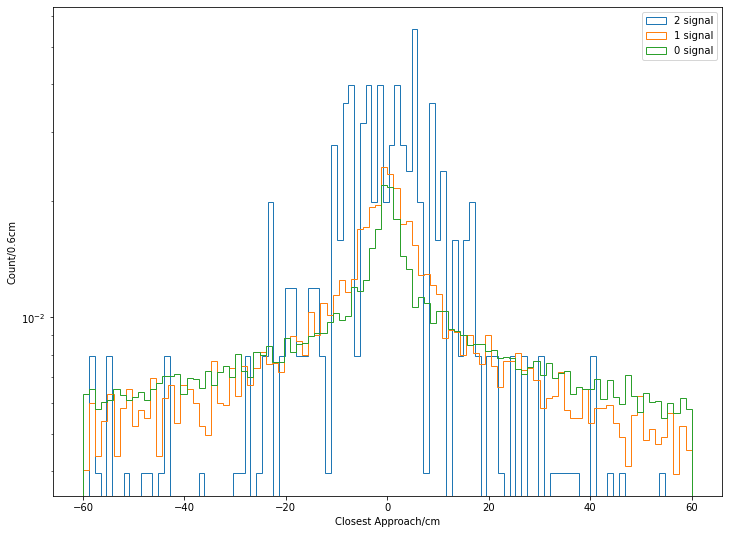

In [117]:
plot_pair_hists("closest approach", "cm", paired_closest_approach(evts, pair_coords), sig_count, bins=100, inc_stacked=False)

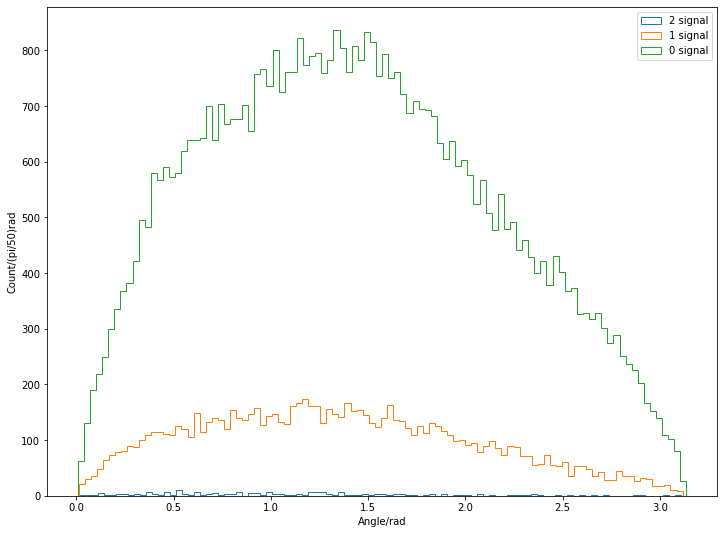

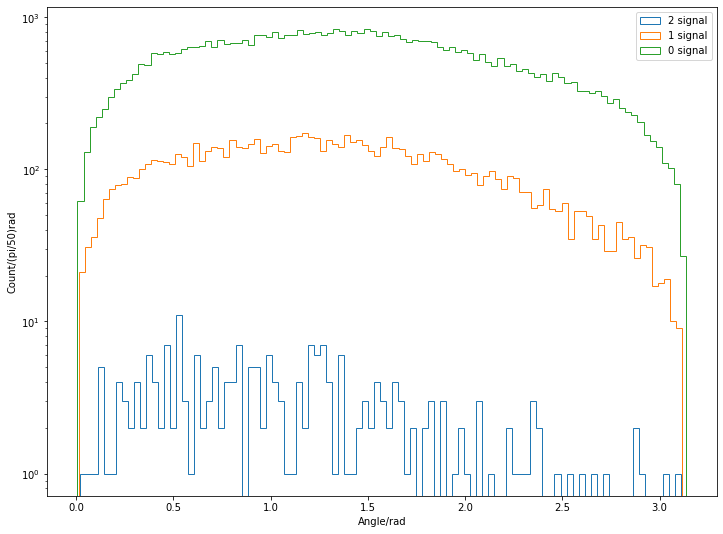

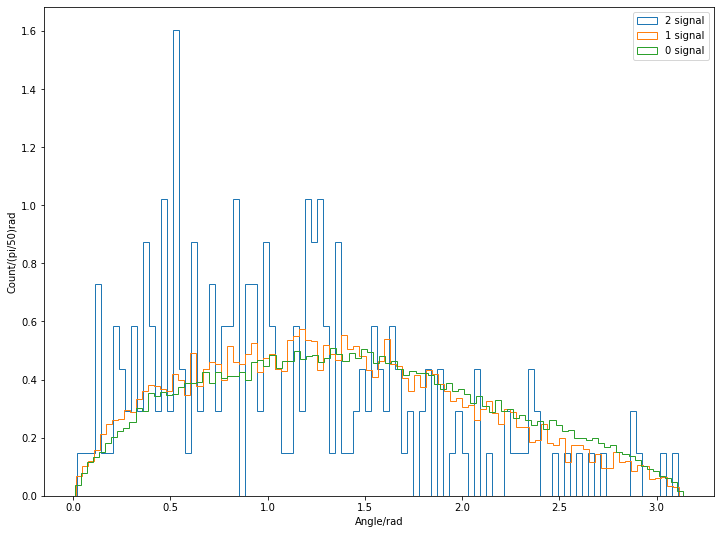

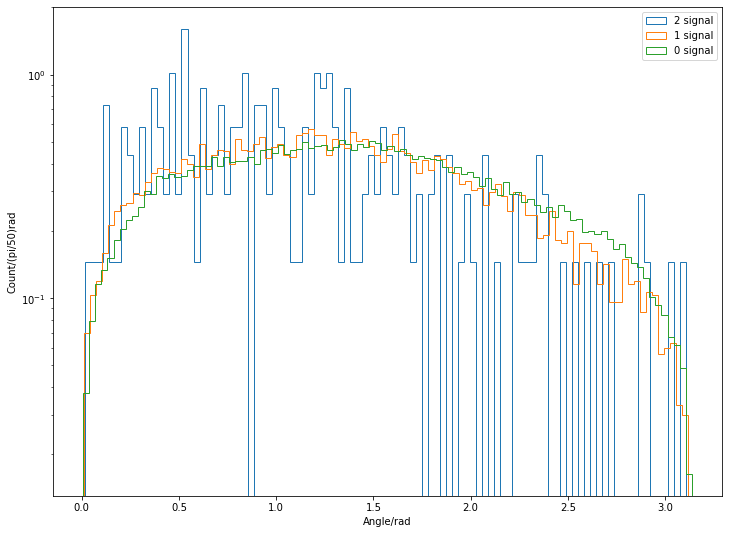

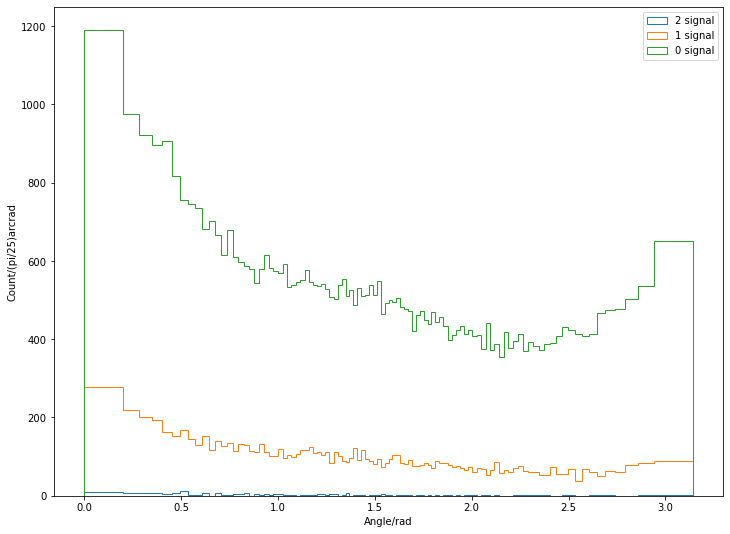

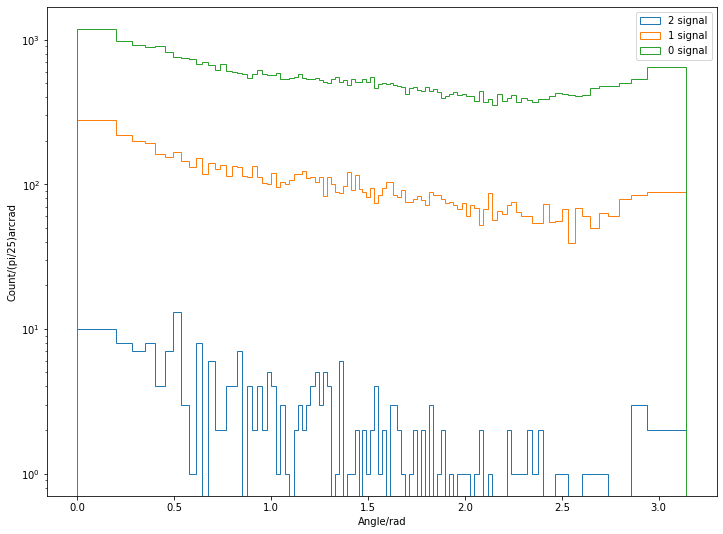

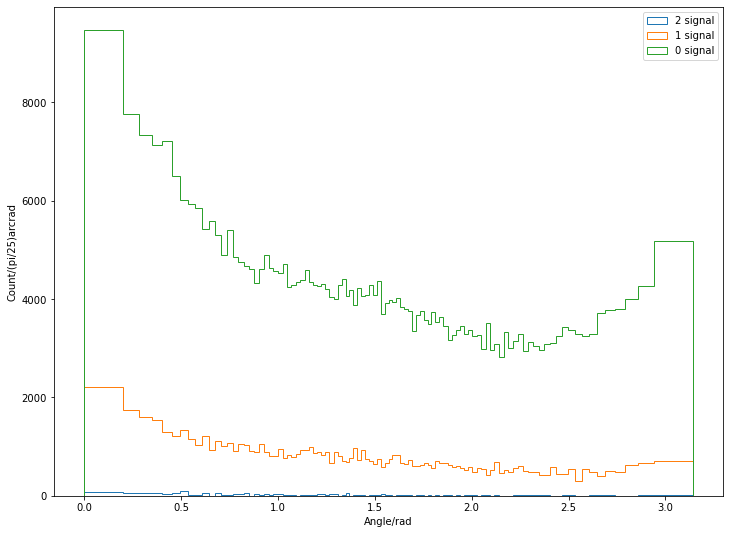

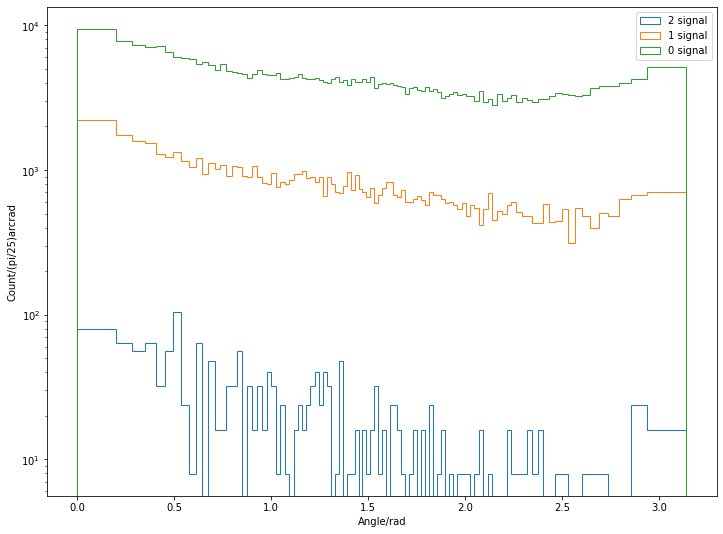

In [118]:
angles = paired_opening_angle(evts, pair_coords)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=100, bin_size="(pi/50)rad", inc_stacked=False)

# Weight the bin widths to keep then with equal area on a sphere
# Area cover over angle dTheta is r sin(Theta) dTheta (with r=1)
# So we need constant sin(Theta) dTheta
# In the range Theta = [0, pi), we have
# \int^\pi_0 sin(\theta) d\theta = 2
# So for 100 bins, we need: sin(Theta) dTheta = 2/100 = 0.02
# \int^{\theta_new}_{\theta_old} sin(\theta) d\theta = 2/100
# So 0.2 = cons(theta_old) - cos(theta_new)
n_bins = 100
bins = np.zeros(n_bins+1)
for i in range(n_bins):
    bins[i+1] = np.arccos(np.max([np.cos(bins[i]) - 2/n_bins, -1]))


# TODO Need to fix the normailisation, currently it's not working!
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere", inc_norm=False, inc_stacked=False)
plot_pair_hists("angle", "rad", angles, sig_count, range=None, bins=bins, bin_size="(pi/25)arcrad", unique_save_id = "_sphere_norm", inc_norm=False, inc_stacked=False, weights=ak.full_like(angles, 1/(0.04*np.pi)))

del angles

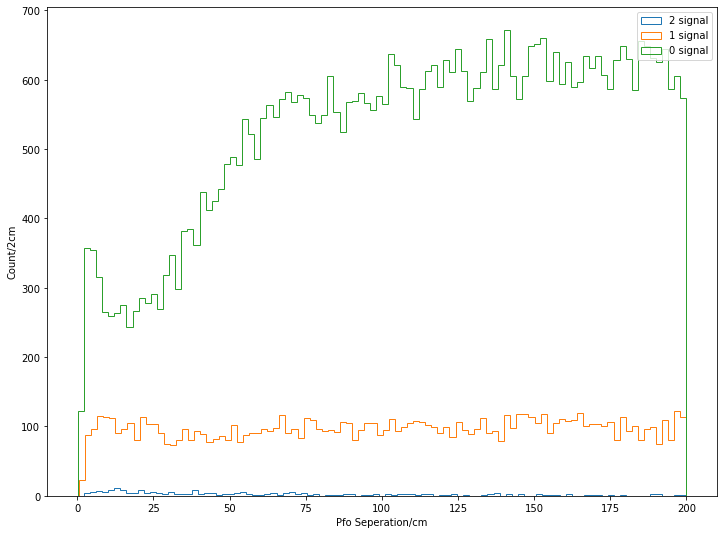

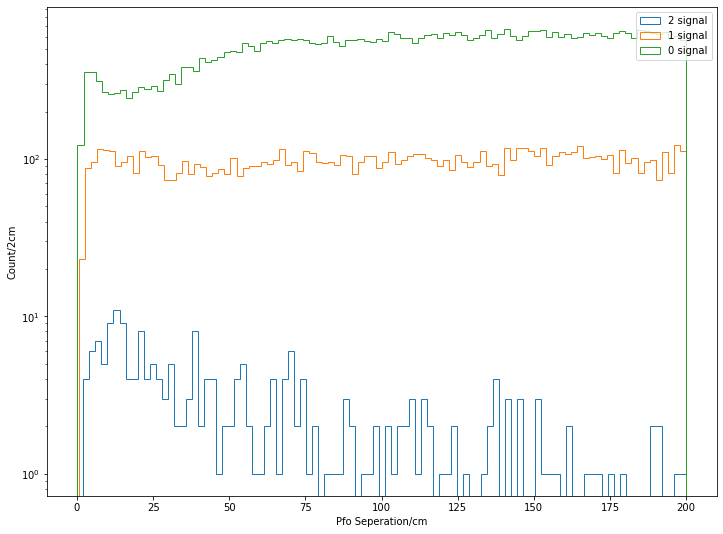

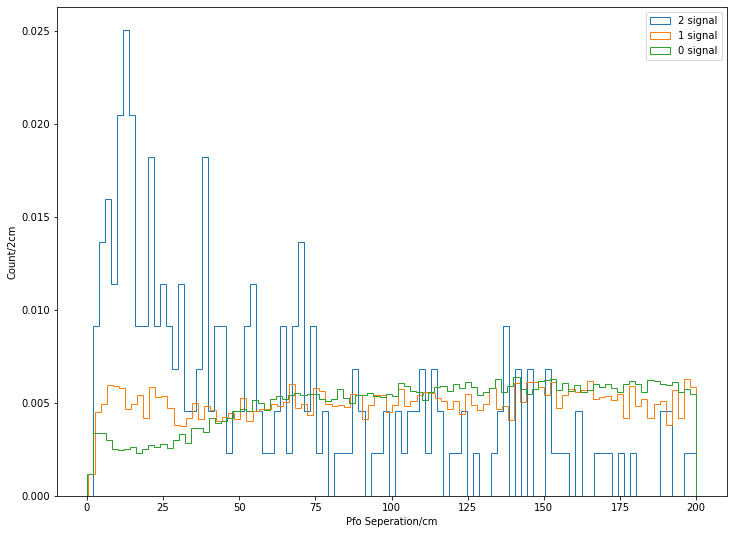

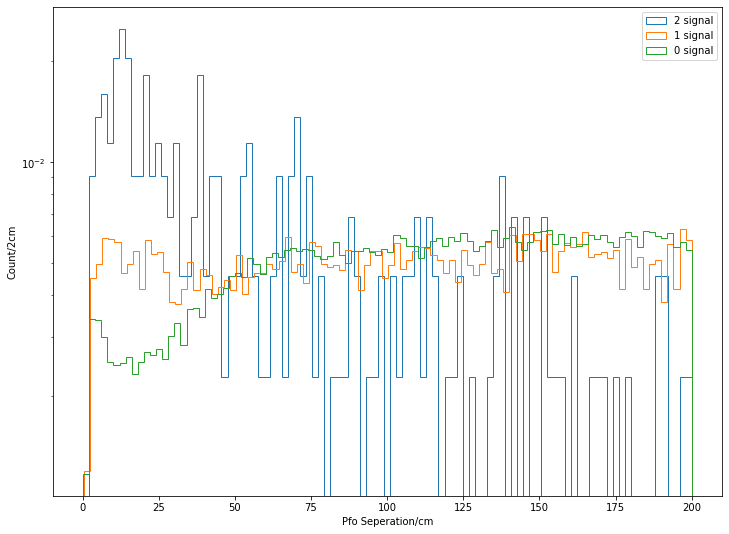

In [119]:
plot_pair_hists("PFO seperation", "cm", paired_separation(evts, pair_coords), sig_count, bins=100, inc_stacked=False)

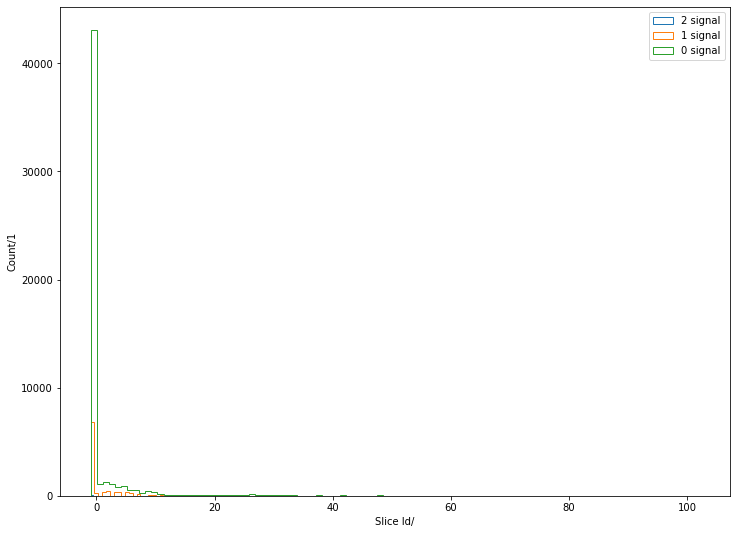

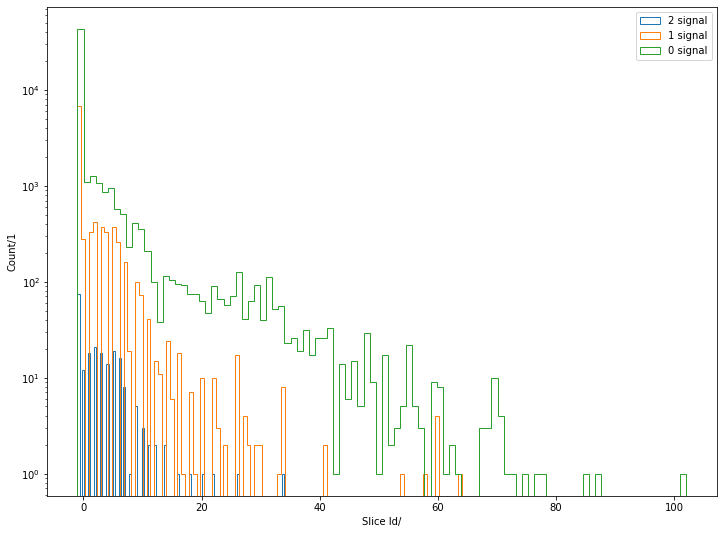

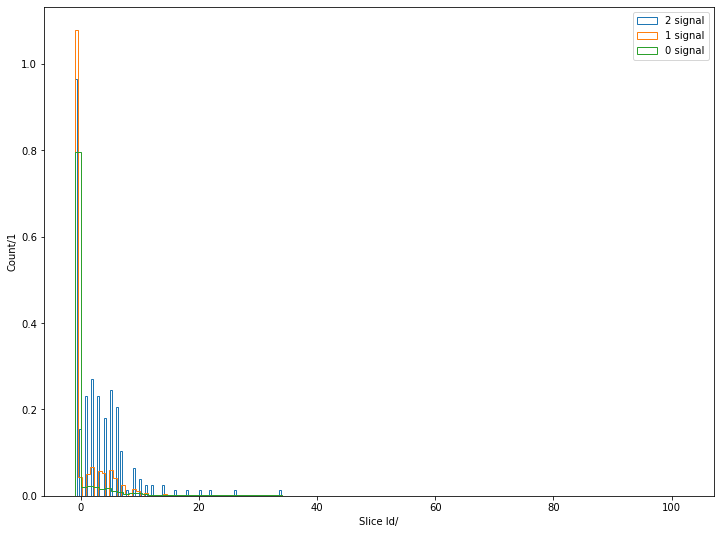

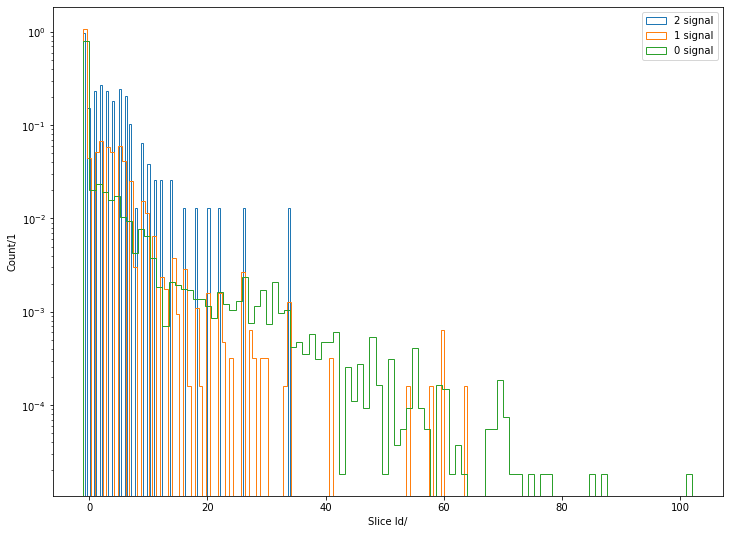

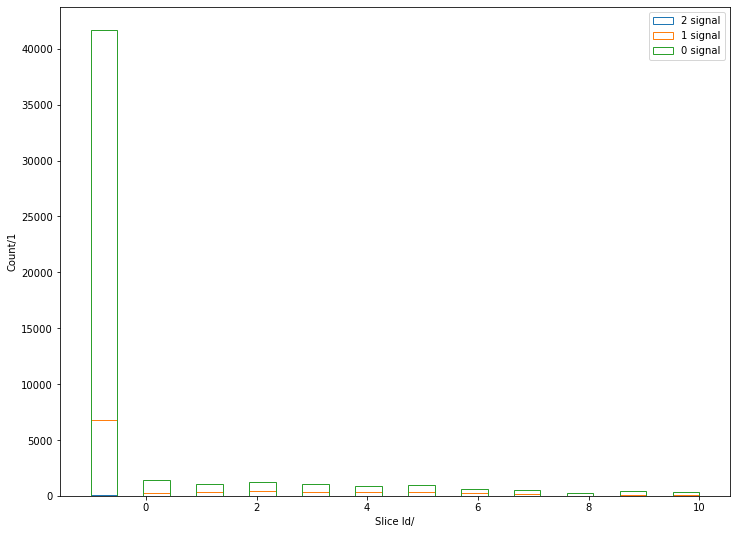

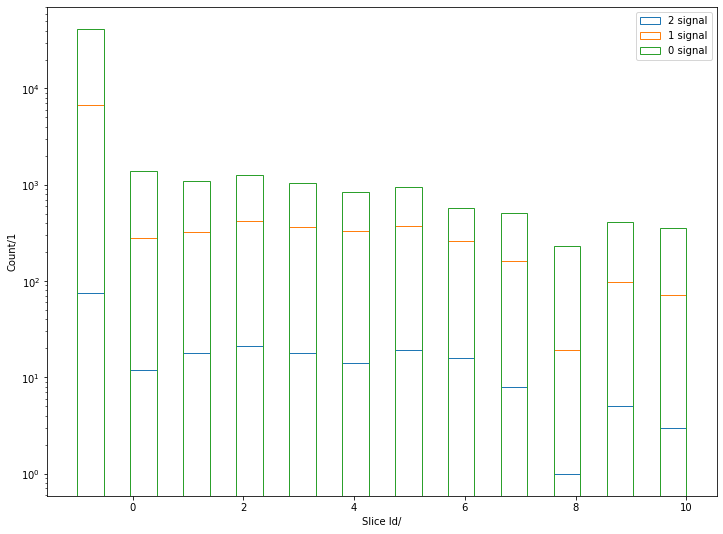

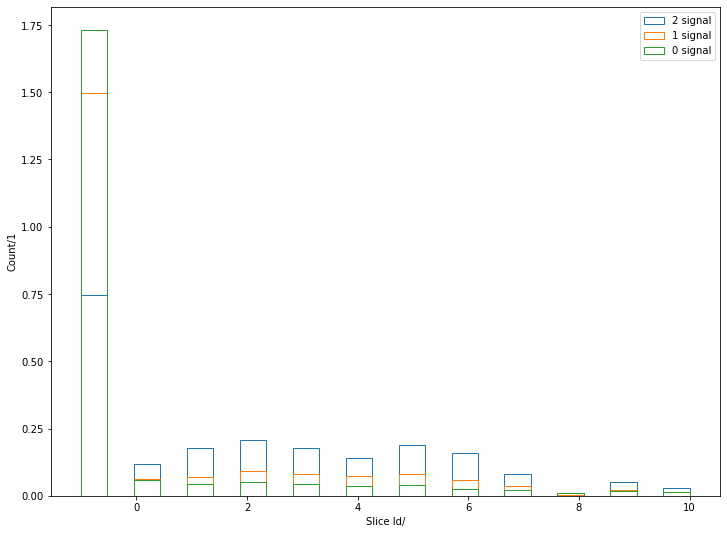

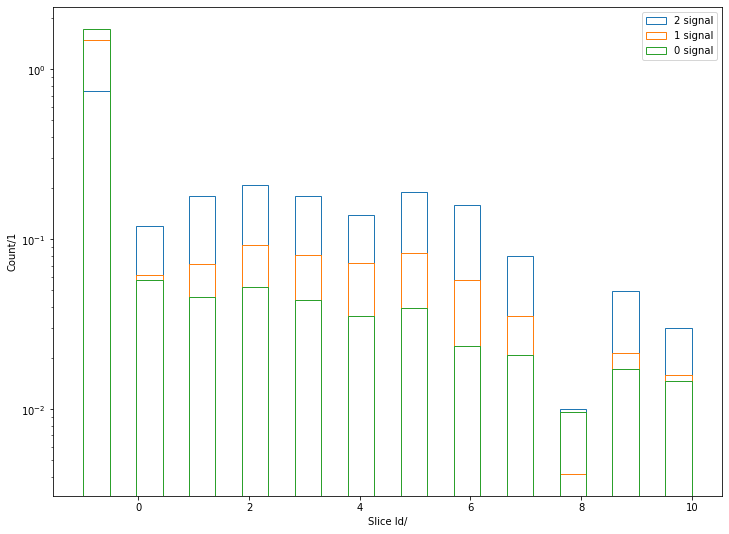

In [121]:
plot_pair_hists("slice id", "", paired_beam_slice(evts, pair_coords), sig_count, range=[None, (-1,10)], bins=[100, 23], inc_stacked=False)